In [31]:
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from IPython.display import display, HTML
from pdpbox import pdp, info_plots #for partial plots
import joblib, os
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize



scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
           'f1_macro':'f1_macro'}


models_transfer = {
    'knn':'KNN',
    'knn_im':'KNN',
    'svm':'SVM',
    'svm_im':'SVM',
    'random':'Random Forest',
    'random_im':'Random Forest',
    'gb':'Gradient Boosting',
    'gb_im':'Gradient Boosting',
    'mlp':'MLP',
    'mlp_im':'MLP',
    'nb':'Naive Bayes',
    'nb_im':'Naive Bayes'
}


models_names = {
    'knn':'Balanced',
    'knn_im':'Imbalanced',
    'svm':'Balanced',
    'svm_im':'Imbalanced',
    'random':'Balanced',
    'random_im':'Imbalanced',
    'gb':'Balanced',
    'gb_im':'Imbalanced',
    'mlp':'Balanced',
    'mlp_im':'Imbalanced',
    'nb':'Balanced',
    'nb_im':'Imbalanced'
}


title = '156selected_156_1203'
KFOLD = 10
N_JOBS = 10


def mkdir(path):
    path = path.strip()
    path = path.rstrip("\\")
    isExists = os.path.exists(path)

    if not isExists:
        os.makedirs(path)
        return True
    else:
        return False


def preprocess(countpath, testsize = 0.2, randomstate = 1):
    x = pd.read_csv('%s' % countpath, index_col=0).T

    # get feature names
    featurenames = np.array(x.index)

    # get label names
    x = x.T
    y = list(np.array(x.index))
    label = sorted(list(set(y)), key = y.index)
    
    df = x
    df['target'] = y

    for classname in label:
        count_temp = len(df[df.target == classname])
        print("Proportion of family {0}: {1:.2f}%".format(classname, (count_temp / (len(df.target)) * 100)))


    y = df.target.values
    y = label_binarize(y, classes=label)
    x= df.drop(['target'], axis=1)
    
#     x = (x - np.min(x)) / (np.max(x) - np.min(x)).values
    
    
    x = x.dropna(axis=1, how='any')  # drop all rows that have any NaN value
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = testsize, random_state = randomstate)

    return x_train, y_train, x_test, y_test, featurenames, label, df


def heat_norm_col(label, featurenames, x_train, counting):
    heat = pd.DataFrame(0, index=np.arange(len(label)), columns=np.arange(featurenames.size))
    heat.index = label
    heat.columns = featurenames
    for i in range(0, len(x_train.index)):
        for j in range(0, len(x_train.columns)):
            heat.loc[x_train.index[i], x_train.columns[j]] = heat.loc[x_train.index[i], x_train.columns[j]] + x_train.iloc[i, j]


    heat_norm = heat
    for i in range(0, len(heat_norm.index)):
        for j in range(0, len(heat_norm.columns)):
            heat_norm.iloc[i, j] = heat_norm.iloc[i, j] / counting[heat_norm.index[i]]

    # Now if we normalize it by column:
    heat_norm_col = heat_norm
    heat_norm_col=(heat_norm_col-heat_norm_col.mean())/heat_norm_col.std()

    return heat_norm_col


def counting(label, x_train):
    counting = {}
    for i in label:
        count = 0
        for j in x_train.index:
            if i == j:
                count = count+1        
        counting[i] = count
    print(counting)
    
    return counting


def smote_dict(label, counting):
    dict = {}
    for i in label:
        if i == 'RF00168':
            dict[i] = counting[i] * 6
        elif counting[i] > 1000:
            dict[i] = counting[i]
        elif counting[i] > 700:
            dict[i] = counting[i] * 2
        elif counting[i] > 500:
            dict[i] = counting[i] * 3
        elif counting[i] > 200:
            dict[i] = counting[i] * 5
        else:
            dict[i] = counting[i] * 10
    print(dict)
    return dict


def calcu_metrix(scores):
    return (np.mean(scores['test_f1_macro']) * 0.6 + np.mean(scores['test_prec_macro'])*0.2 + np.mean(scores['test_rec_macro'])* 0.2)


def print_report(name, model, x_test, y_test):
    
    model_pred = model.predict(x_test)
    
    # f1 score
    print("f1 score of {0}: {1:.3f}".format(name, f1_score(y_test,model_pred, average = 'macro')))
    # 模型评估报告
    report = classification_report(y_test, model_pred, target_names= label, output_dict=True)
    
    dataframe = pd.DataFrame(report).transpose()
    dataframe.to_csv('./Prediction_output_%s/Classification_report/%s_%s.csv' % (title, title, name), index = False)

    print("Classification report of {0}: \n{1}".format(name, classification_report(y_test, model_pred,
                                            target_names= label, digits = 3)))

    


def save(model, model_name):
    joblib.dump(model, './Model/%s_%s.pkl' % (model_name, title))

    
def load(model_name):
    return joblib.load('./Model/%s_%s.pkl' % (model_name, title))


def export_con_matrix(model, model_name):
    pred = model.predict(x_test)
    confusion = pd.DataFrame(confusion_matrix(y_test, pred))
    mkdir('./Confusion_matrix/%s' % title)
    confusion.to_csv('./Confusion_matrix/%s/Confusion_matrix_%s_%s.csv' % (title, model_name, title))
    return confusion


def plot_confusion_matrix(model, model_name, label, balance = 'Balanced', cmap = plt.cm.Blues, normalize = True):
#     model.fit(x_train, y_train)
    pred = model.predict(x_test)
    confusion = confusion_matrix(y_test, pred)
    
    mkdir('./Figures/%s' % title)
    plot_con_matrix(confusion, model_name, label, featurenames = label, normalize=normalize, 
                    title = 'Normalized Confusion Matrix of %s %s Model with 156 Features' % (balance, model_name) , cmap = cmap)


def plot_feature_distribution_heatmap(heat_norm_col,label, featurenames, cmp = plt.cm.Blues):
    
    mkdir('./Figures/%s' % title)
    plot_feature_distribution_matrix(heat_norm_col.T, label, featurenames, normalize = False, 
                                     title = 'Normalized Feature Distribution of Every Family', cmap = cmp)
    

def plot_con_matrix(cm, model_name, classes,normalize = False,title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    SMALL_SIZE = 9
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 19
    TICK_SIZE = 11

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
    
    fig, ax = plt.subplots(figsize = (16, 12), dpi = 330)
#     fig, ax = plt.subplots(figsize = (16, 48))
    my_cmap = plt.cm.get_cmap(cmap)
    my_cmap.set_under('w')
    im = ax.imshow(cm, interpolation='nearest',cmap = my_cmap,vmin=0.02)
    ax.figure.colorbar(im, ax=ax)
    
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, 
           yticklabels = classes if featurenames == None else featurenames,
          )
    
    fig.suptitle('%s' % title, fontsize=BIGGER_SIZE)    
    plt.xlabel('Predicted Family', fontsize=MEDIUM_SIZE)
    plt.ylabel('True Family', fontsize=MEDIUM_SIZE)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Adjust the space between ticks and label
    ax.tick_params(axis='both', which='major', pad=5)
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] >= 0.02:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()
    
    fig.savefig('./Figures/%s/confusion_matrix_%s_%s.pdf' % (globals()['title'], model_name, balance), format='pdf', bbox_inches='tight')
    
    return fig, ax


def plot_feature_distribution_matrix(cm, classes, featurenames, normalize = False,title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Standardized Feature Distribution'
        else:
            title = 'Not Standardized Feature Distribution'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    SMALL_SIZE = 14
    MEDIUM_SIZE = 18
    BIGGER_SIZE = 21
    TICK_SIZE = 18

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
    
    my_cmap = plt.cm.get_cmap(cmap)
    my_cmap.set_under('w')
    
    cbar_kws = {
            'orientation':'vertical',
            'shrink':3,
            'ticks':np.arange(-5, 5),
            "drawedges":True,
            'extendfrac':0.5
           }

    plt.figure()
    ax = sns.clustermap(heat_norm_modi.T, cmap = 'RdYlBu_r', figsize = (20, 80), z_score=0, cbar_kws=cbar_kws, center = 0.6, col_cluster=False)
    
    # We want to show all ticks...
#     ax.set(xticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            # ... and label them with the respective list entries
#            xticklabels = classes, 
#            yticklabels = featurenames,
#           )
    
    ax.fig.suptitle('%s' % title, fontsize=BIGGER_SIZE)    
    plt.xlabel('Family Names', fontsize=MEDIUM_SIZE)
    plt.ylabel('Feature Names', fontsize=MEDIUM_SIZE)
    
    plt.setp(ax.ax_heatmap.get_yticklabels(), rotation=-15, fontsize = TICK_SIZE)  # For y axis
    plt.setp(ax.ax_heatmap.get_xticklabels(), rotation=45, fontsize = TICK_SIZE) # For x axis

#     # Adjust the space between ticks and label
#     ax.tick_params(axis='both', which='major', pad=6)
    
    fig.tight_layout(rect=[0, 0.1, 1, 0.975])
#     fig.tight_layout()
    plt.show()
    
    plt.savefig('./Figures/%s/Feature_distribution.pdf' % (globals()['title']), format='pdf', bbox_inches='tight')

In [32]:
# KNN Model
def KNN(x_train, y_train, x_test, y_test, strategy):

    # try ro find best k value
    best = make_pipeline(SMOTE(random_state = 5, k_neighbors = 5), OneVsRestClassifier(KNeighborsClassifier(n_neighbors=6)))
    scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
    best_scores = scores
    print(6)
    print(scores)
    best_metrix = calcu_metrix(scores)
    best.fit(x_train, y_train)

    scoreList = []
    scoreList.append(best.score(x_test, y_test))
    for i in range(8, 16, 2):
        knn2 = make_pipeline(SMOTE(random_state = 5, k_neighbors = 5, sampling_strategy = strategy), \
                             OneVsRestClassifier(KNeighborsClassifier(n_neighbors=i)))  # n_neighbors means 
        scores = cross_validate(knn2, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = knn2
            best_scores = scores
        knn2.fit(x_train, y_train)
        scoreList.append(knn2.score(x_test, y_test))

    
    plt.plot(range(6, 16, 2), scoreList)
    plt.xticks(np.arange(6, 16, 2))
    plt.xlabel("K value")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/knn_iteration.png" % title)
    plt.show()
    print("Maximum KNN Acuracy Score is {:.2f}%".format((max(scoreList)) * 100))
    
    
    print_report('knn', best, x_test, y_test)
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/knn_cross_validation_score.csv' % title, index=True)

    return best

def KNN_im(x_train, y_train, x_test, y_test):

    # try ro find best k value
    best = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=6))
    scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
    best_scores = scores
    print(6)
    print(scores)
    best_metrix = calcu_metrix(scores)
    best.fit(x_train, y_train)

    scoreList = []
    scoreList.append(best.score(x_test, y_test))
    for i in range(8, 16, 2):
        knn2 = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=i))  # n_neighbors means 
        scores = cross_validate(knn2, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = knn2
            best_scores = scores
        knn2.fit(x_train, y_train)
        scoreList.append(knn2.score(x_test, y_test))
        

    plt.plot(range(6, 16, 2), scoreList)
    plt.xticks(np.arange(6, 16, 2))
    plt.xlabel("K value")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/knn_im_iteration.png" % title)
    plt.show()

    print("Maximum KNN_im Acuracy Score is {:.2f}%".format((max(scoreList)) * 100))
    
    print_report('knn_im', best, x_test, y_test)
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/knn_im_cross_validation_score.csv' % title, index=True)

 
    return best

In [33]:
def svm(x_train, y_train,x_test, y_test, strategy):
    
    best = make_pipeline(SMOTE(sampling_strategy = strategy), OneVsRestClassifier(SVC(cache_size=4096, kernel='linear')))
    best_metrix = 0
    scoreList = []
    for i in ('poly', 'rbf'):
        svm = make_pipeline(SMOTE(sampling_strategy = strategy), \
                            OneVsRestClassifier(SVC(cache_size=4096, kernel='%s' % i, probability = True, class_weight = 'balanced'))
        scores = cross_validate(svm, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = svm
            best_scores = scores
        svm.fit(x_train, y_train)
        scoreList.append((i, svm.score(x_test, y_test)))
        
    print("Maximum kernel Score is {:.2f}%".format((max([x[1] for x in scoreList])) * 100))
    
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/svm_cross_validation_score.csv' % title, index=True)
    print_report('svm', best, x_test, y_test)

    return best

def svm_im(x_train, y_train,x_test, y_test):

    best = SVC(cache_size=4096, kernel='linear')
    best_metrix = 0
    
    # try to find the best kernel
    scoreList = []
    for i in ('poly', 'rbf'):
        svm = OneVsRestClassifier(SVC(cache_size=4096, kernel='%s' % i, probability = True))
        scores = cross_validate(svm, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = svm
            best_scores = scores
        svm.fit(x_train, y_train)
        scoreList.append((i, svm.score(x_test, y_test)))


    plt.title('Various kernels of SVM algorithms')
    plt.plot([x[0] for x in scoreList], [x[1] for x in scoreList])
    plt.xticks([x[0] for x in scoreList])
    plt.xlabel("Kernel")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/svm_im_kernel.png" % title)
    plt.show()
    print("Maximum kernel Score is {:.2f}%".format((max([x[1] for x in scoreList])) * 100))

    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/svm_im_cross_validation_score.csv' % title, index=True)
    print_report('svm_im', best, x_test, y_test)

    return best

SyntaxError: invalid syntax (<ipython-input-33-f1547378c9f6>, line 4)

In [34]:
def random_forest(x_train, y_train, x_test, y_test, strategy, class_weight = None):
    
    #使用网格搜索 查找最优参数
    
#     param_grid = [{'randomforestclassifier__n_estimators': [2000, 1000, 500],
#                'randomforestclassifier__max_features': [50, 30],
#                'randomforestclassifier__max_depth': [20, 15, 10]}]
    
    param_grid = [{'randomforestclassifier__n_estimators': [1000],
                   'randomforestclassifier__max_depth': [20]}]

    best = make_pipeline(SMOTE(sampling_strategy = strategy), \
                         OneVsRestClassifier(RandomForestClassifier(n_jobs=20, n_estimators = 1000, \
                                                                    max_depth = 20, class_weight = class_weight)))
#     grid_search = GridSearchCV(best, param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     best_scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 10, n_jobs=-1)
    
#     print(scores)
    best.fit(x_train, y_train)
    print("Test score: {:.2f}".format(best.score(x_test, y_test)))
    
#     best_scores = pd.DataFrame(best_scores).transpose()
#     best_scores.to_csv('./Prediction_output/svm_im_cross_validation_score.csv', index=True)
    print_report('random_forest', best, x_test, y_test)

    return best

def random_forest_im(x_train, y_train, x_test, y_test, class_weight = None):

    #使用网格搜索 查找最优参数
    
#     param_grid = [{'randomforestclassifier__n_estimators': [2000, 1000, 500],
#                'randomforestclassifier__max_features': [50, 30],
#                'randomforestclassifier__max_depth': [20, 15, 10]}]
    
    best_tested_param_grid = [{'randomforestclassifier__n_estimators': [1000],
                   'randomforestclassifier__max_depth': [20]}]

    best = OneVsRestClassifier(RandomForestClassifier(n_jobs=20, n_estimators = 1000, max_depth = 20, class_weight = class_weight))
    best.fit(x_train, y_train)
#     grid_search = GridSearchCV(best, param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 10, n_jobs=-1)
    
#     print(scores)
#     print("parameters: ", grid_search.best_params_)
    print("Test score: {:.2f}".format(best.score(x_test, y_test)))
    
#     best_scores = pd.DataFrame(best_scores).transpose()
#     best_scores.to_csv('./Prediction_output/random_forest_im_cross_validation_score.csv', index=True)
    print_report('random_forest_im', best, x_test, y_test)
    
    return best

In [35]:
def mlp(x_train, y_train, x_test, y_test, strategy):
    mlp = make_pipeline(SMOTE(random_state = 1, sampling_strategy = strategy), \
                        OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(80, 80, 80), max_iter=200, alpha=0.0001,
                                                          solver='adam',verbose= 10, tol=0.000000001)))
    mlp.fit(x_train, y_train)
    print("Accuracy of mlp model is {:.3f}".format(mlp.score(x_test, y_test)))
    proba = mlp.predict_proba(x_test)
    # log_proba = mlp.predict_log_proba(x_test)
    print(mlp.predict(x_test))
    pred_mlp = mlp.predict(x_test)
    print((pred_mlp == y_test).sum() / y_test.size)
    
    print_report('mlp', mlp, x_test, y_test)
    return mlp

def mlp_im(x_train, y_train, x_test, y_test):
    mlp_im = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(80, 80, 80), max_iter=200, alpha=0.0001,
                     solver='adam', verbose=10, tol=0.000000001))
    mlp_im.fit(x_train, y_train)
    print("Accuracy of mlp_im imbalance model is {:.3f}".format(mlp_im.score(x_test, y_test)))
    proba = mlp_im.predict_proba(x_test)
    # log_proba = mlp_im.predict_log_proba(x_test)
    print(mlp_im.predict(x_test))
    pred_mlp_im = mlp_im.predict(x_test)
    print((pred_mlp_im == y_test).sum() / y_test.size)

    print_report('mlp_im', mlp_im, x_test, y_test)
    return mlp_im

In [36]:
def naive_bayes(x_train, y_train, x_test, y_test, strategy):
    nb = make_pipeline(SMOTE(random_state = 5, sampling_strategy = strategy), OneVsRestClassifier(GaussianNB(var_smoothing=1e-16)))
    nb.fit(x_train, y_train)
#     scores = cross_validate(nb, x_train, y_train, scoring = scoring, cv = 10)
#     print(scores)
    print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(x_test,y_test)*100))

    print_report('nb', nb, x_test, y_test)
    
#     scores = pd.DataFrame(scores).transpose()
#     scores.to_csv('./Prediction_output/nb_cross_validation_score.csv', index=True)
    
    return nb

def naive_bayes_im(x_train, y_train, x_test, y_test):
    nb = OneVsRestClassifier(GaussianNB(var_smoothing=1e-16))
    nb.fit(x_train, y_train)
#     scores = cross_validate(nb, x_train, y_train, scoring = scoring, cv = 10)
#     print(scores)
    print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(x_test, y_test)*100))

    print_report('nb_im', nb, x_test, y_test)
#     scores = pd.DataFrame(scores).transpose()
#     scores.to_csv('./Prediction_output/nb_cross_validation_score.csv', index=True)
    
    return nb

In [37]:
def gradient_boosting(x_train, y_train, x_test, y_test, strategy):


    # 网格搜索算法查询最优参数（n_estimators 树个数；learning_rate 学习率； max_depth 树深度 ）
    # params_gbrt = [{
    #     'gradientboostingclassifier__n_estimators':[500,1000,2000],
    #     'gradientboostingclassifier__learning_rate':[0.01,0.1,0.05],
    #     'gradientboostingclassifier__max_depth':[7, 9, 11]
    # }]

    params_gbrt = {
        'n_estimators':1000,
        'learning_rate':0.05,
        'max_depth': 15
    }

    # gbrt_grid = GridSearchCV(gbrt, params_gbrt, cv=5, n_jobs=10)
    # gbrt_grid.fit(x_train, y_train)
    # #gbrt.fit(x_train, y_train)

    # print('Report of gradient_boosting:\n')
    # print("Best cross-validation score: {:.2f}".format(gbrt_grid.best_score_))
    # print("Best parameters: ", gbrt_grid.best_params_)
    # print("Accuracy on training set:{:.3f}".format(gbrt_grid.score(x_train, y_train)))
    # print("Accuracy on test set:{:.3f}".format(gbrt_grid.score(x_test, y_test)))

    ## 使用gbrt的最优参数构建模型 并评估模型性能
    # best_params_gbrt = gbrt_grid.best_params_

    gbrt_model = make_pipeline(SMOTE(random_state = 1, sampling_strategy = dict), \
                               OneVsRestClassifier(GradientBoostingClassifier(**params_gbrt)))
    gbrt_model.fit(x_train, y_train)
    
    print("Accuracy on test set:{:.3f}".format(gbrt_model.score(x_test, y_test)))
    print_report('gb', gbrt_model, x_test, y_test)

    return gbrt_model

def gradient_boosting_im(x_train, y_train, x_test, y_test):
    
    params_gbrt = {
        'n_estimators':1000,
        'learning_rate':0.05,
        'max_depth': 15
    }

#     gbrt_grid = GridSearchCV(gbrt, params_gbrt, cv=5, n_jobs=5)
#     gbrt_grid.fit(x_train, y_train)
    #gbrt.fit(x_train, y_train)

#     print('Report of gradient_boosting:\n')
#     print("Best cross-validation score: {:.2f}".format(gbrt_grid.best_score_))
#     print("Best parameters: ", gbrt_grid.best_params_)
#     print("Accuracy on training set:{:.3f}".format(gbrt_grid.score(x_train, y_train)))
#     print("Accuracy on test set:{:.3f}".format(gbrt_grid.score(x_test, y_test)))

#     ## 使用gbrt的最优参数构建模型 并评估模型性能
#     best_params_gbrt = gbrt_grid.best_params_

    gbrt_model = OneVsRestClassifier(GradientBoostingClassifier(**params_gbrt))
    gbrt_model.fit(x_train, y_train)
    
#     scores = cross_validate(gbrt_model, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
    print("Accuracy on train set:{:.3f}".format(gbrt_model.score(x_test, y_test)))
    print("Accuracy on test set:{:.3f}".format(gbrt_model.score(x_test, y_test)))

    print_report('gb_im', gbrt_model, x_test, y_test)

    return gbrt_model    # 梯度提升回归树  GBRT

In [77]:
if __name__ == '__main__':
    countpath = './156_new_selected_156.csv'

    x_train, y_train, x_test, y_test, featurenames, label, dataframe = preprocess(countpath, 0.3, 3)
    
    
    mkdir('./Prediction_output_%s/Classification_report' % title)
    count = counting(label, x_train)
    dict = smote_dict(label, count)
   

Proportion of family RF00050: 7.48%
Proportion of family RF00059: 22.34%
Proportion of family RF00162: 7.67%
Proportion of family RF00167: 5.02%
Proportion of family RF00168: 2.11%
Proportion of family RF00174: 26.48%
Proportion of family RF00234: 1.70%
Proportion of family RF00380: 1.34%
Proportion of family RF00504: 13.13%
Proportion of family RF00521: 1.03%
Proportion of family RF00522: 0.72%
Proportion of family RF00634: 1.33%
Proportion of family RF01051: 6.30%
Proportion of family RF01054: 0.24%
Proportion of family RF01055: 1.87%
Proportion of family RF01057: 1.22%
{'RF00050': 827, 'RF00059': 2551, 'RF00162': 852, 'RF00167': 587, 'RF00168': 245, 'RF00174': 2993, 'RF00234': 181, 'RF00380': 152, 'RF00504': 1491, 'RF00521': 133, 'RF00522': 81, 'RF00634': 155, 'RF01051': 701, 'RF01054': 21, 'RF01055': 210, 'RF01057': 148}
{'RF00050': 1654, 'RF00059': 2551, 'RF00162': 1704, 'RF00167': 1761, 'RF00168': 1470, 'RF00174': 2993, 'RF00234': 1810, 'RF00380': 1520, 'RF00504': 1491, 'RF00521'

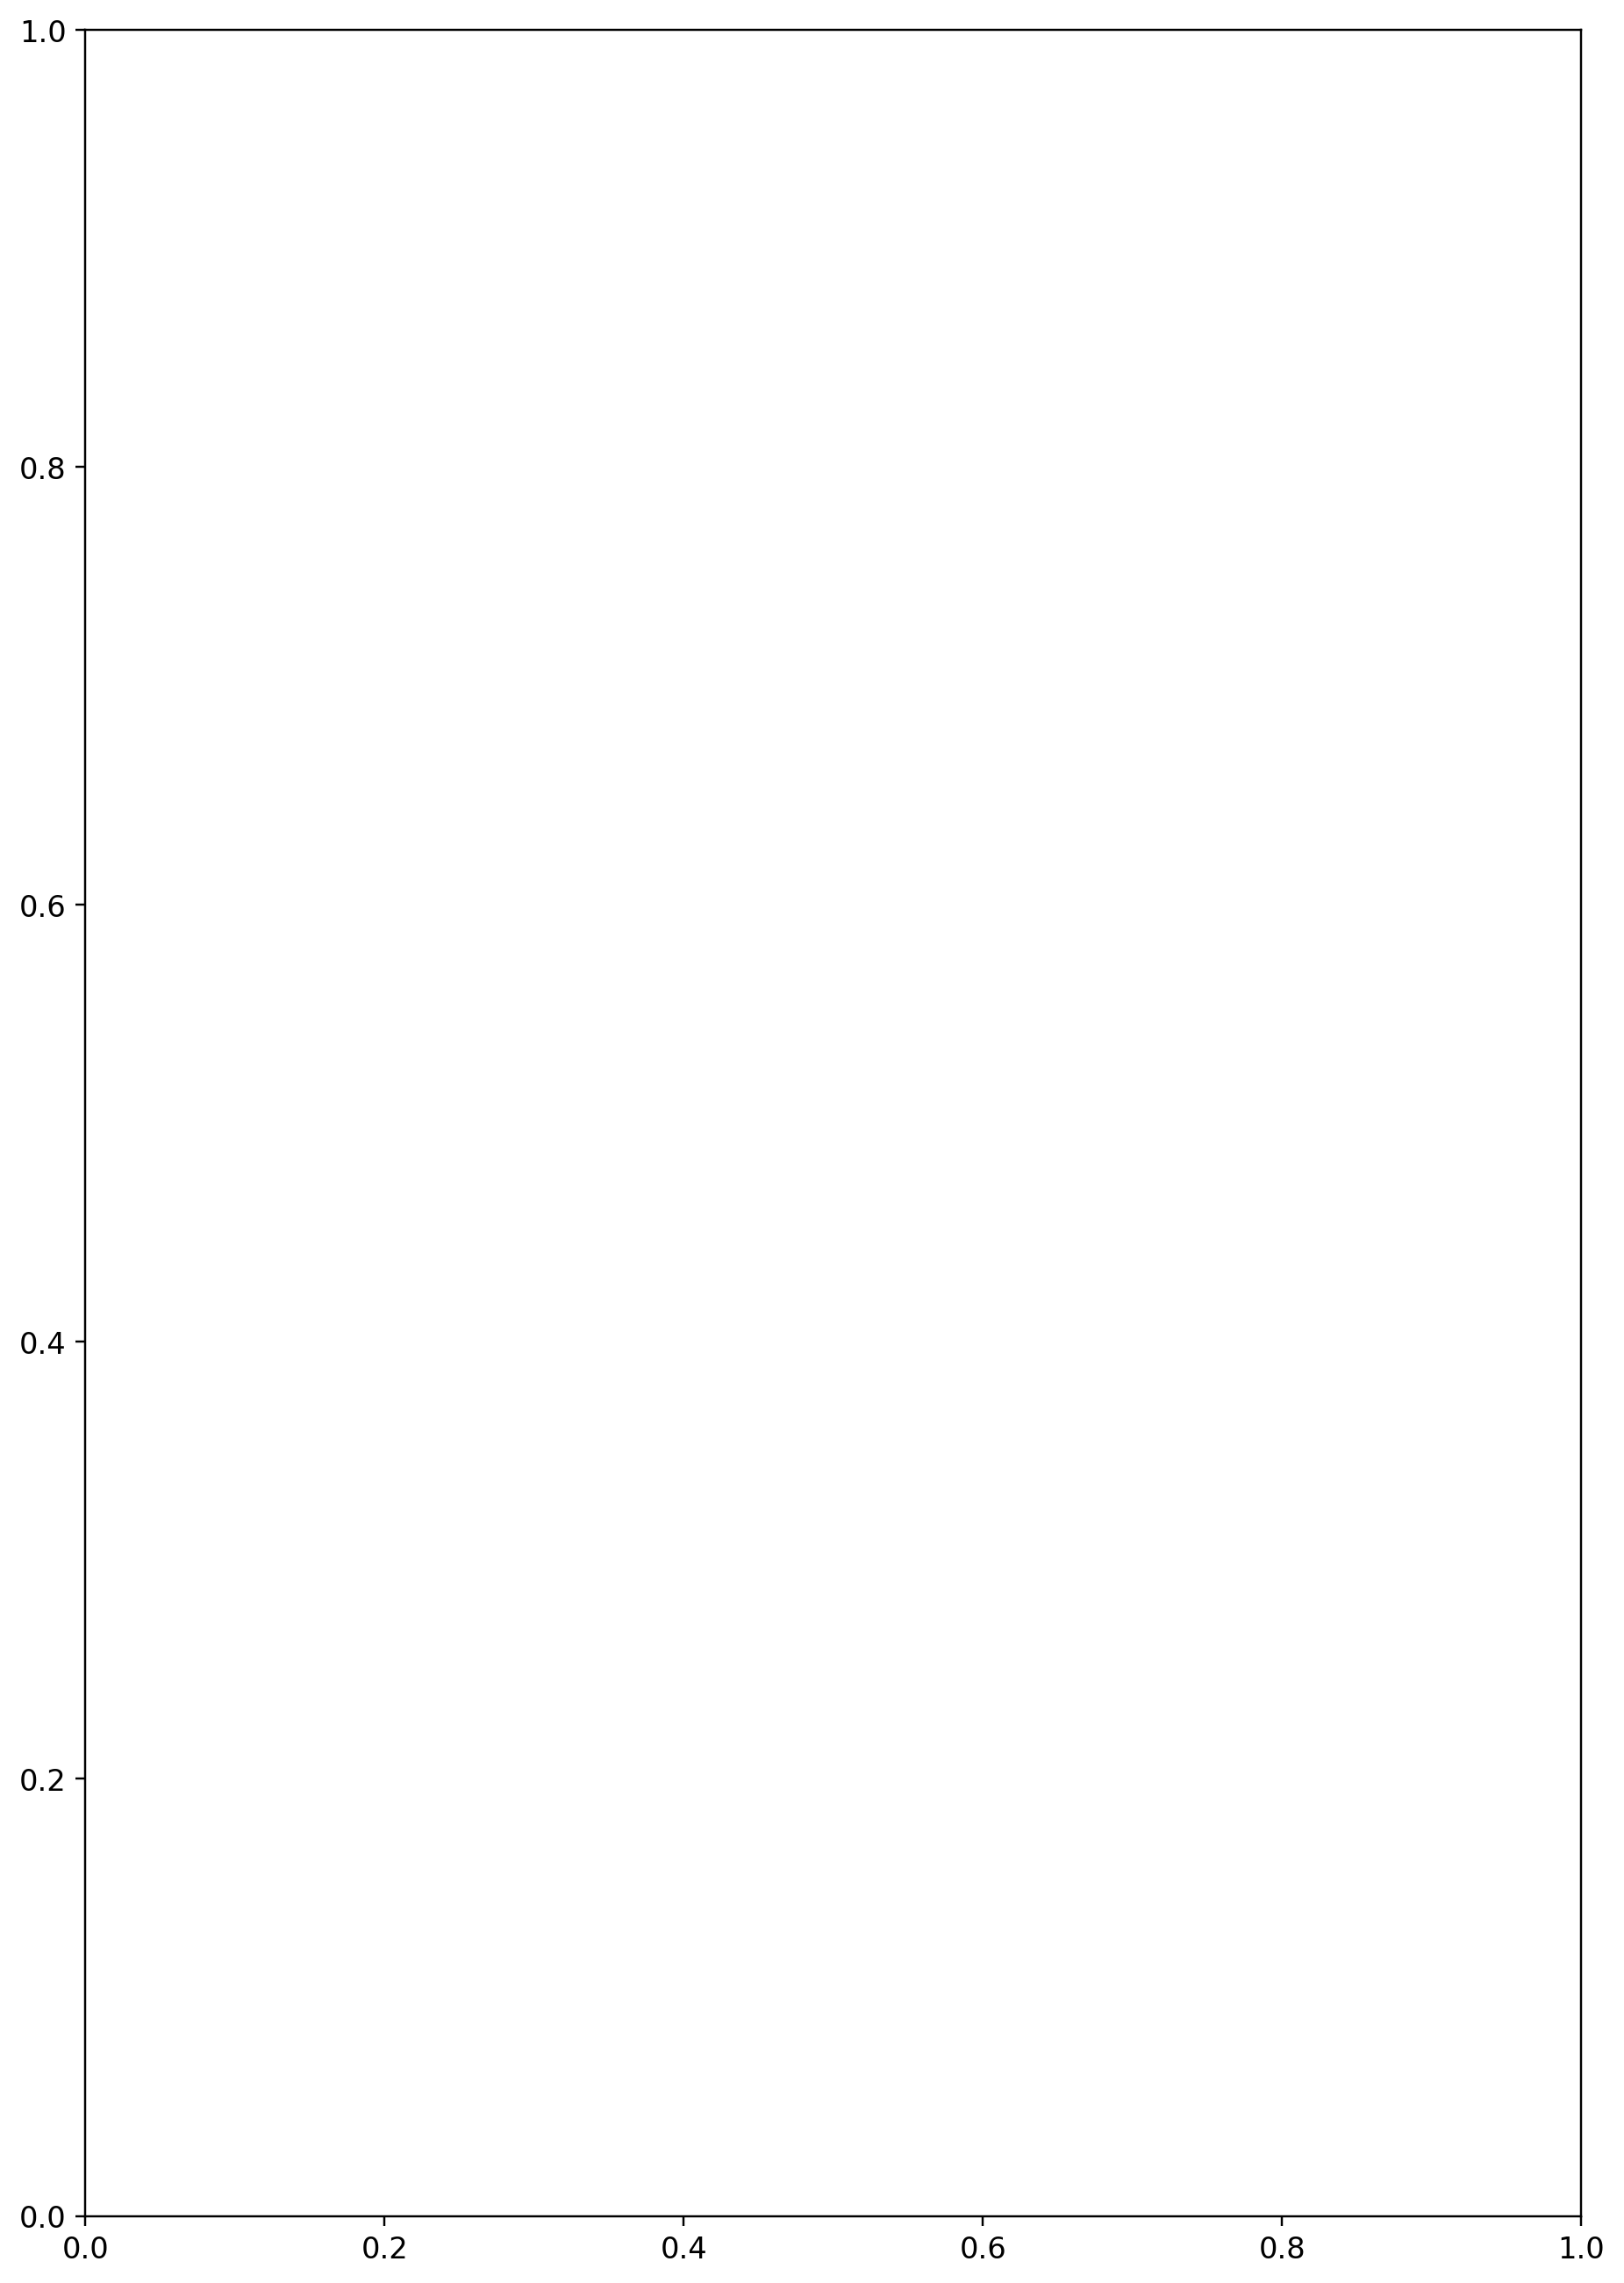

In [98]:
heat_norm = heat_norm_col(label, featurenames, x_train, count)
heat_norm.to_csv('heat_norm_156.csv')

In [394]:
heat_norm_modi = pd.read_csv('./heat_norm_156_modi.csv',index_col=0)
plot_feature_distribution_heatmap(heat_norm_modi, label, featurenames, cmp = plt.cm.RdYlBu_r)

Normalized confusion matrix


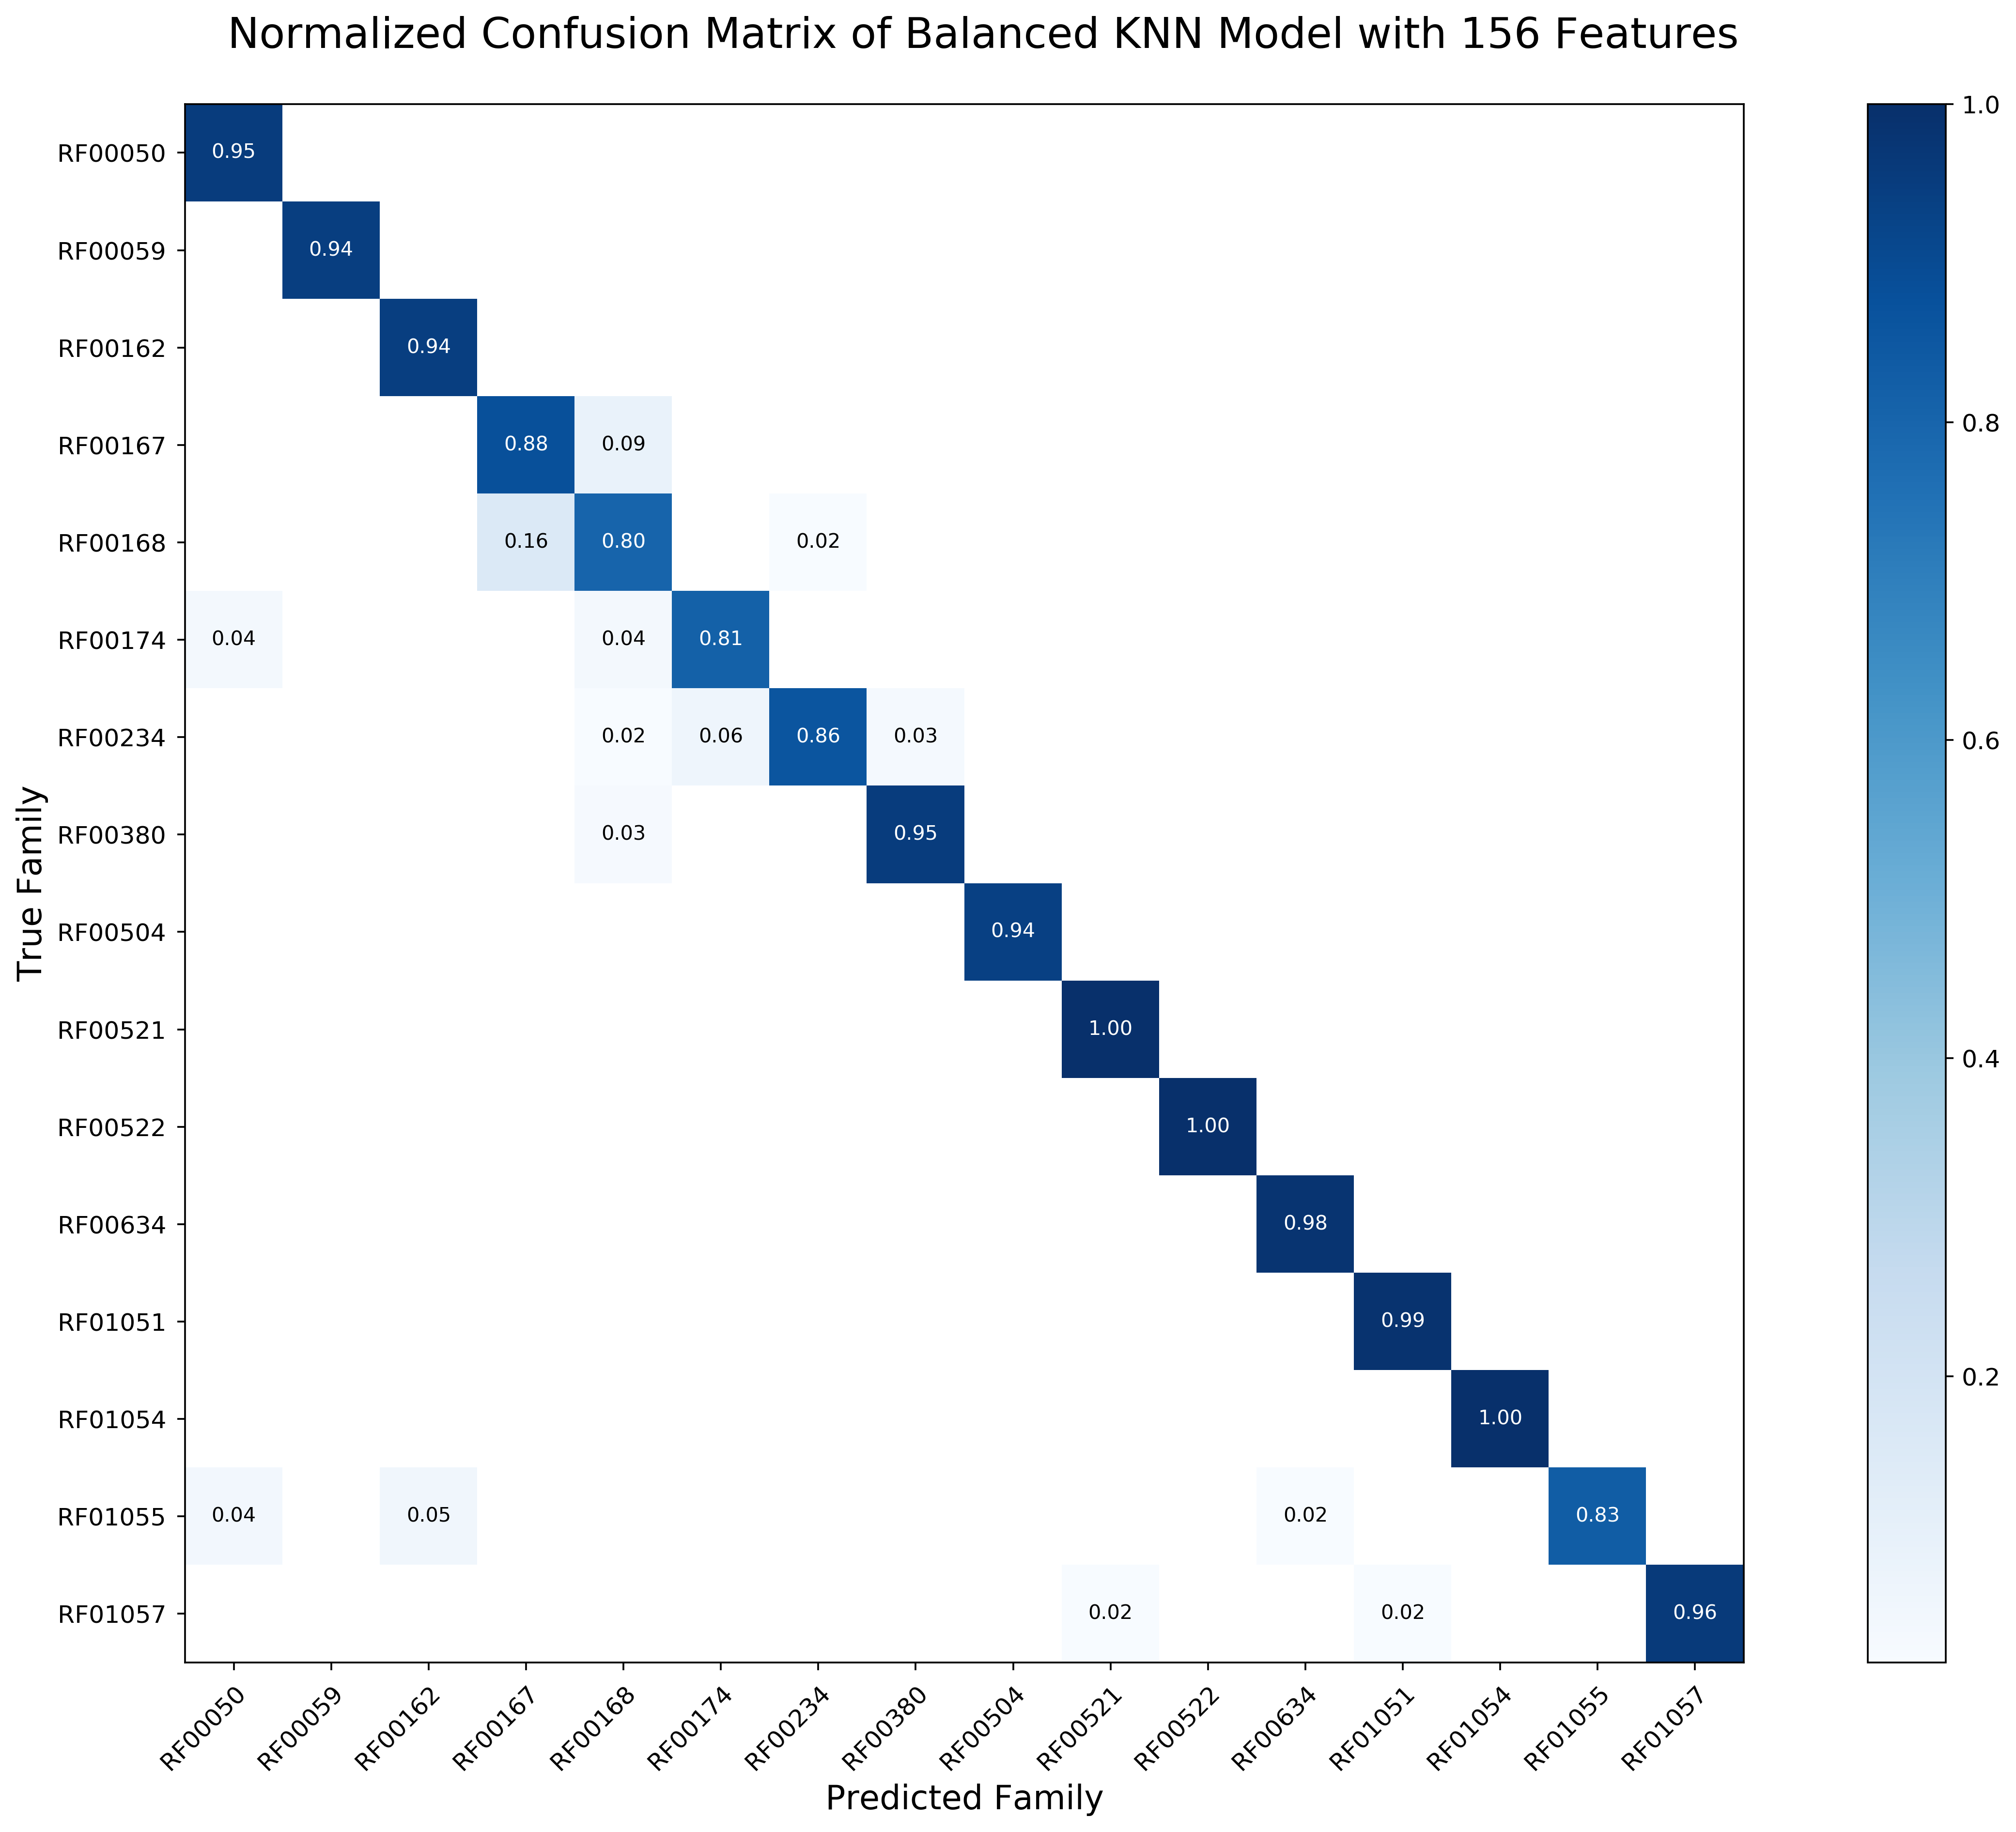

Normalized confusion matrix


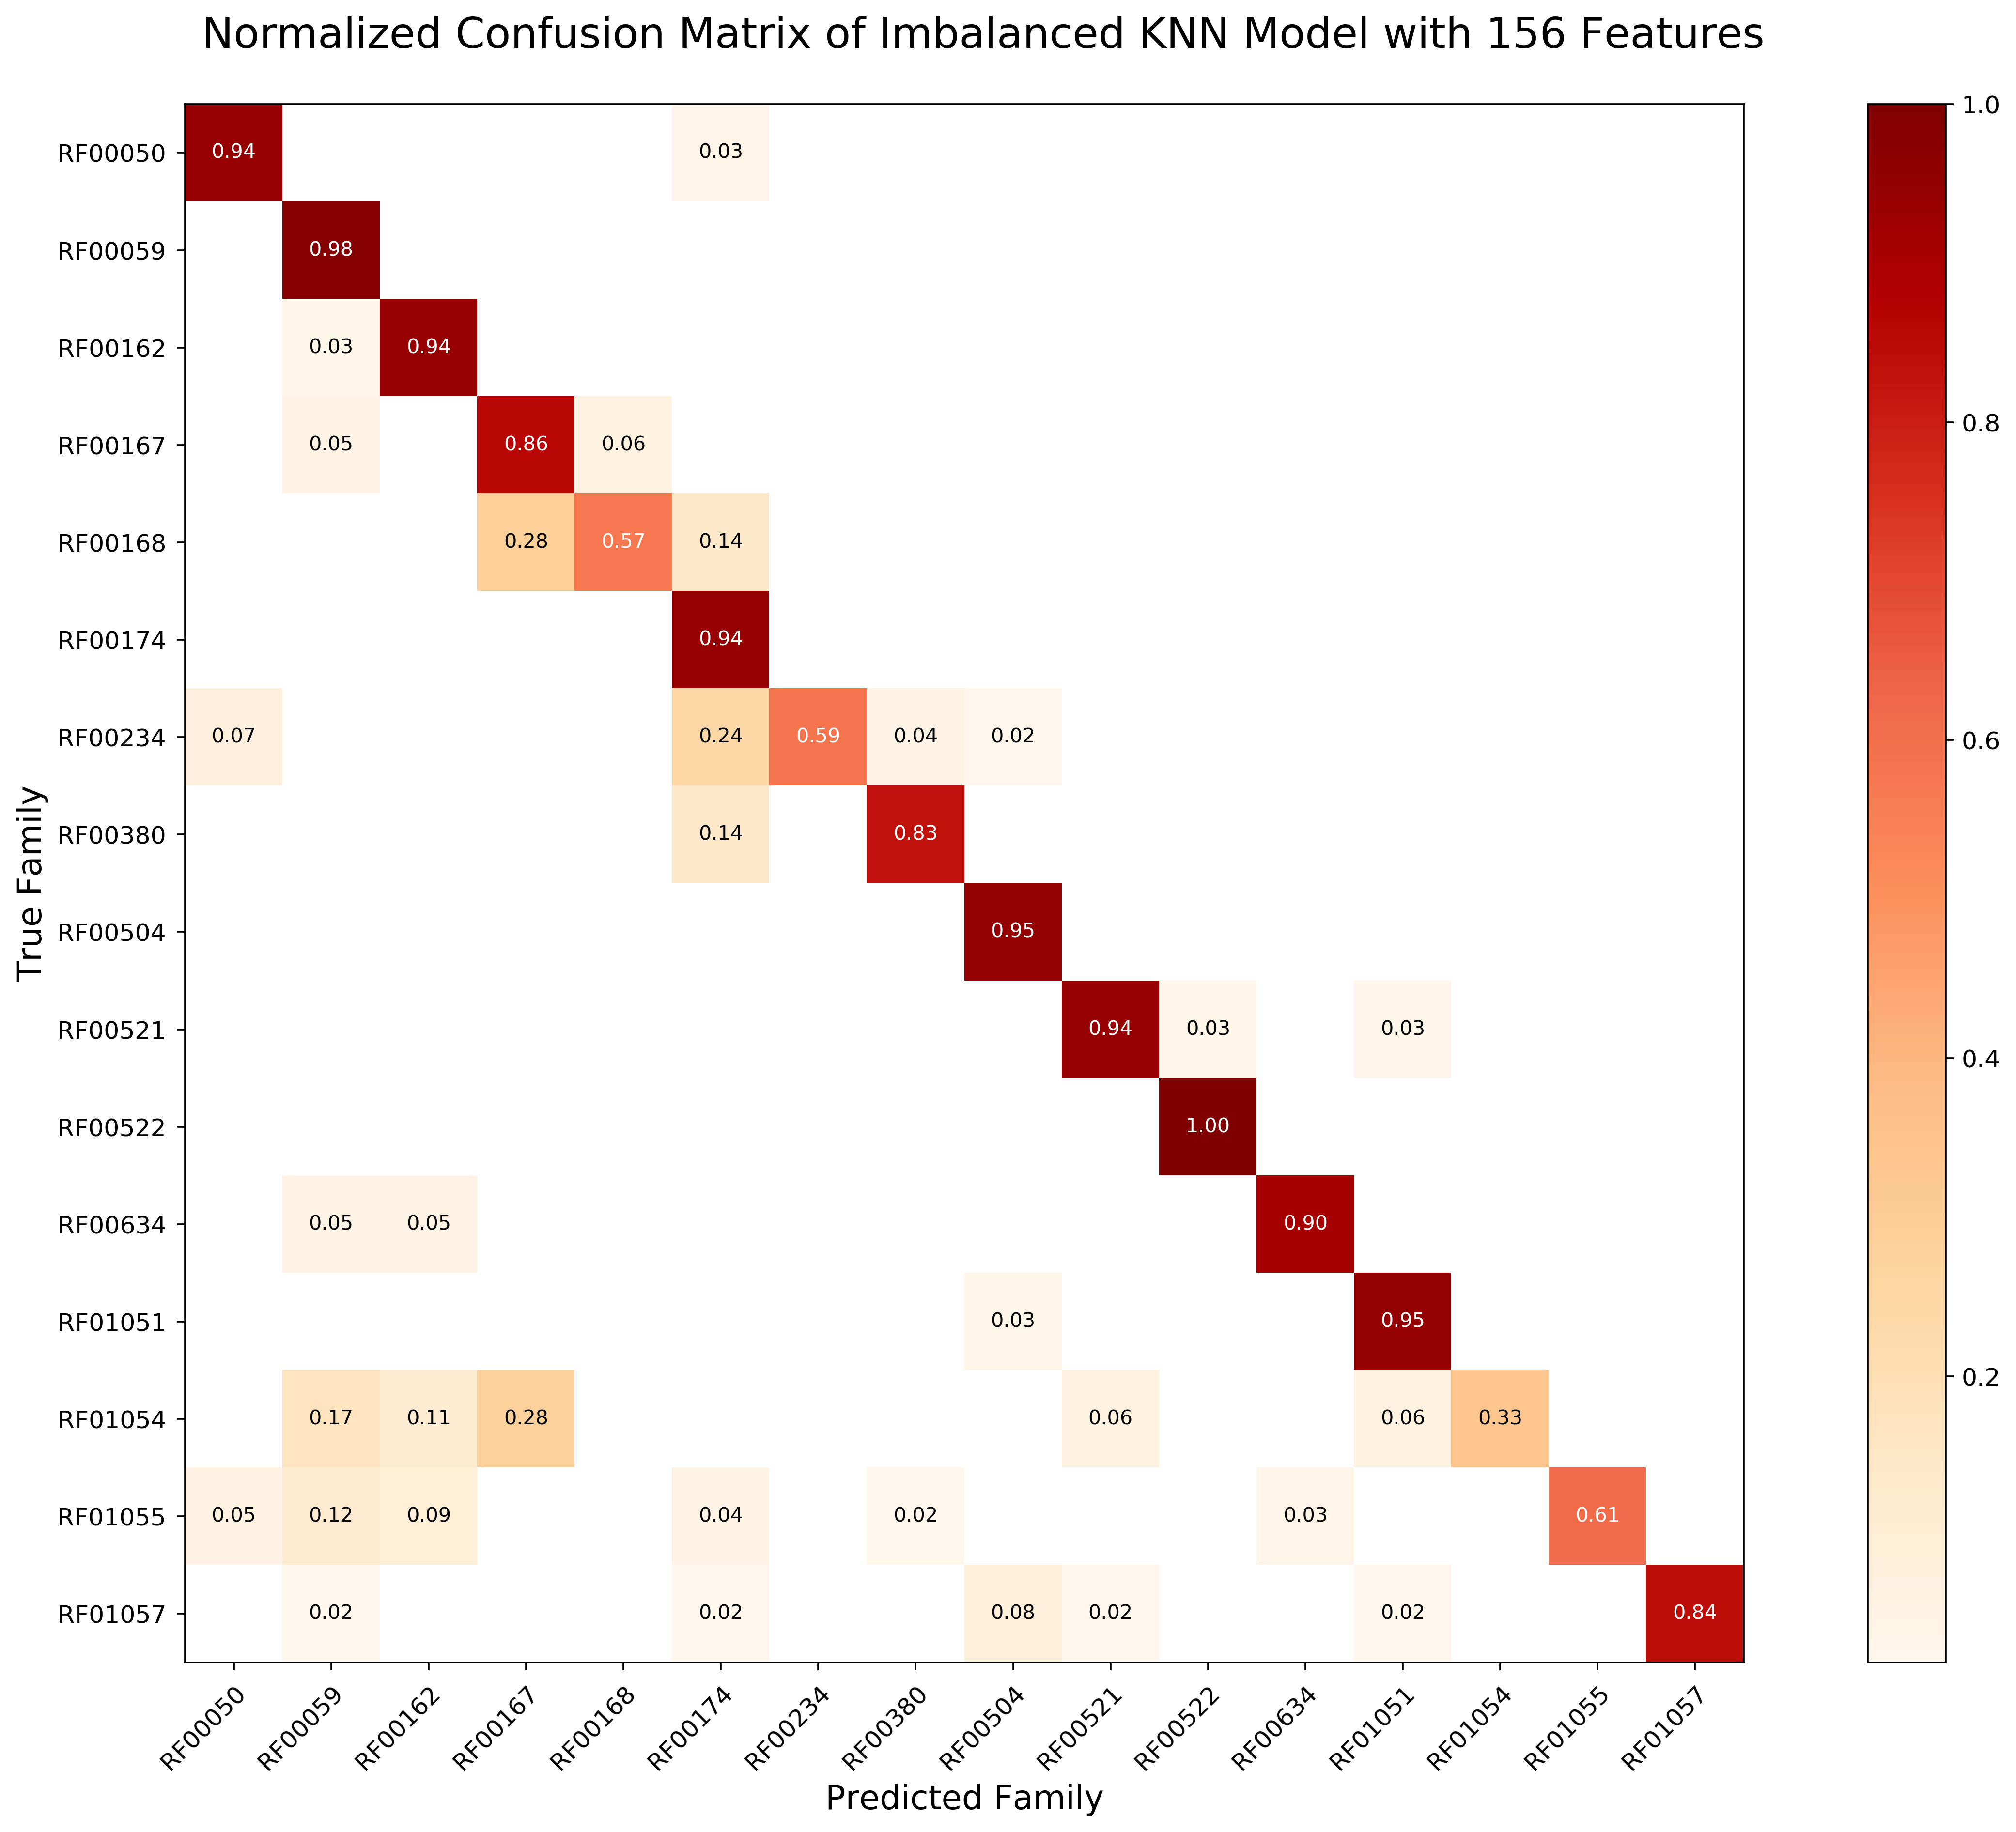

Normalized confusion matrix


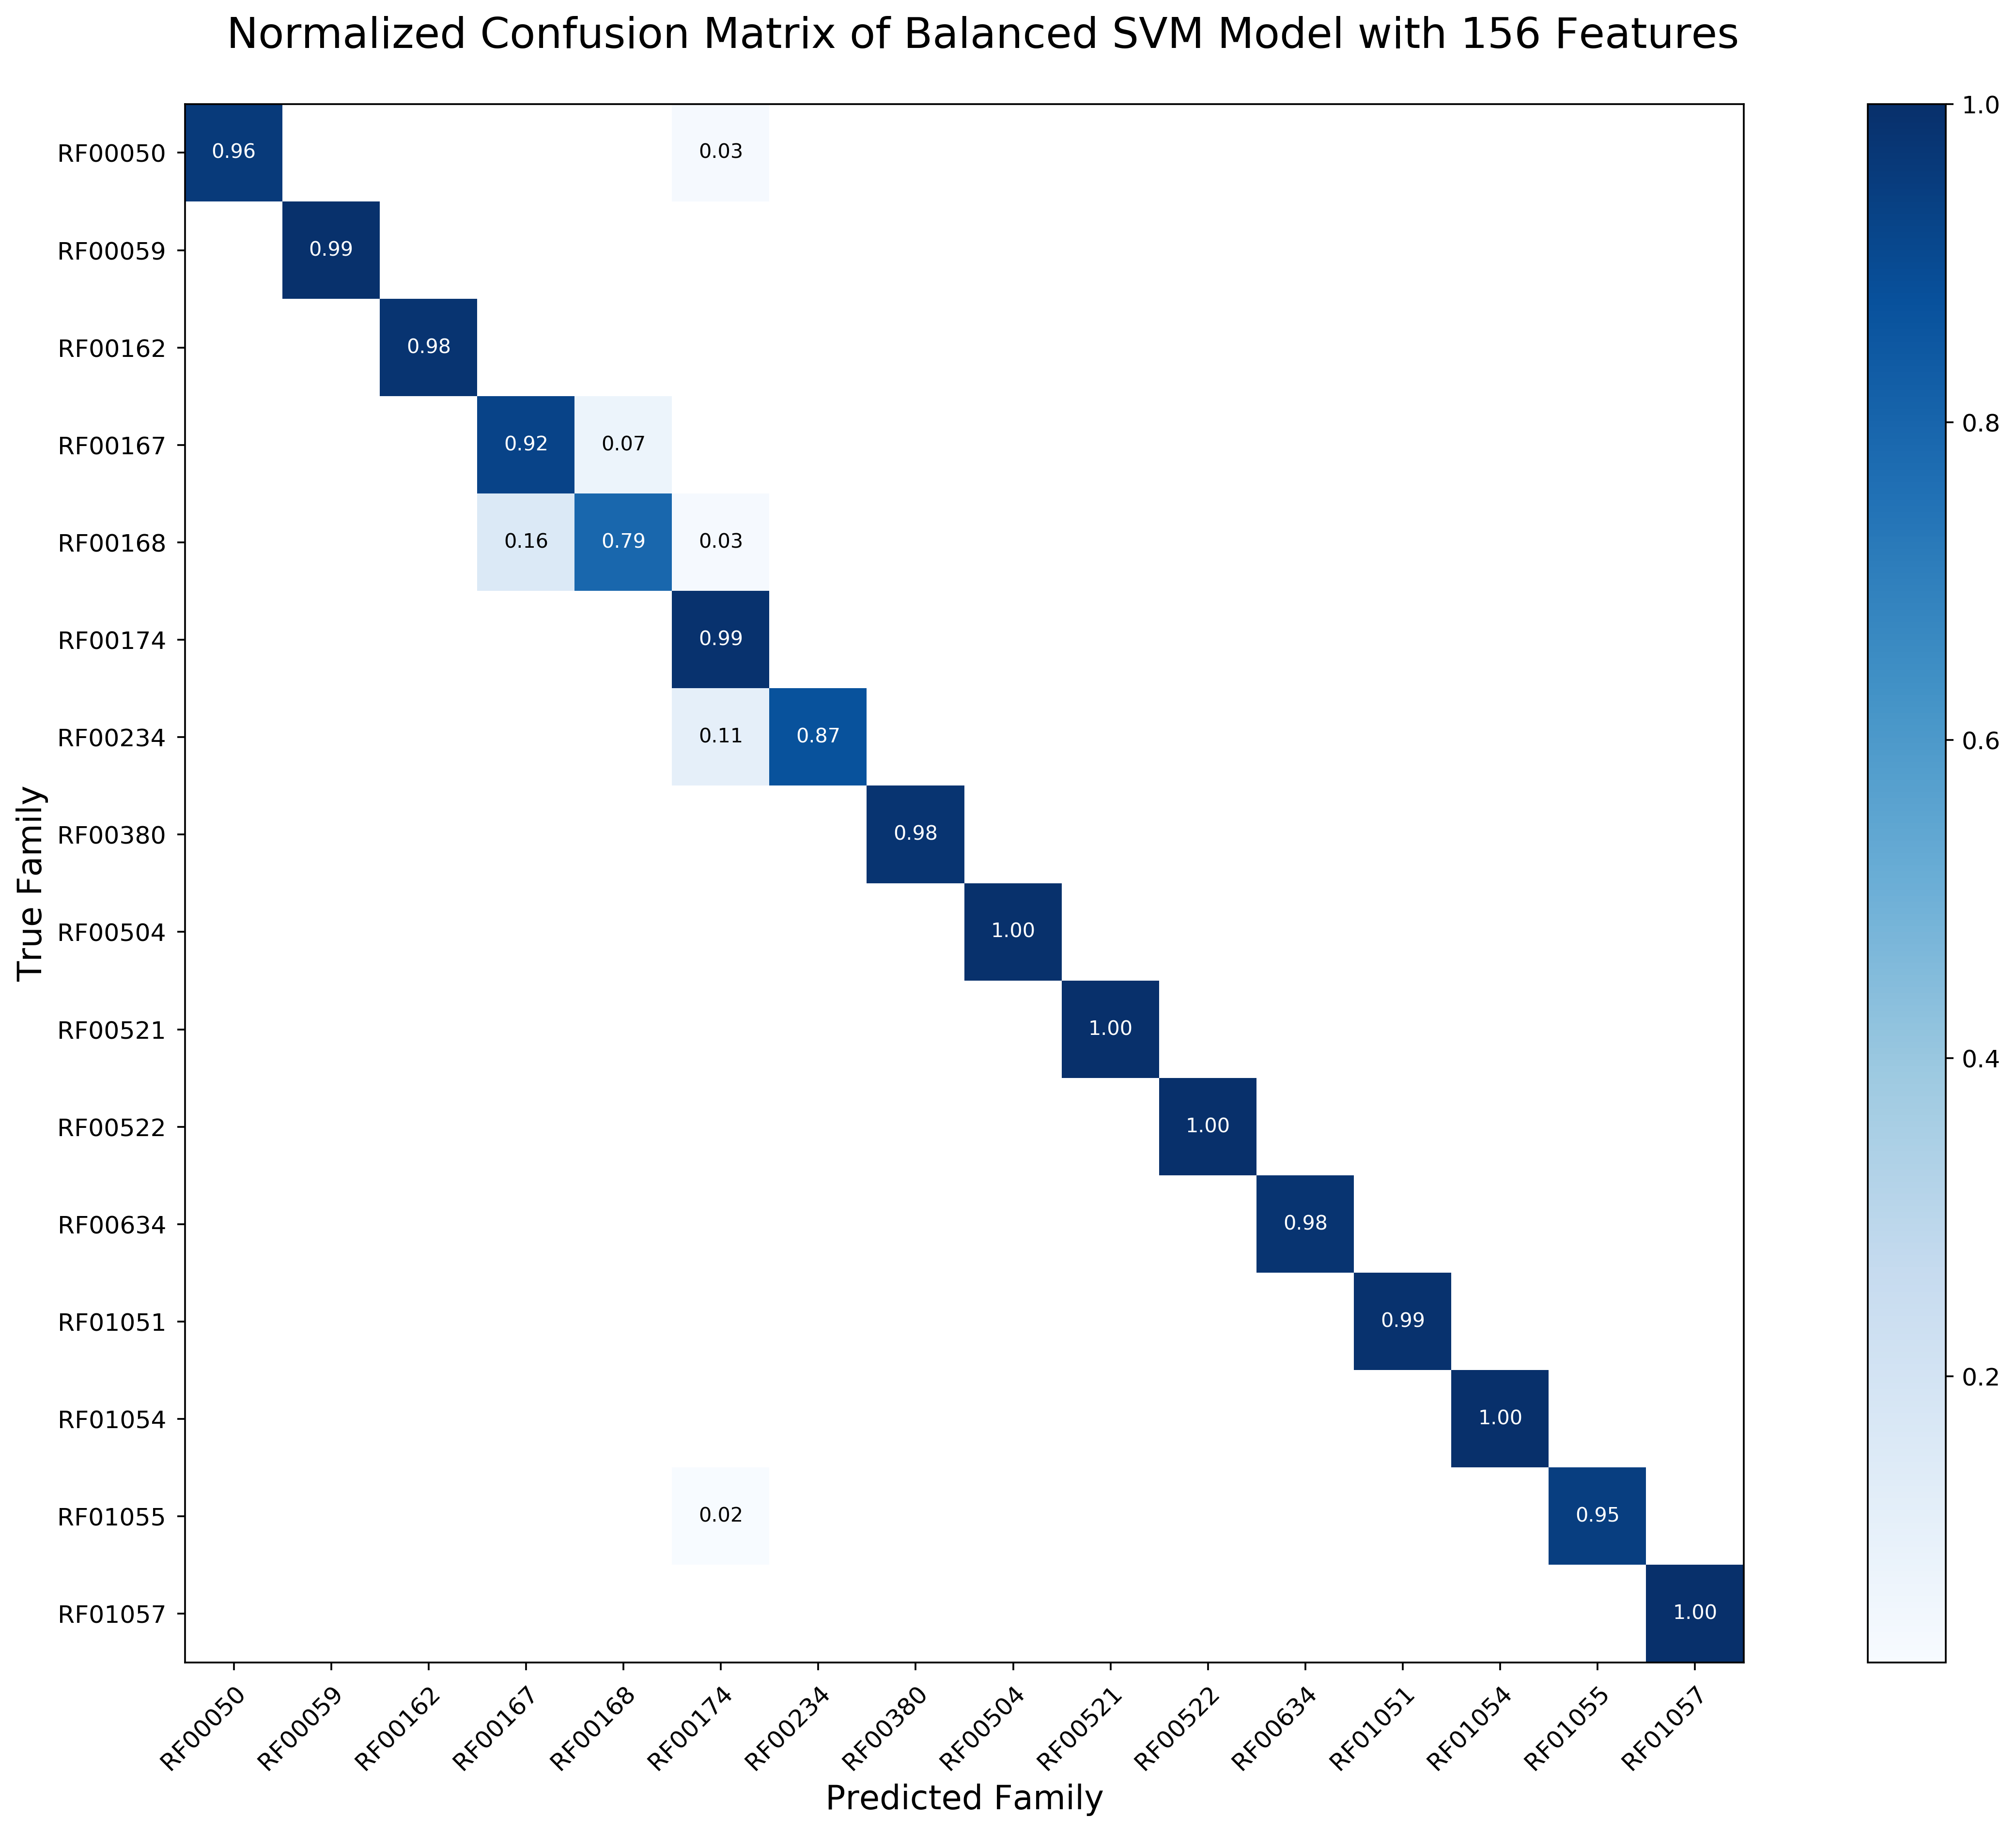

Normalized confusion matrix


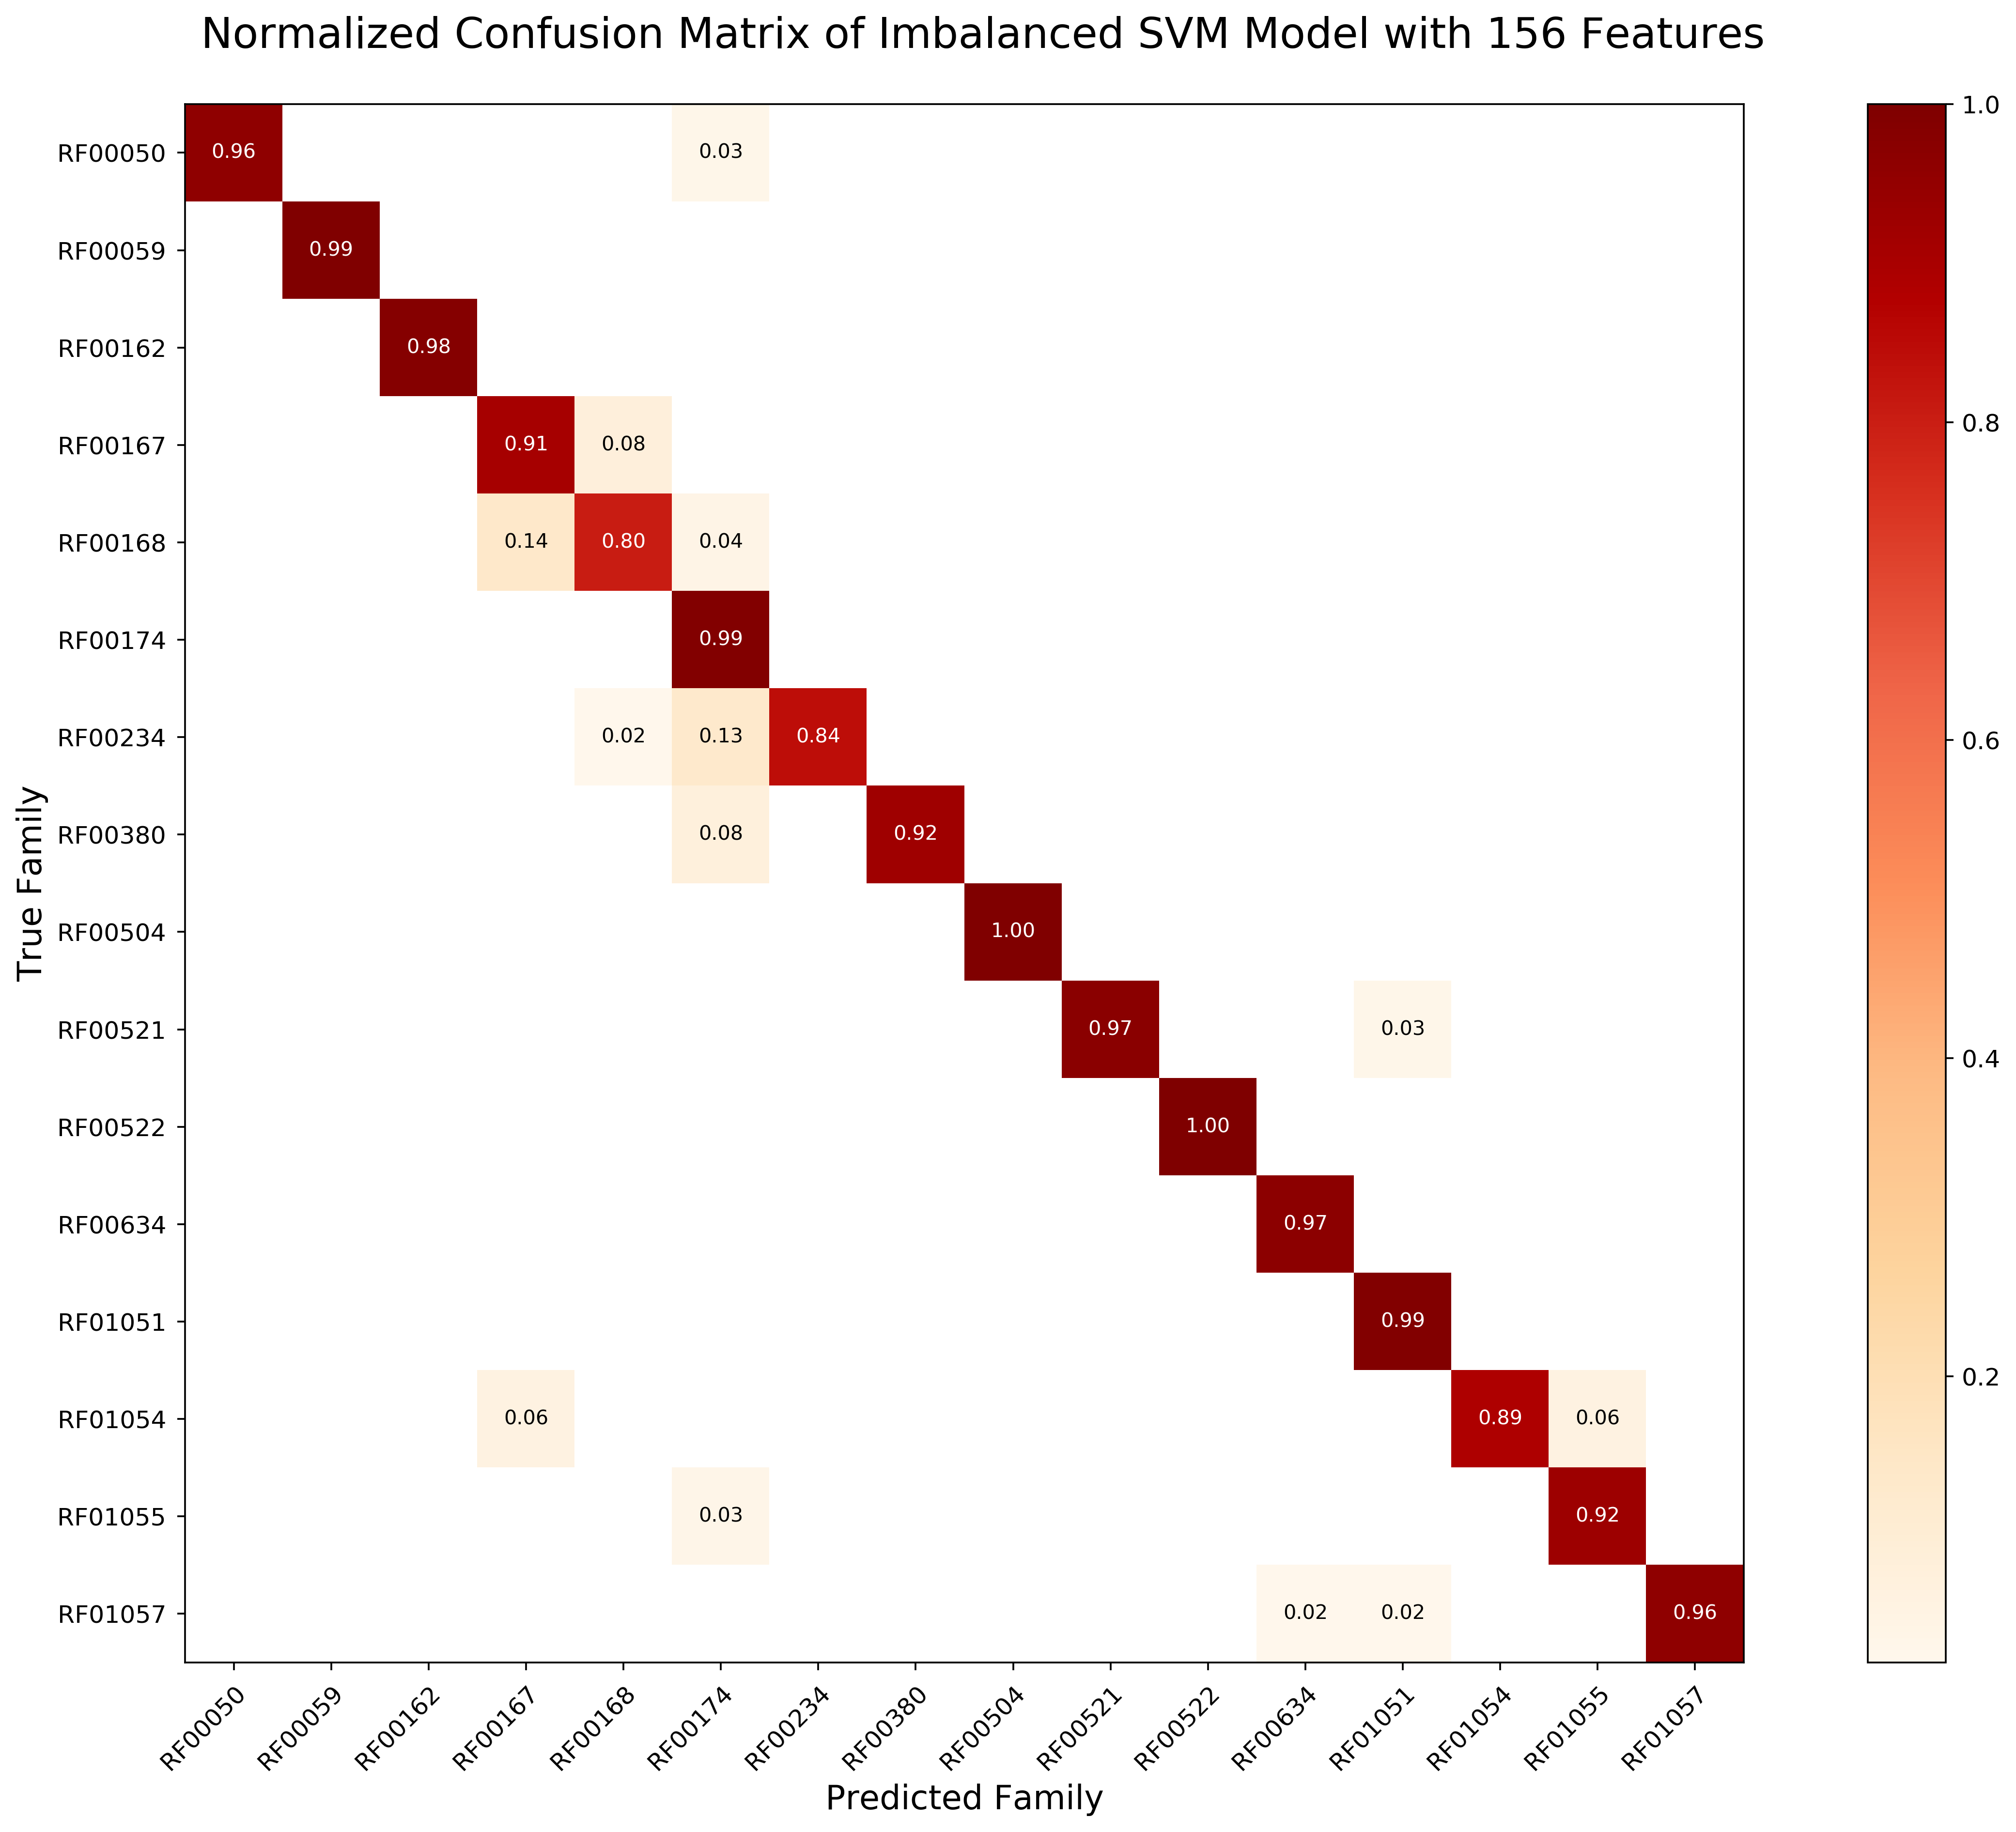

Normalized confusion matrix


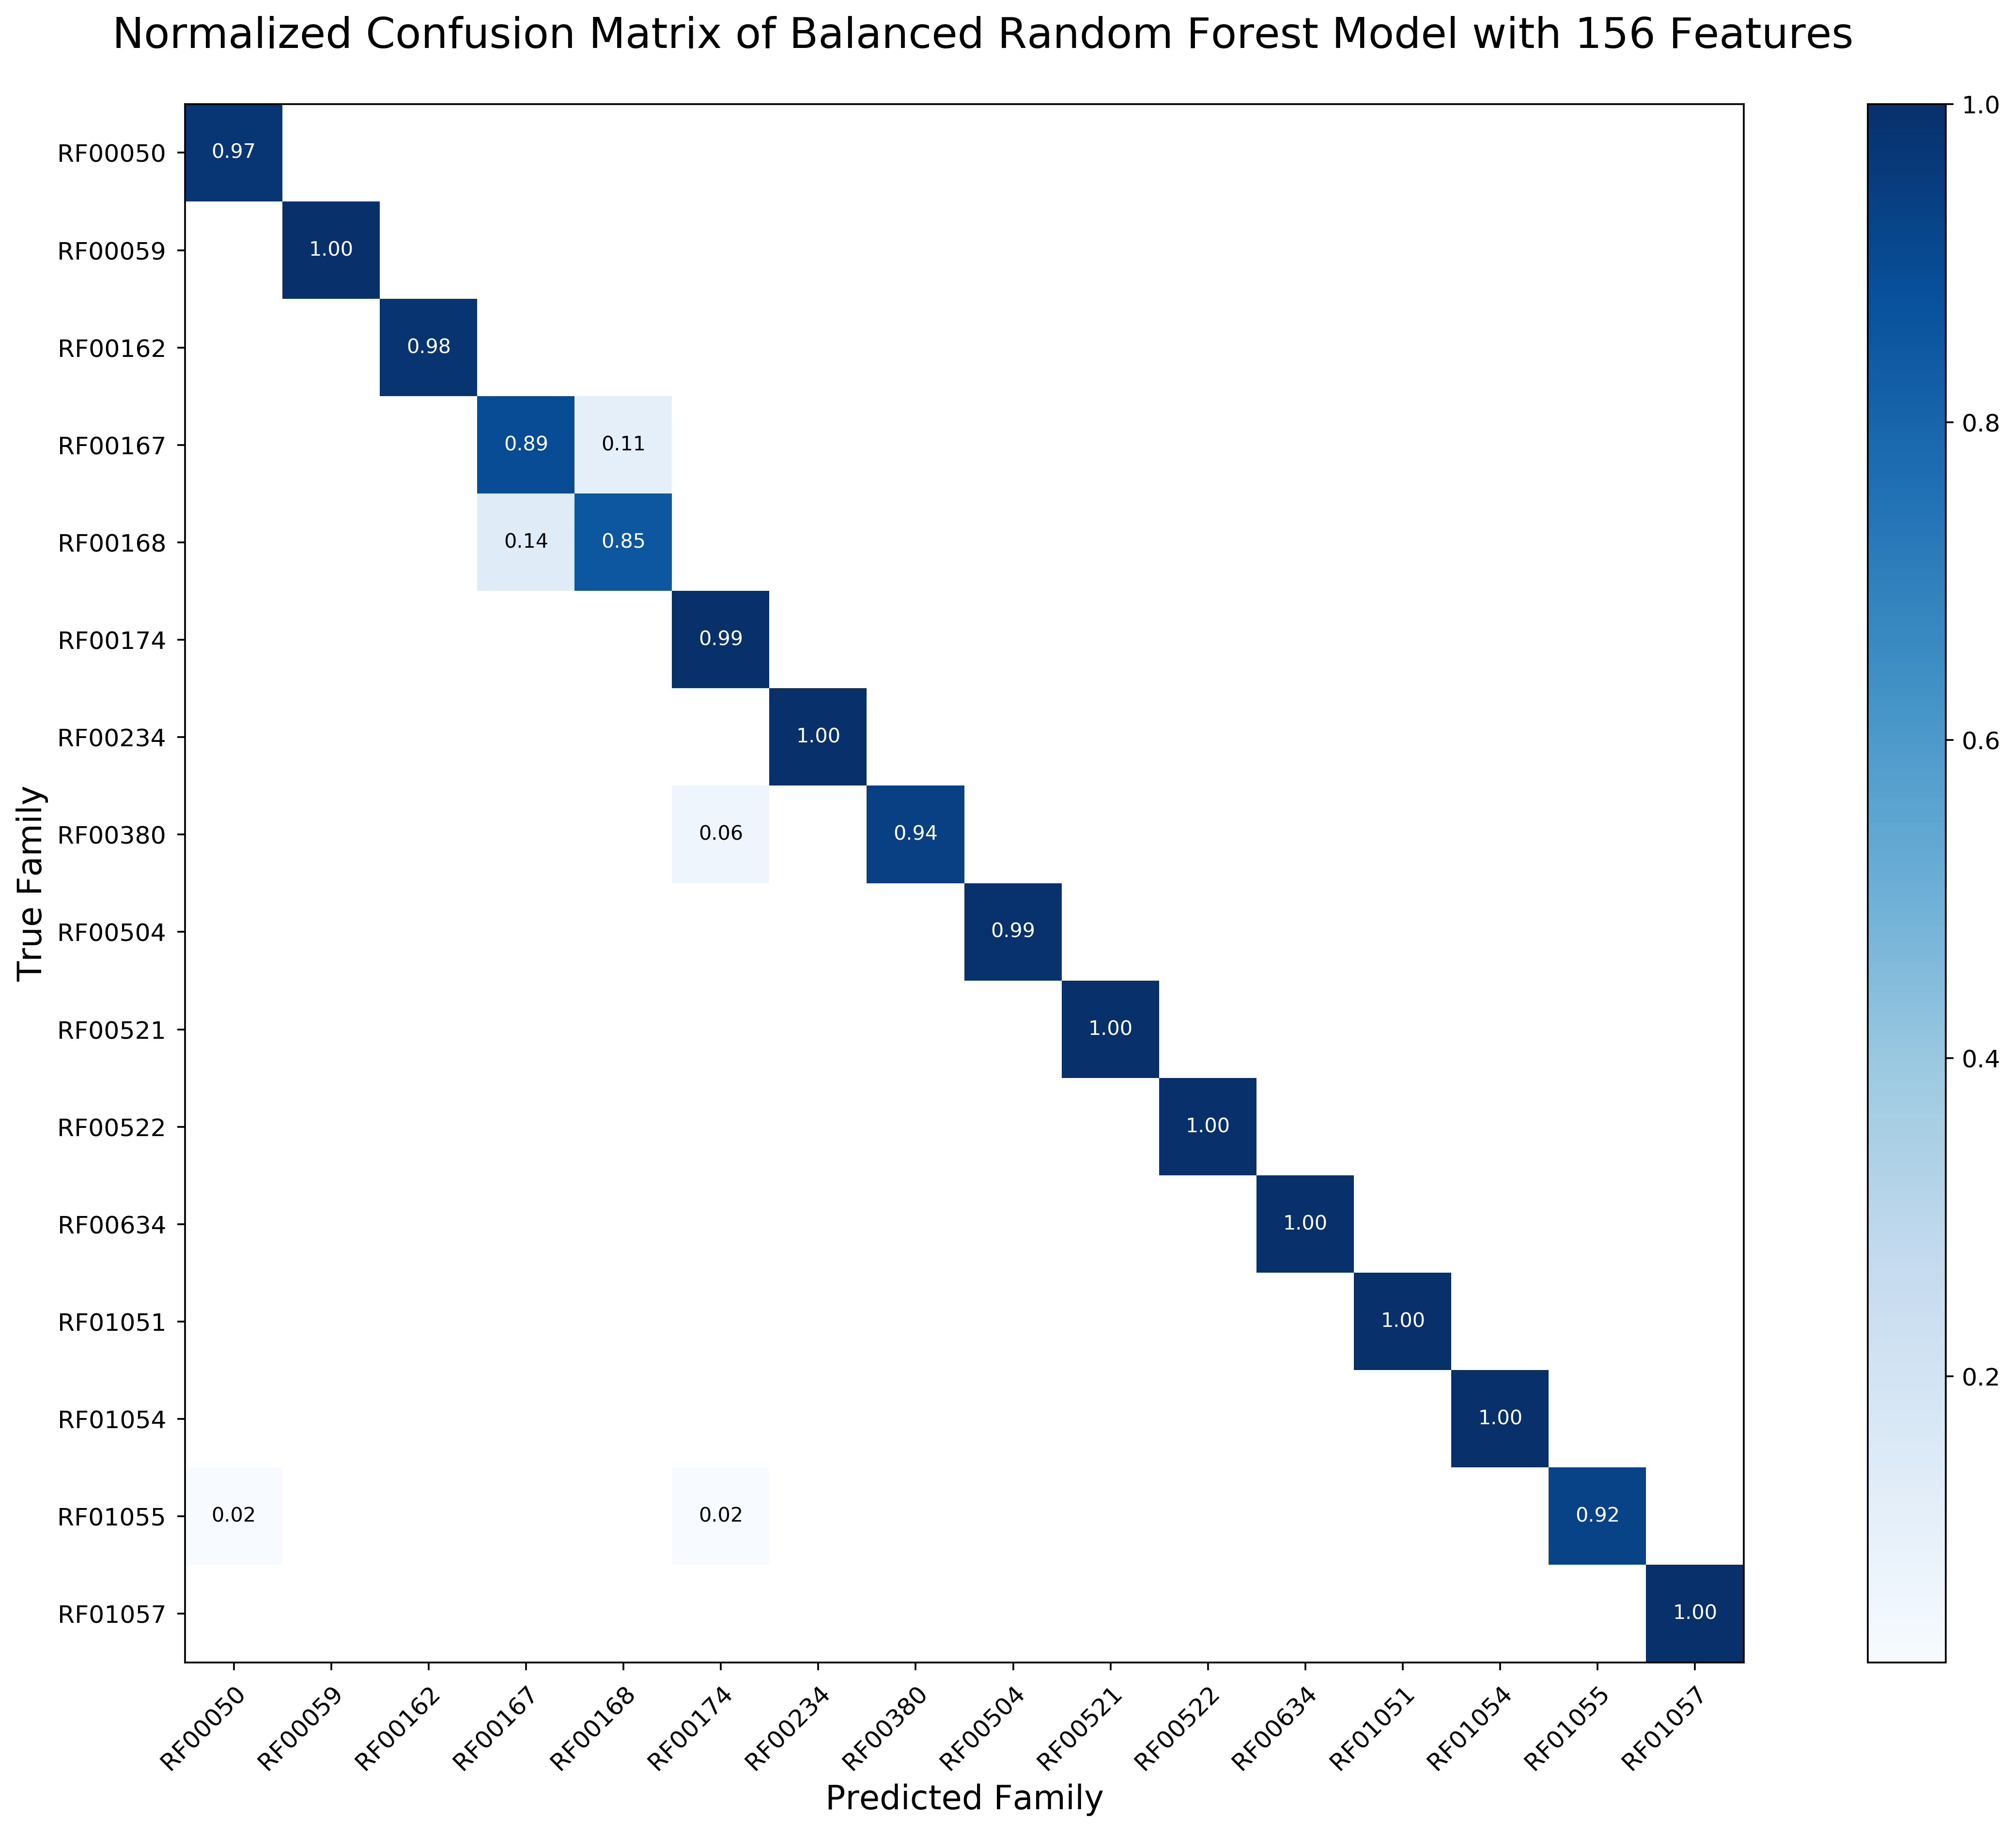

Normalized confusion matrix


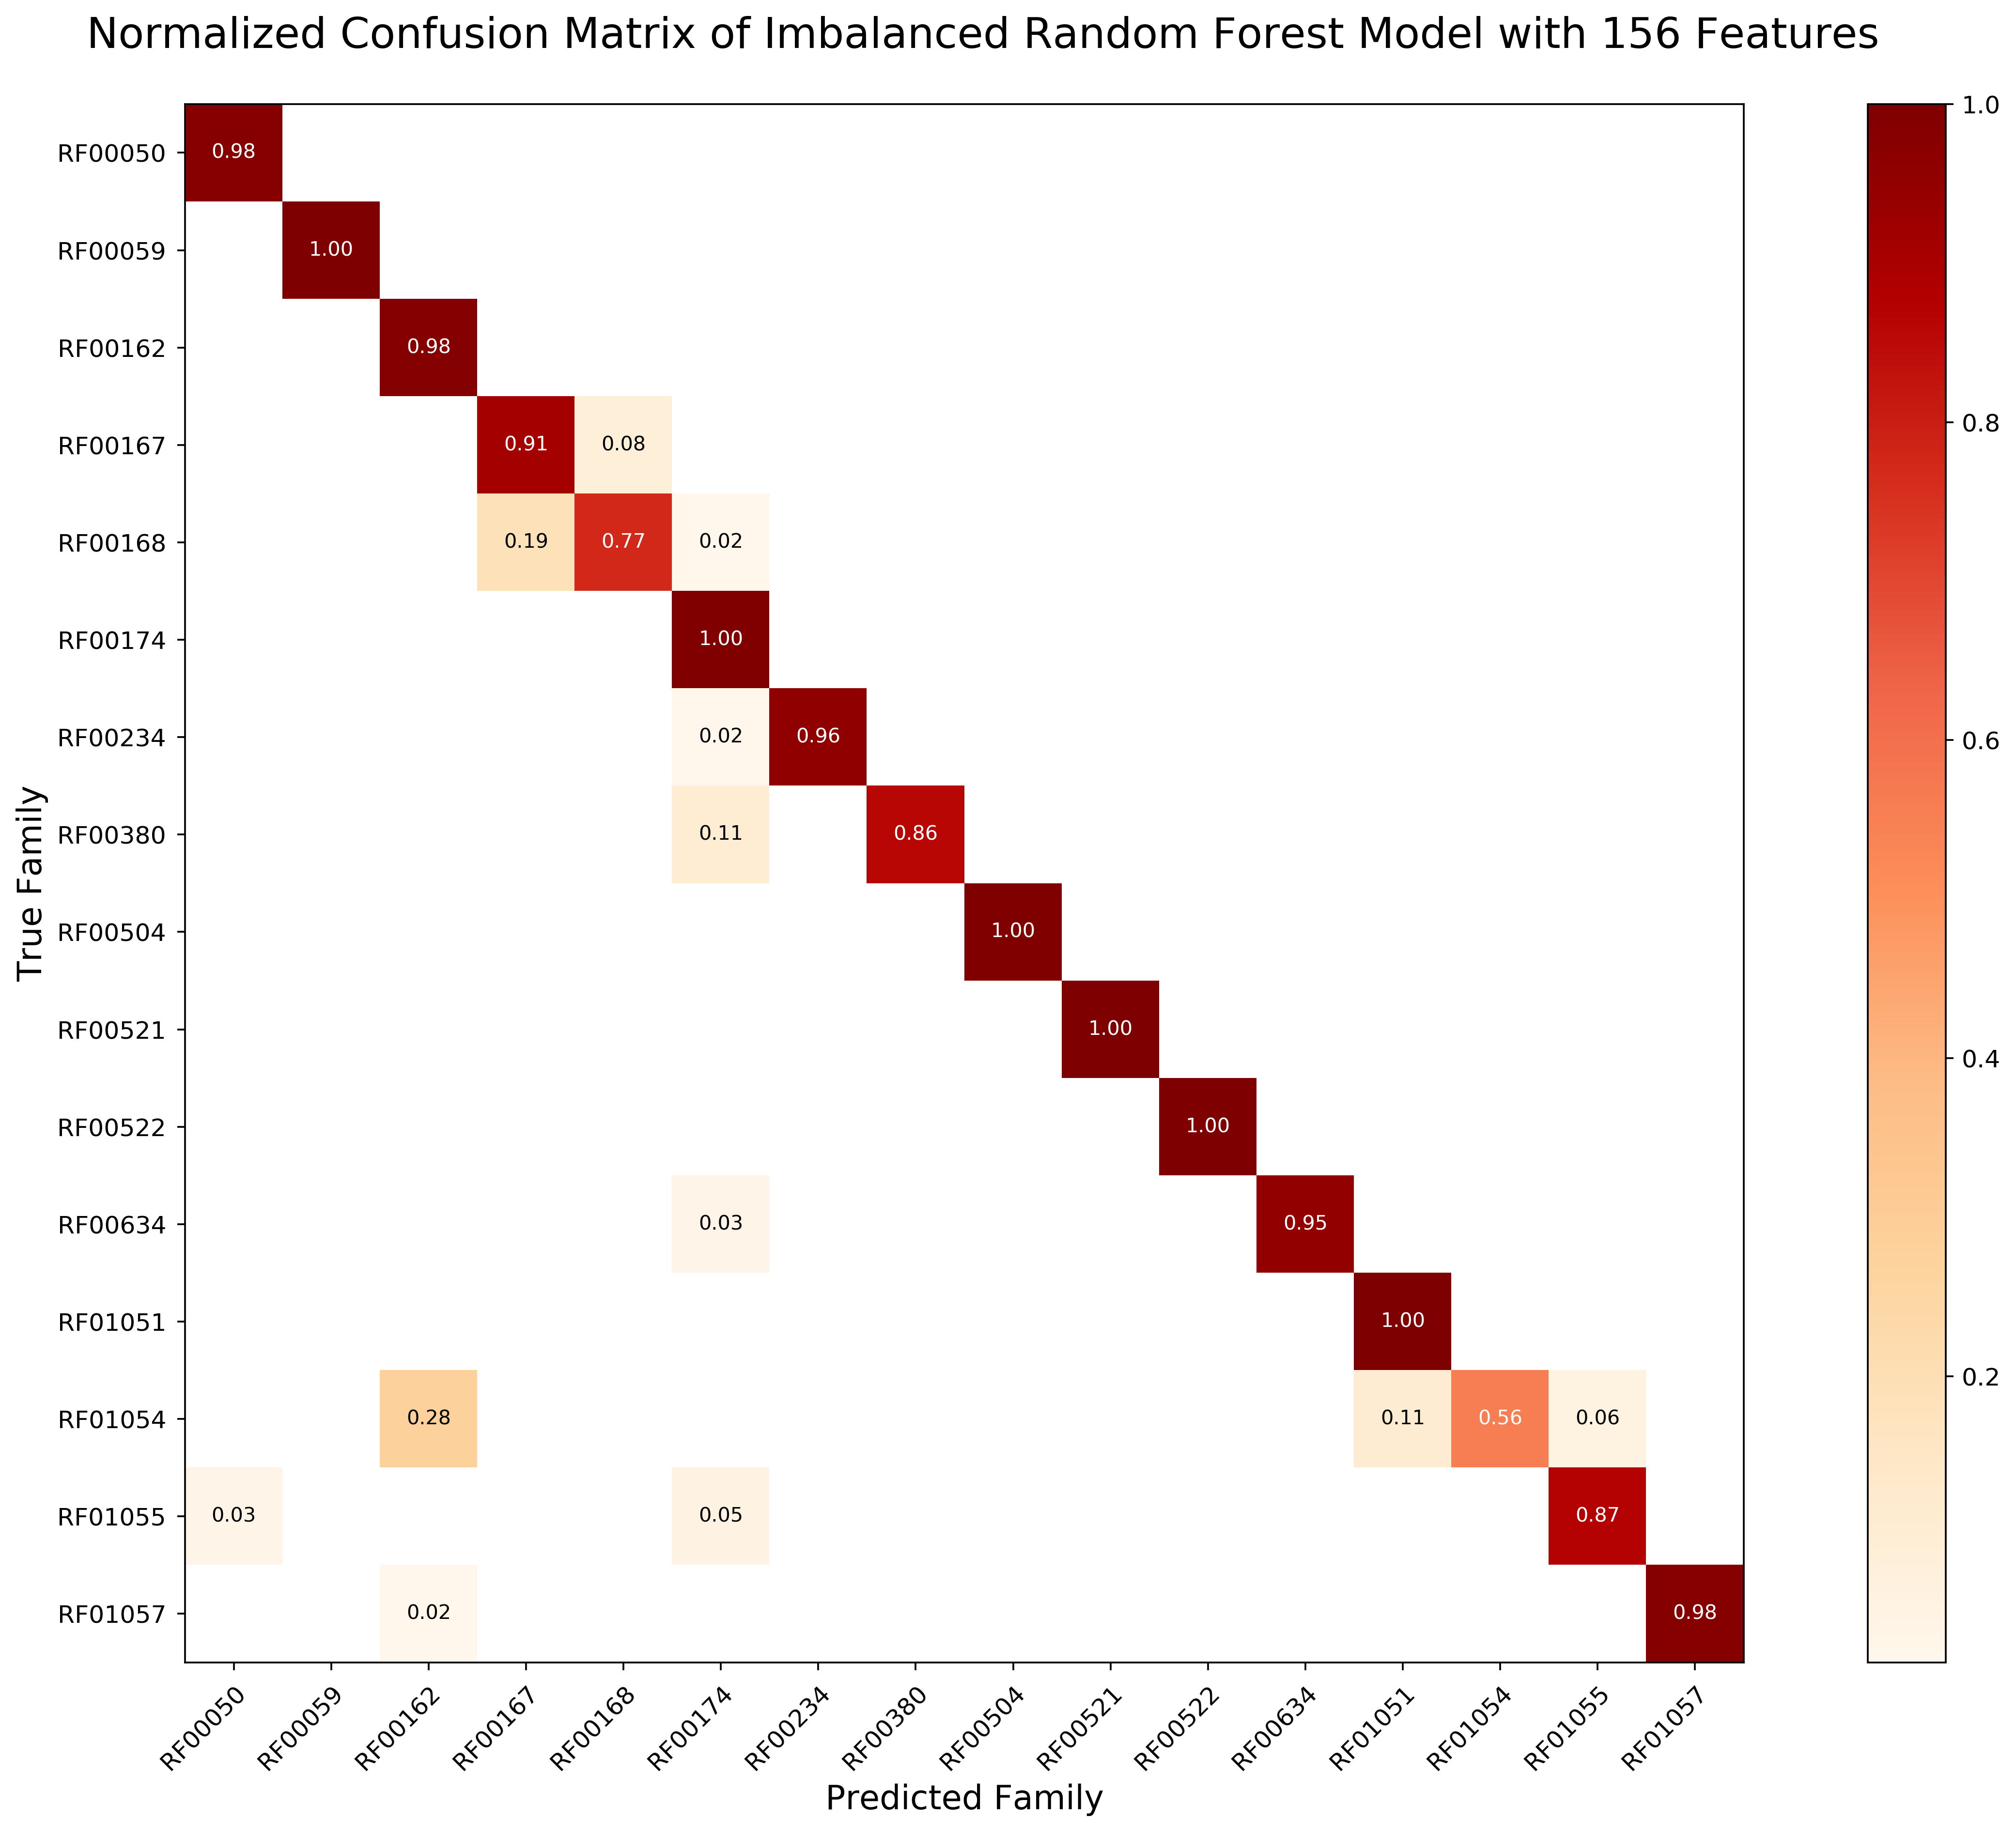

Normalized confusion matrix


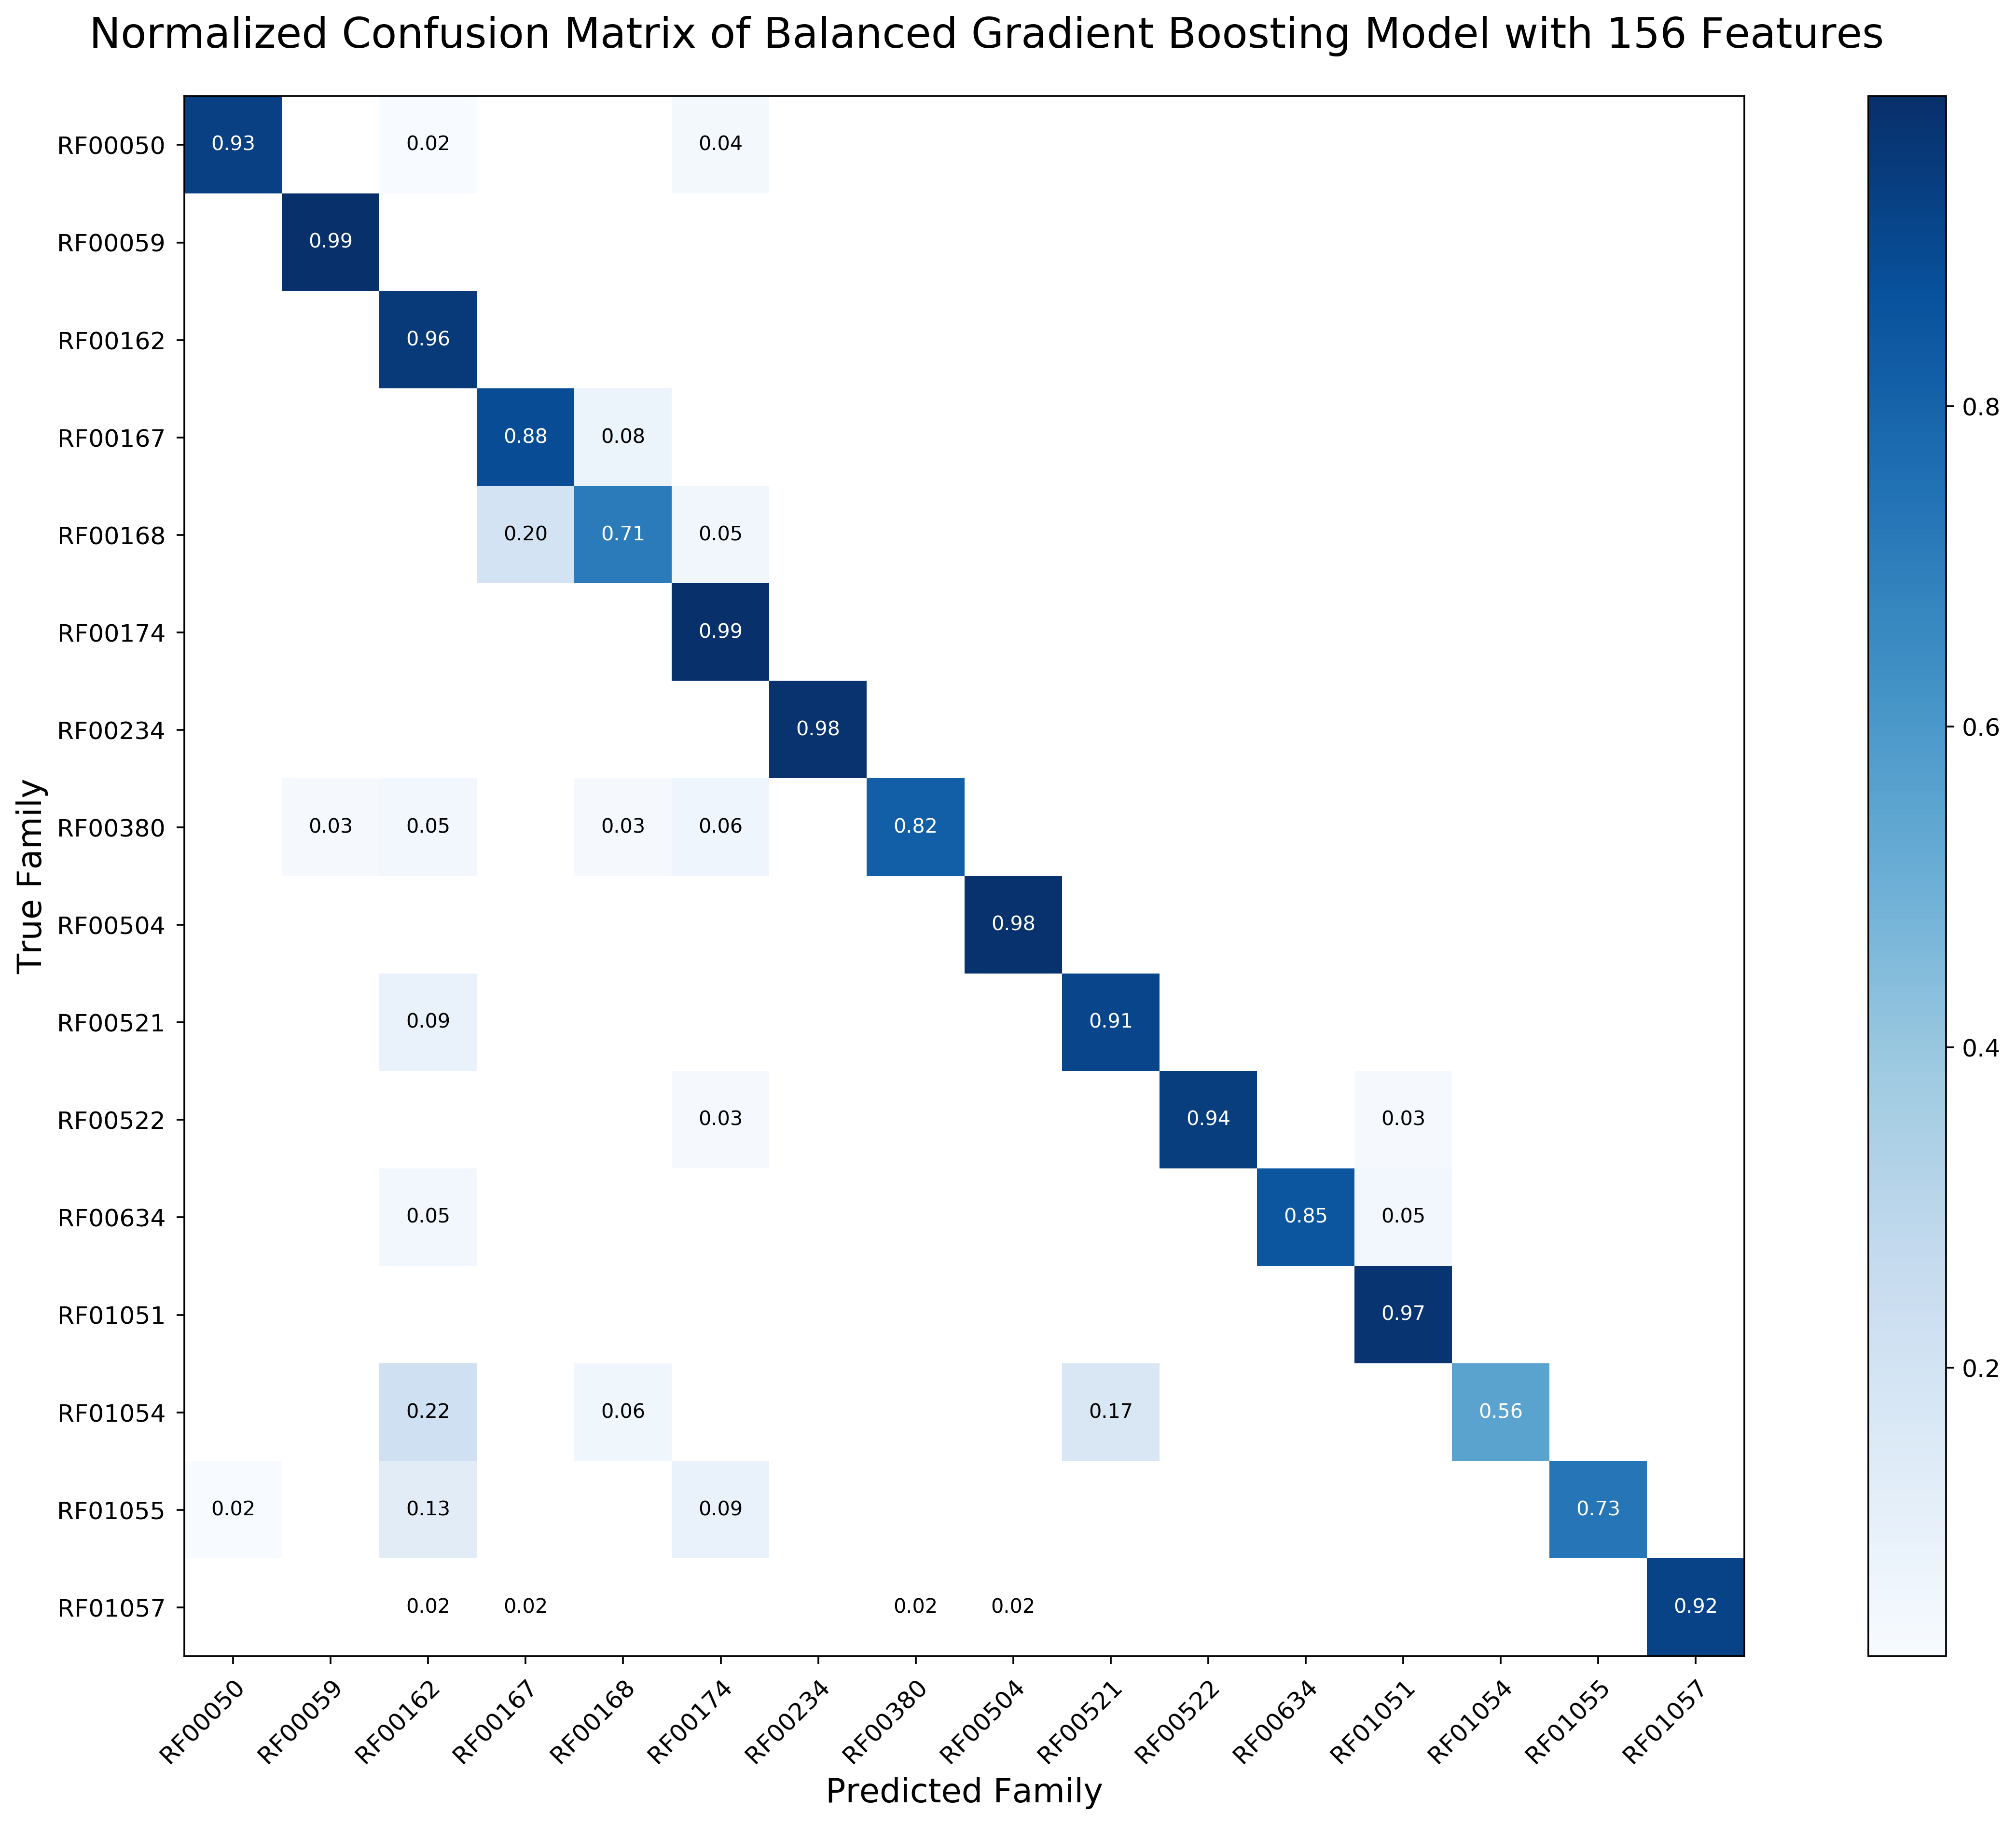

Normalized confusion matrix


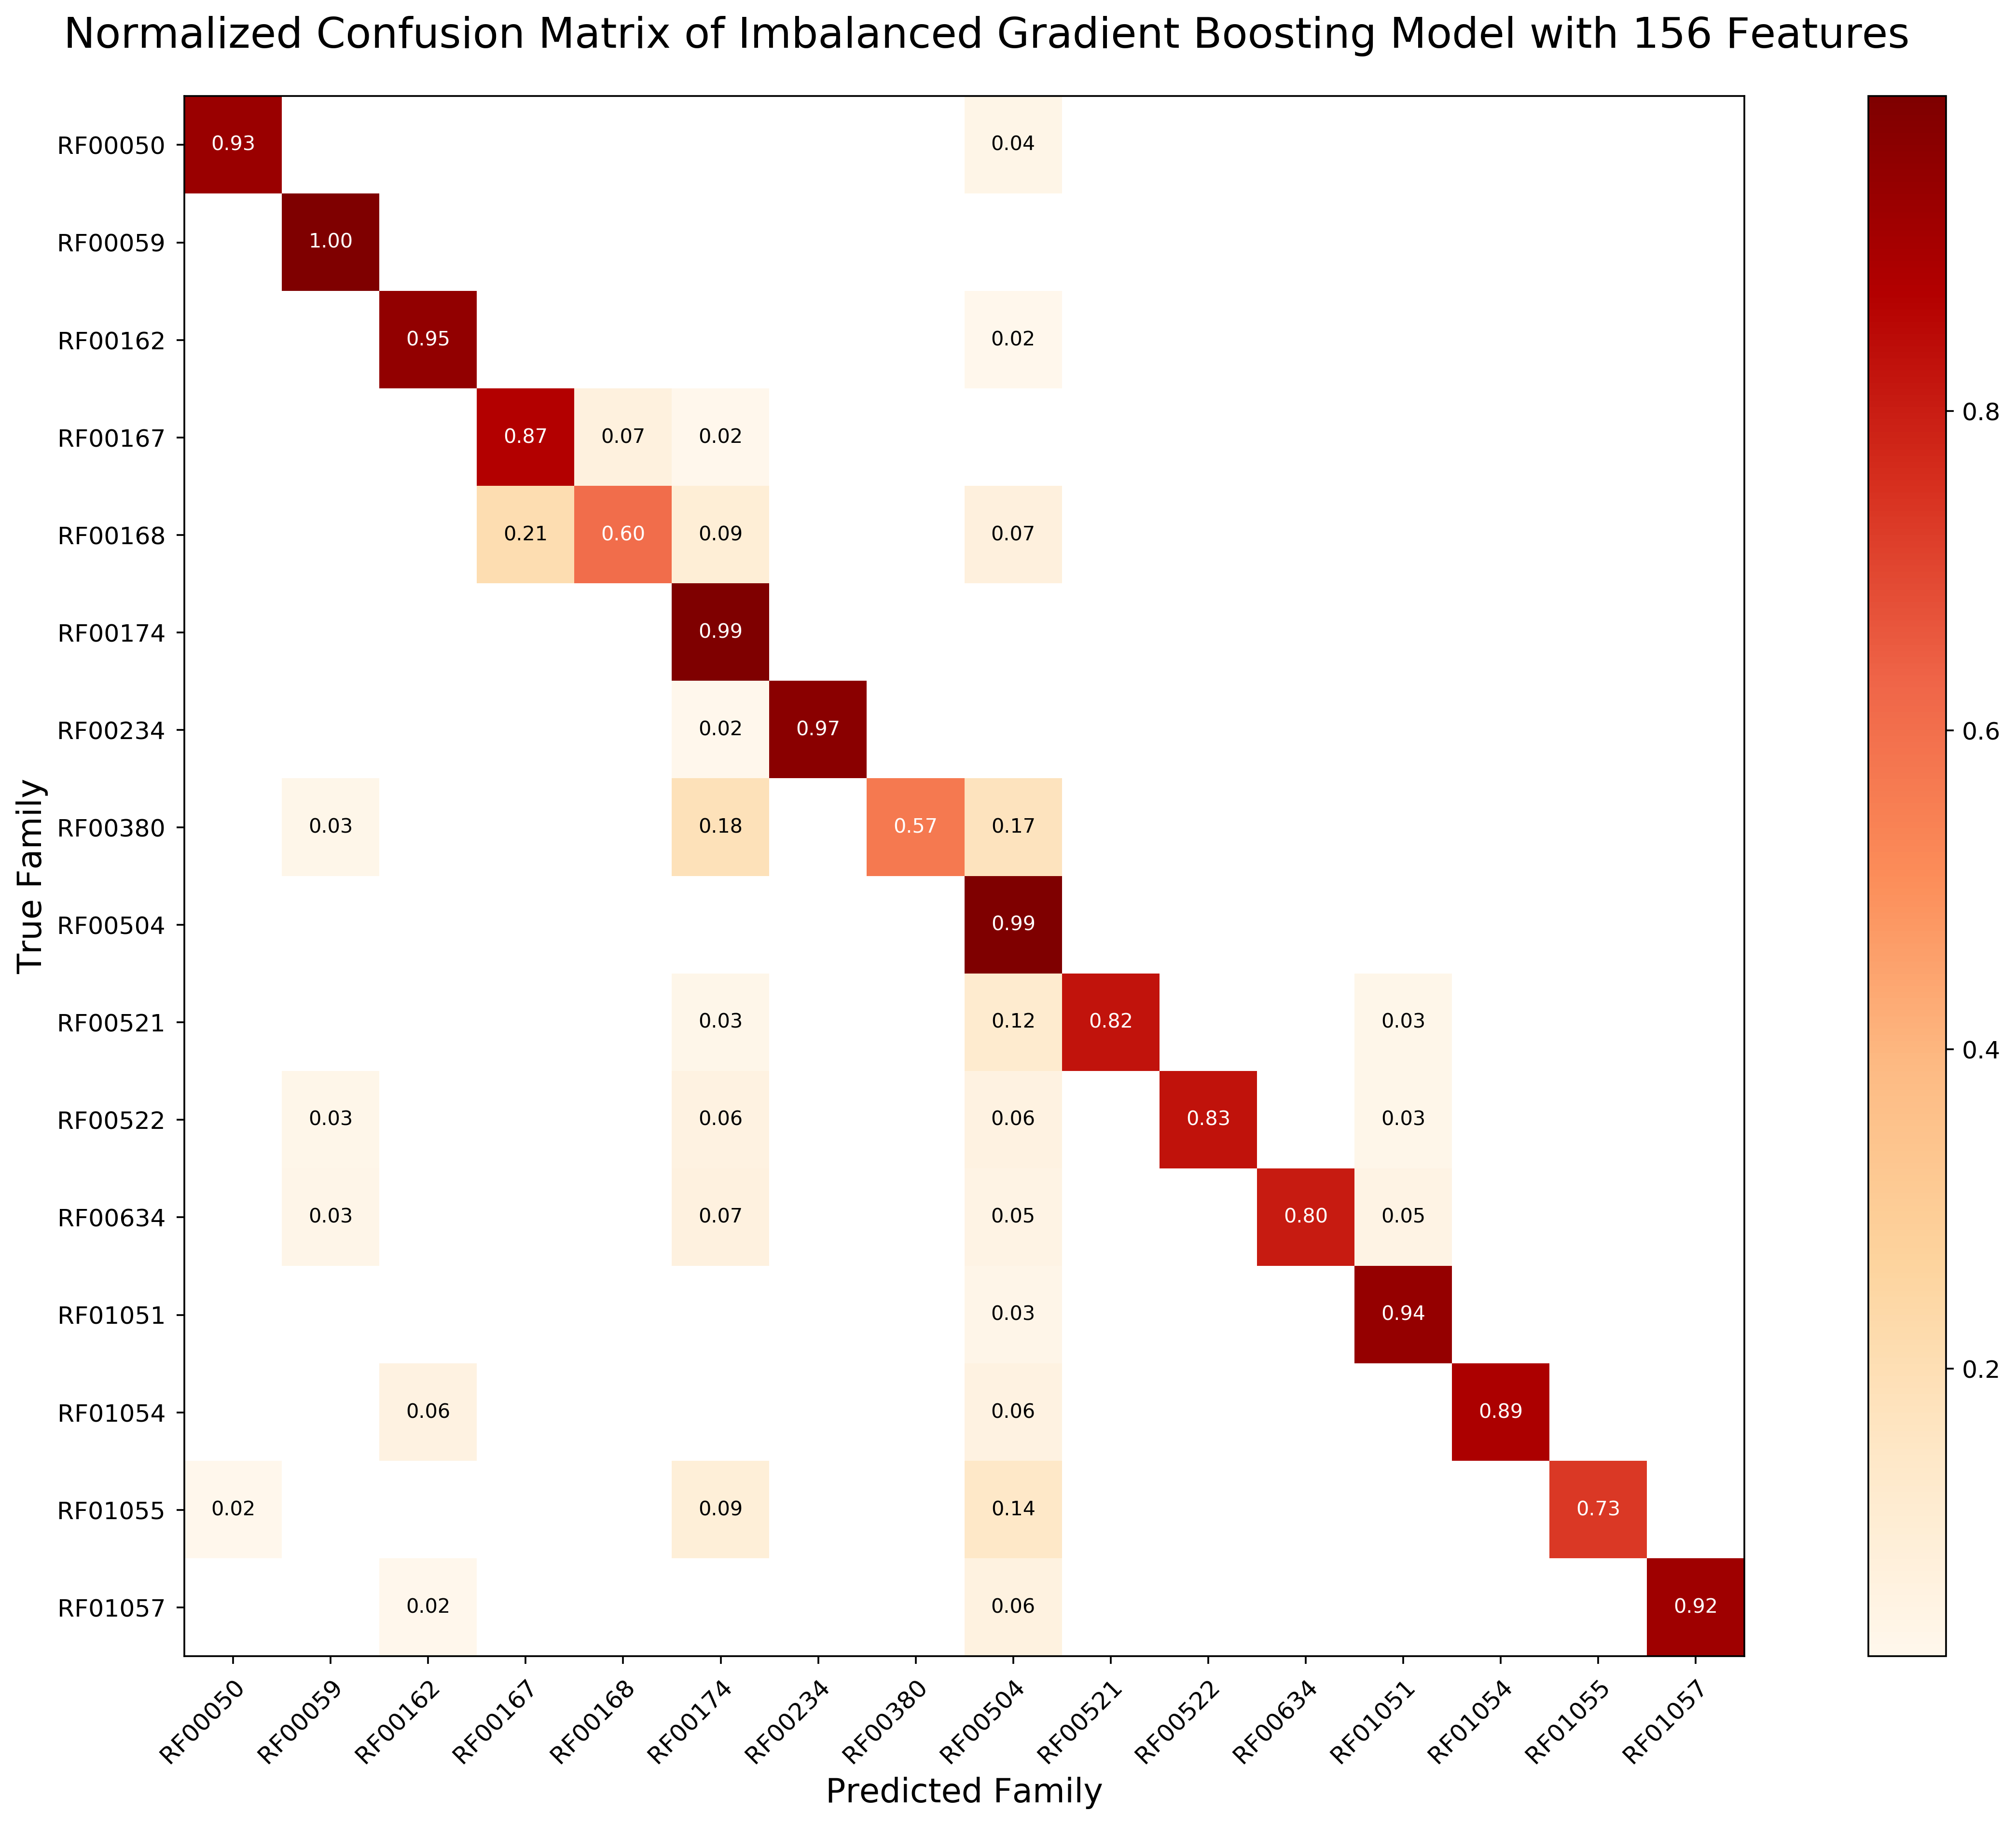

Normalized confusion matrix


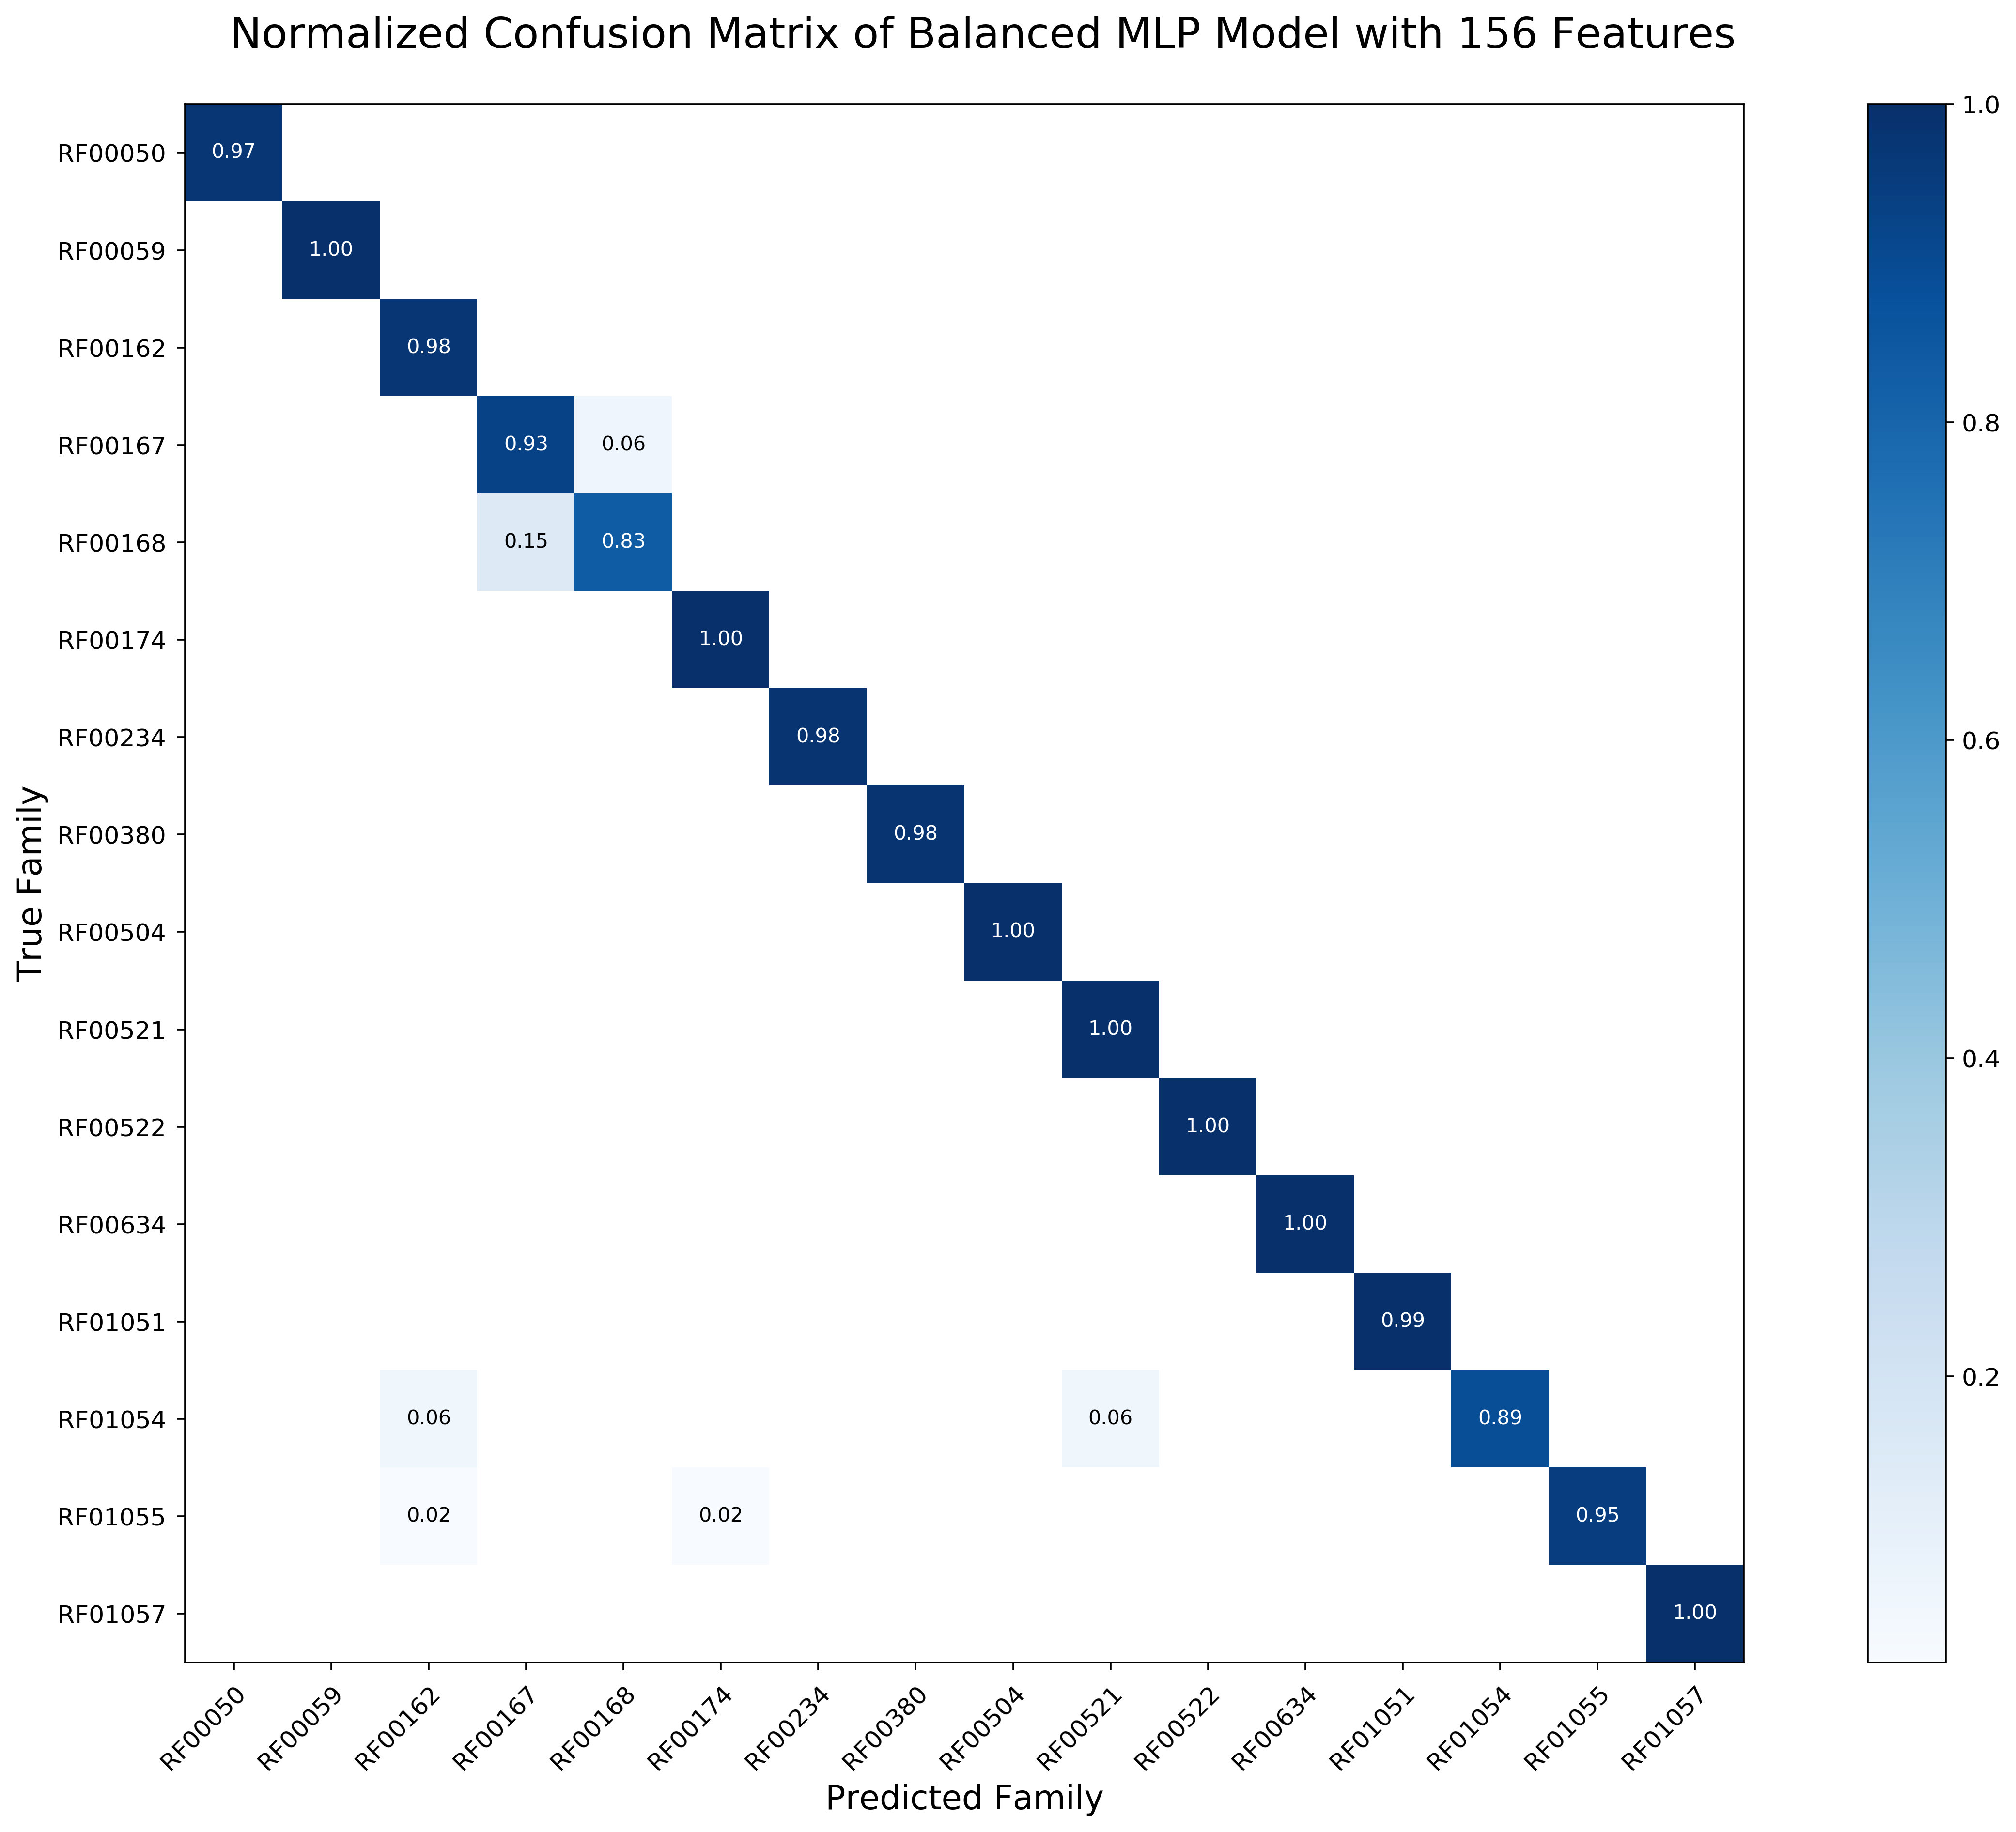

Normalized confusion matrix


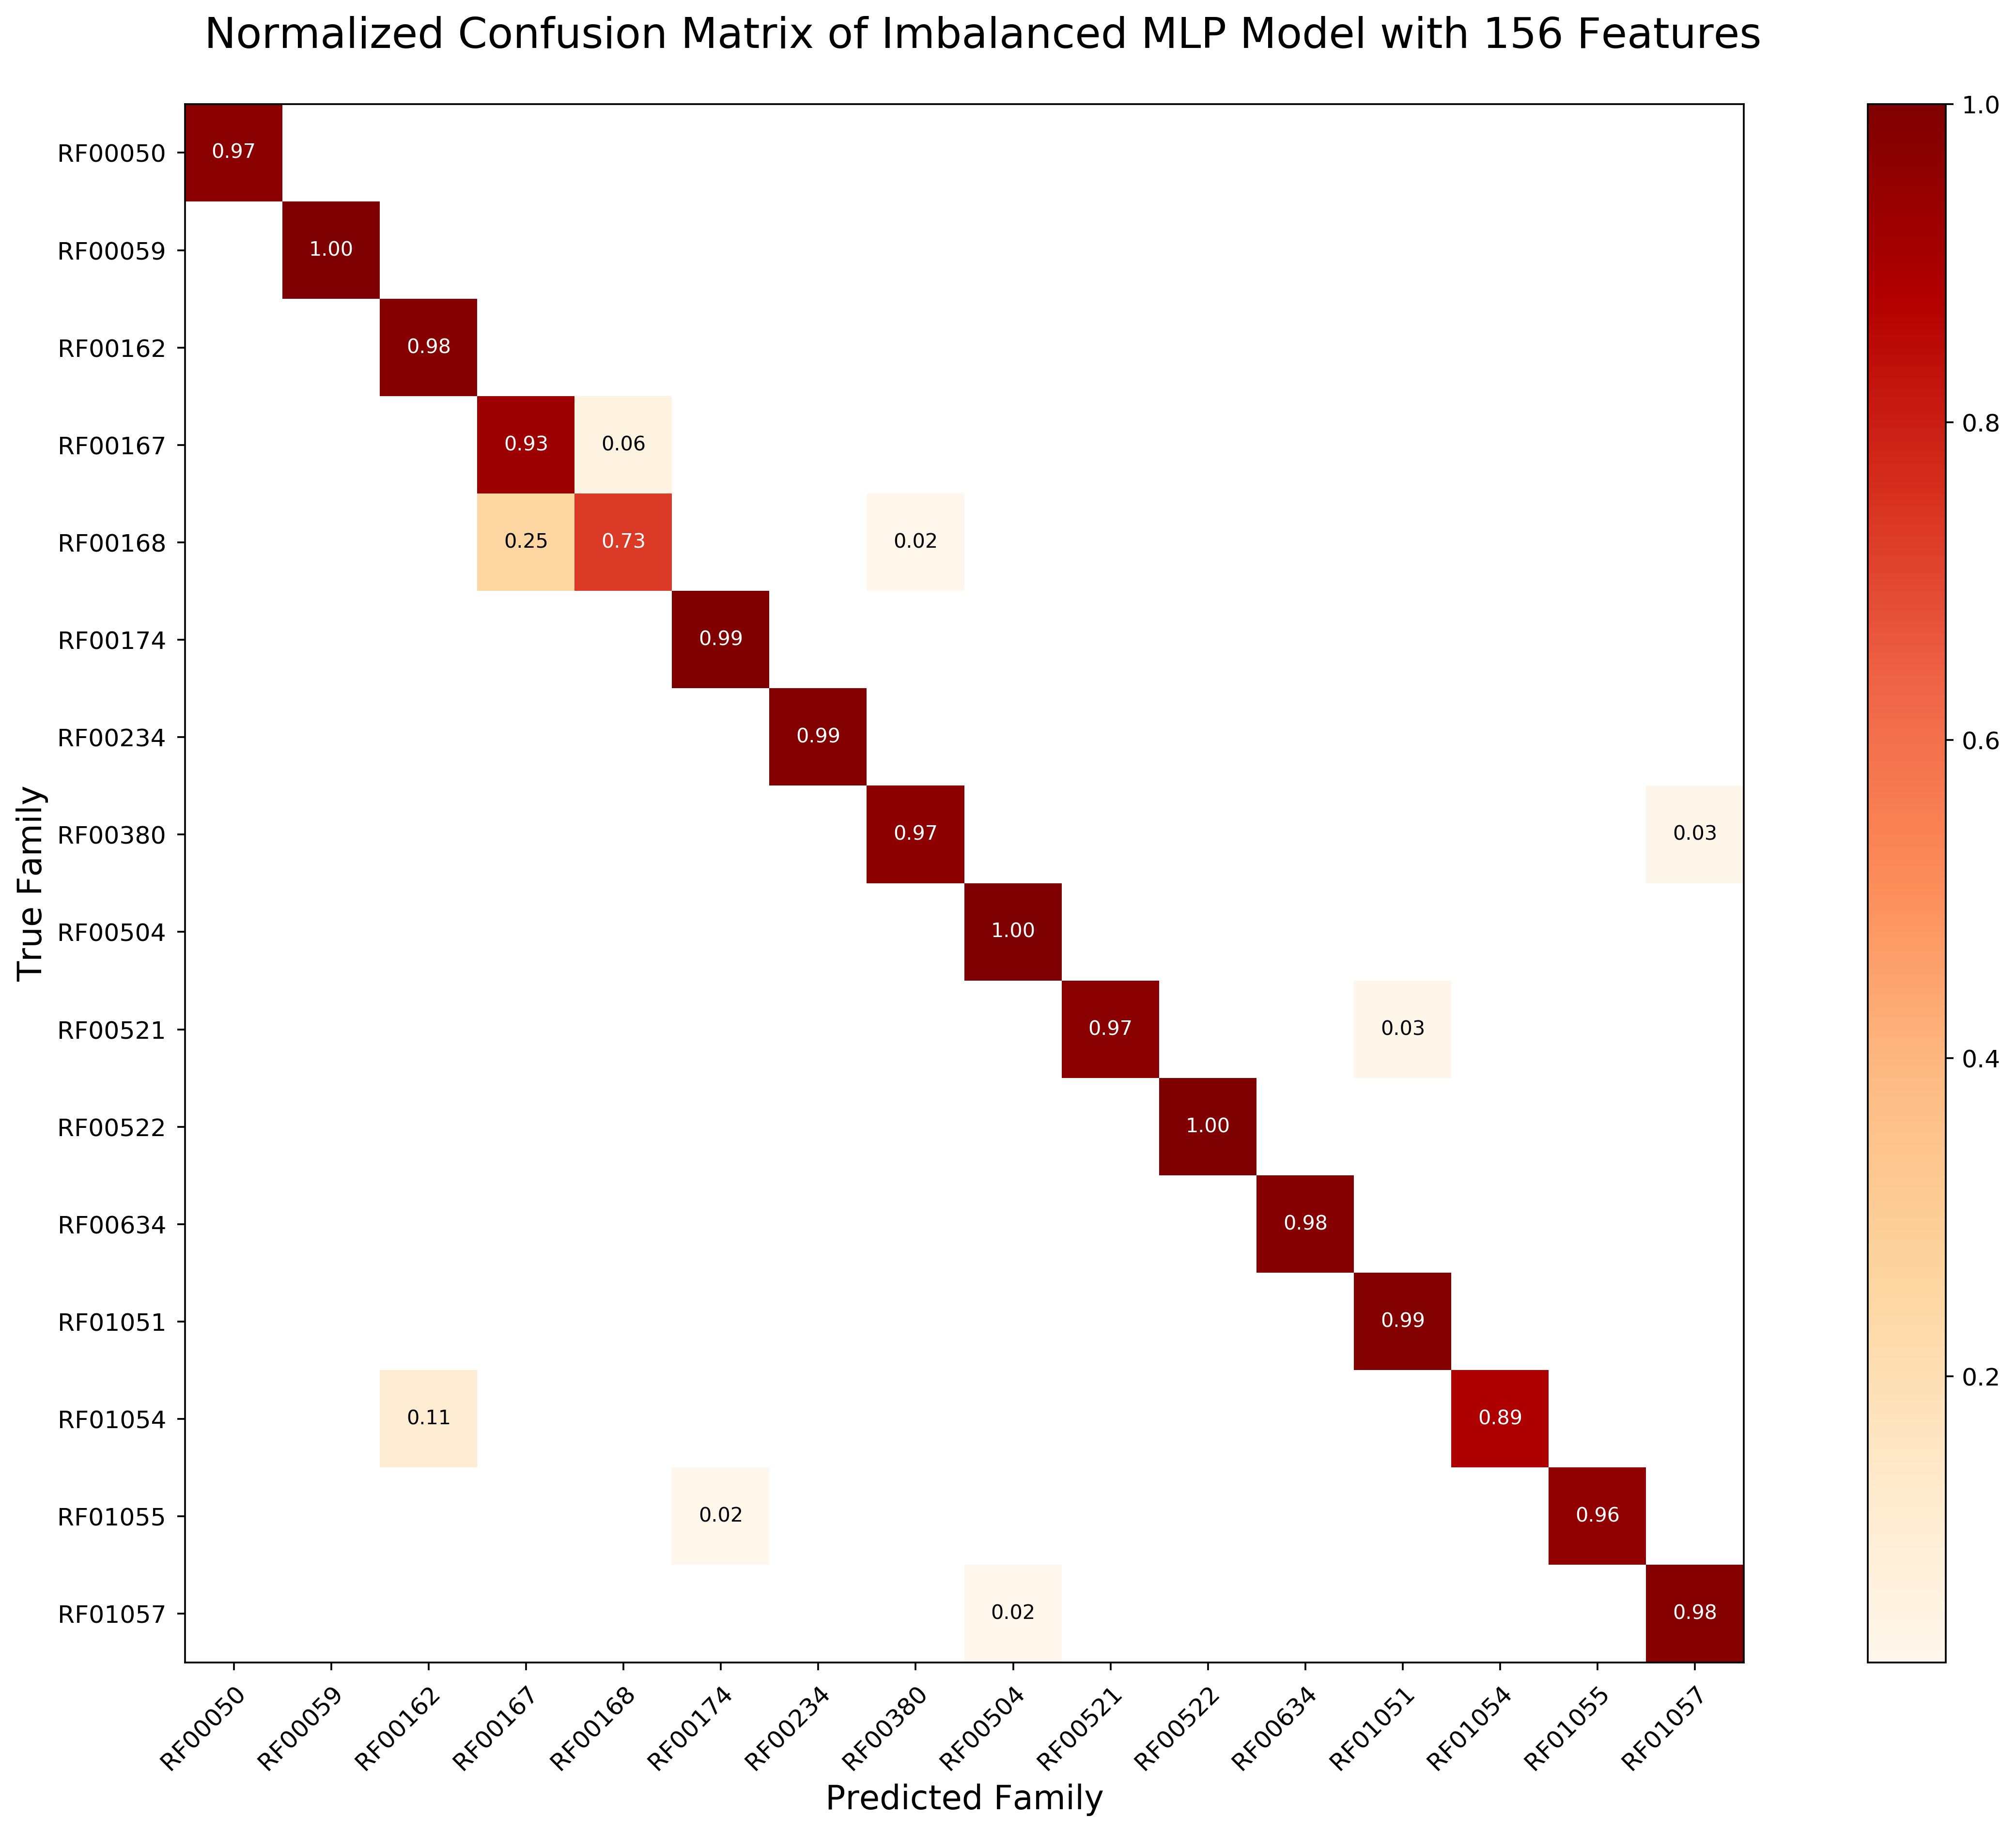

Normalized confusion matrix


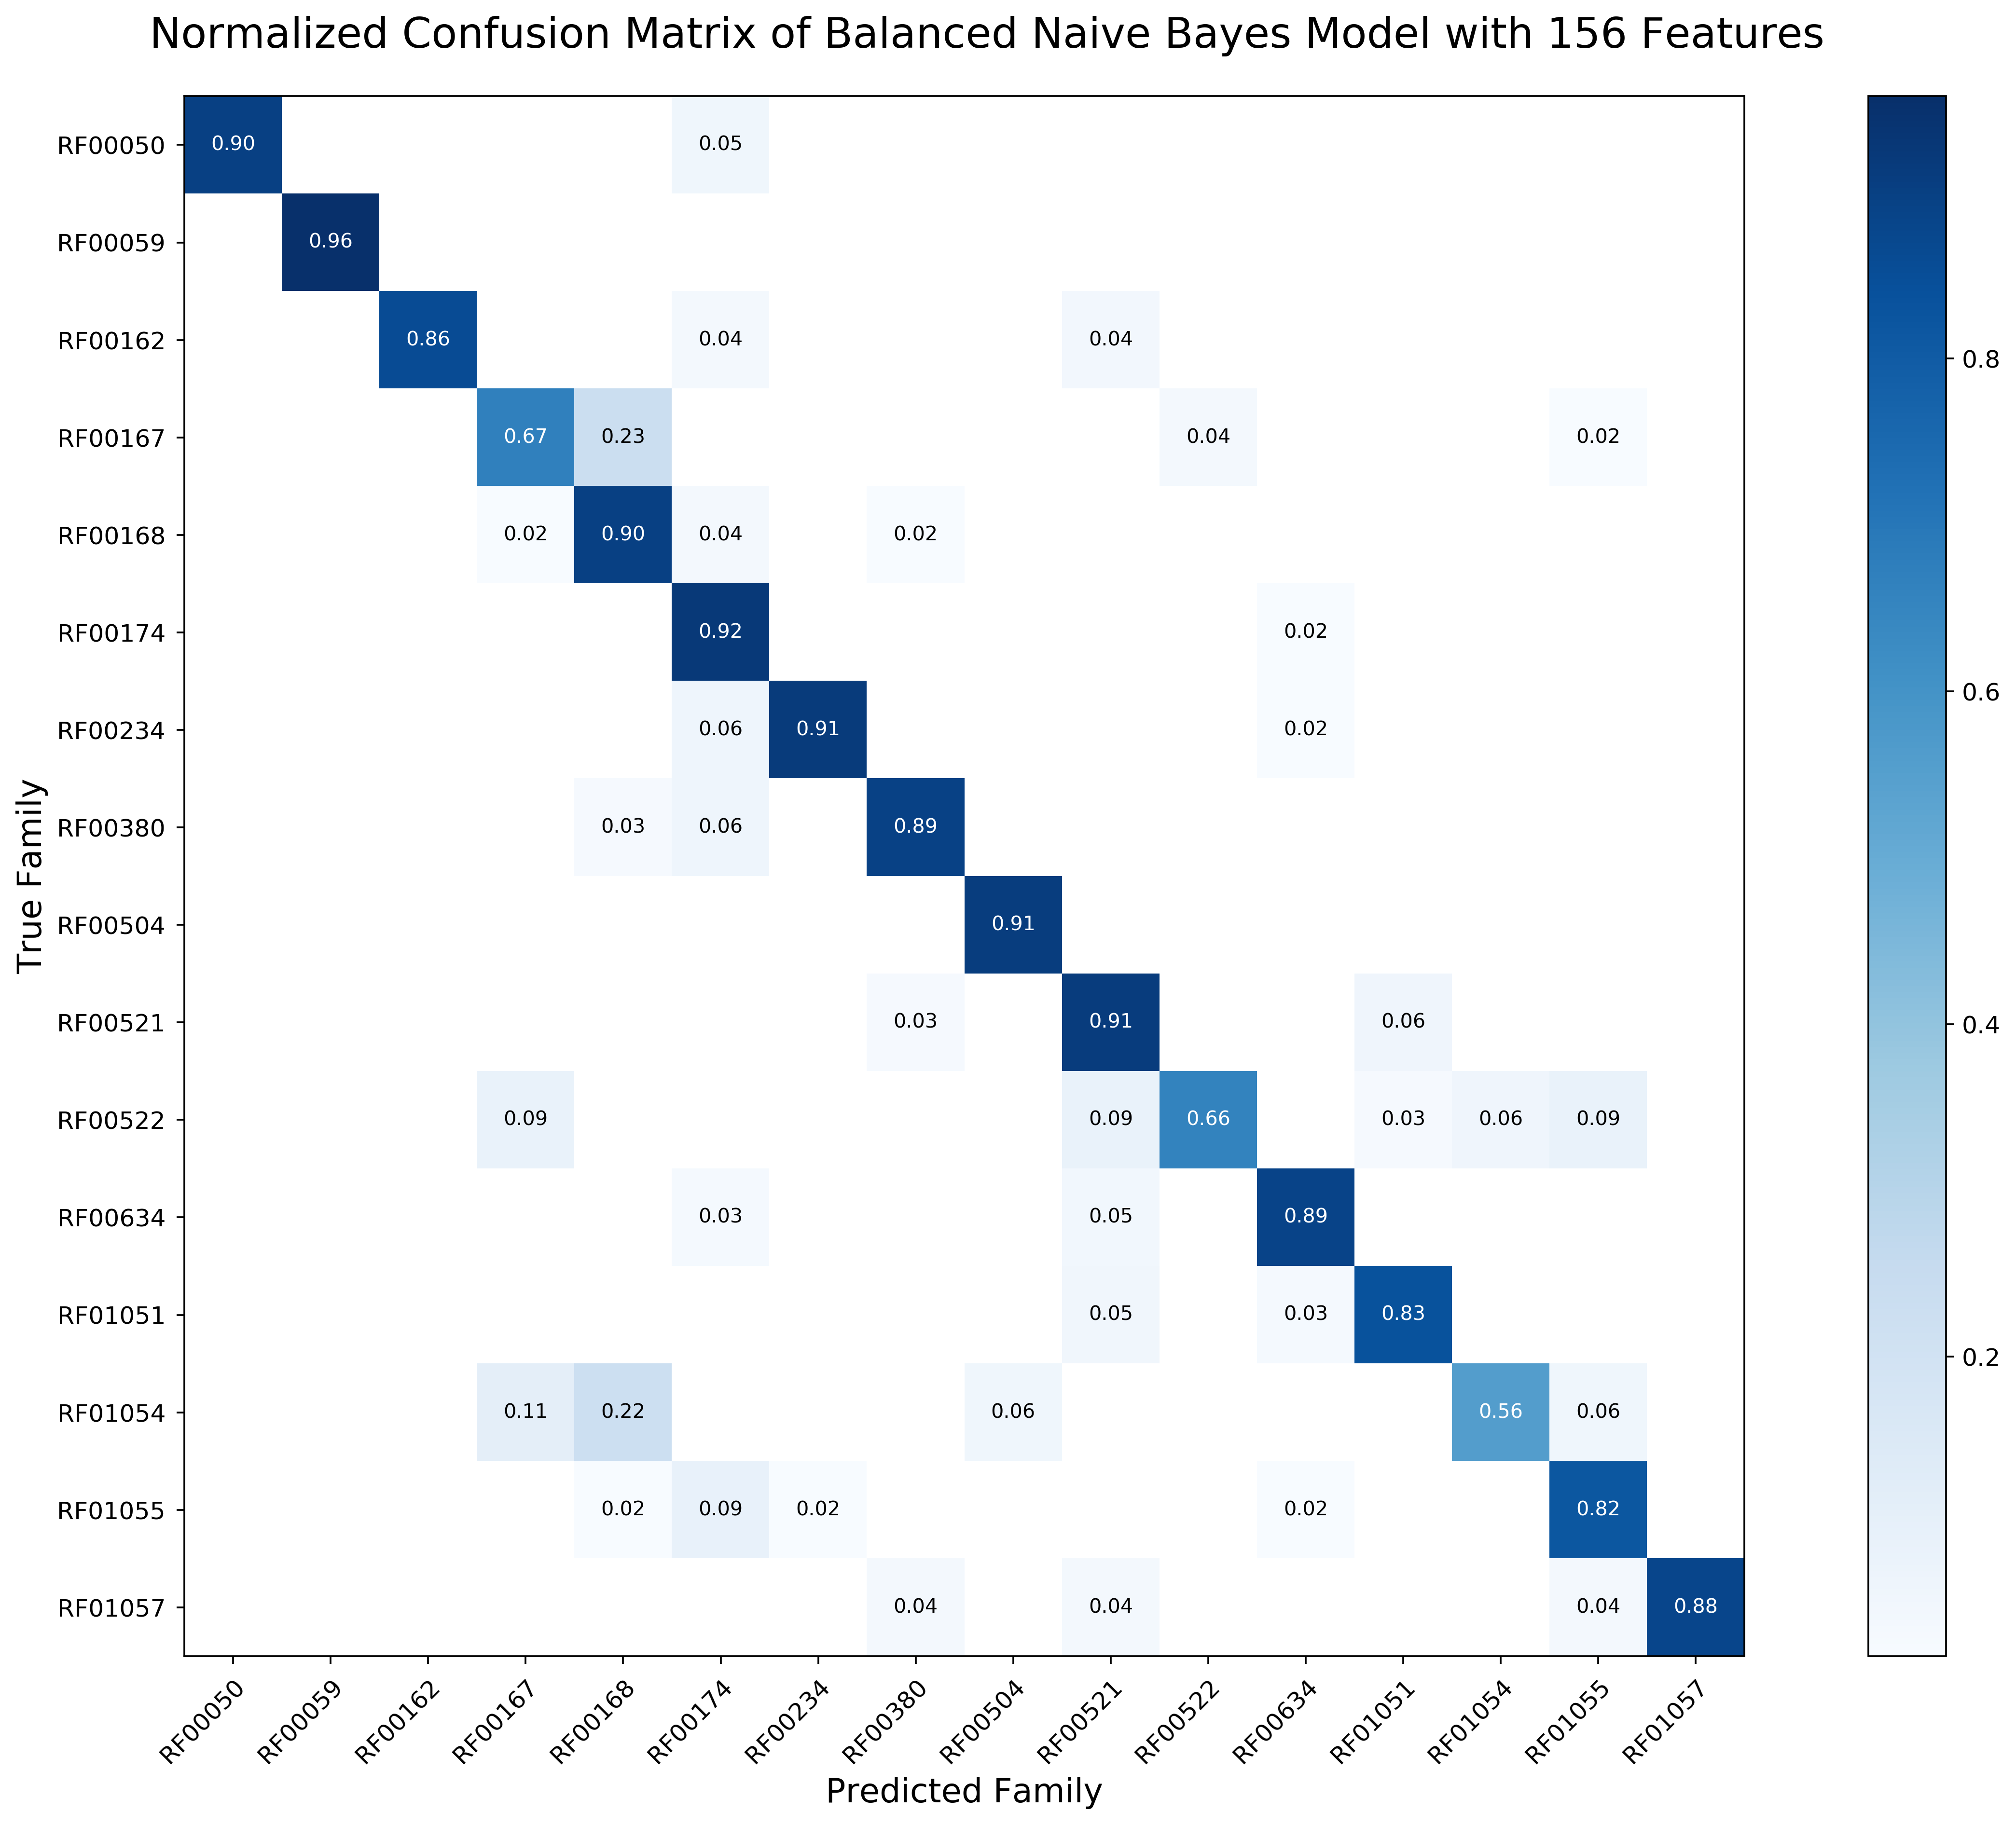

Normalized confusion matrix


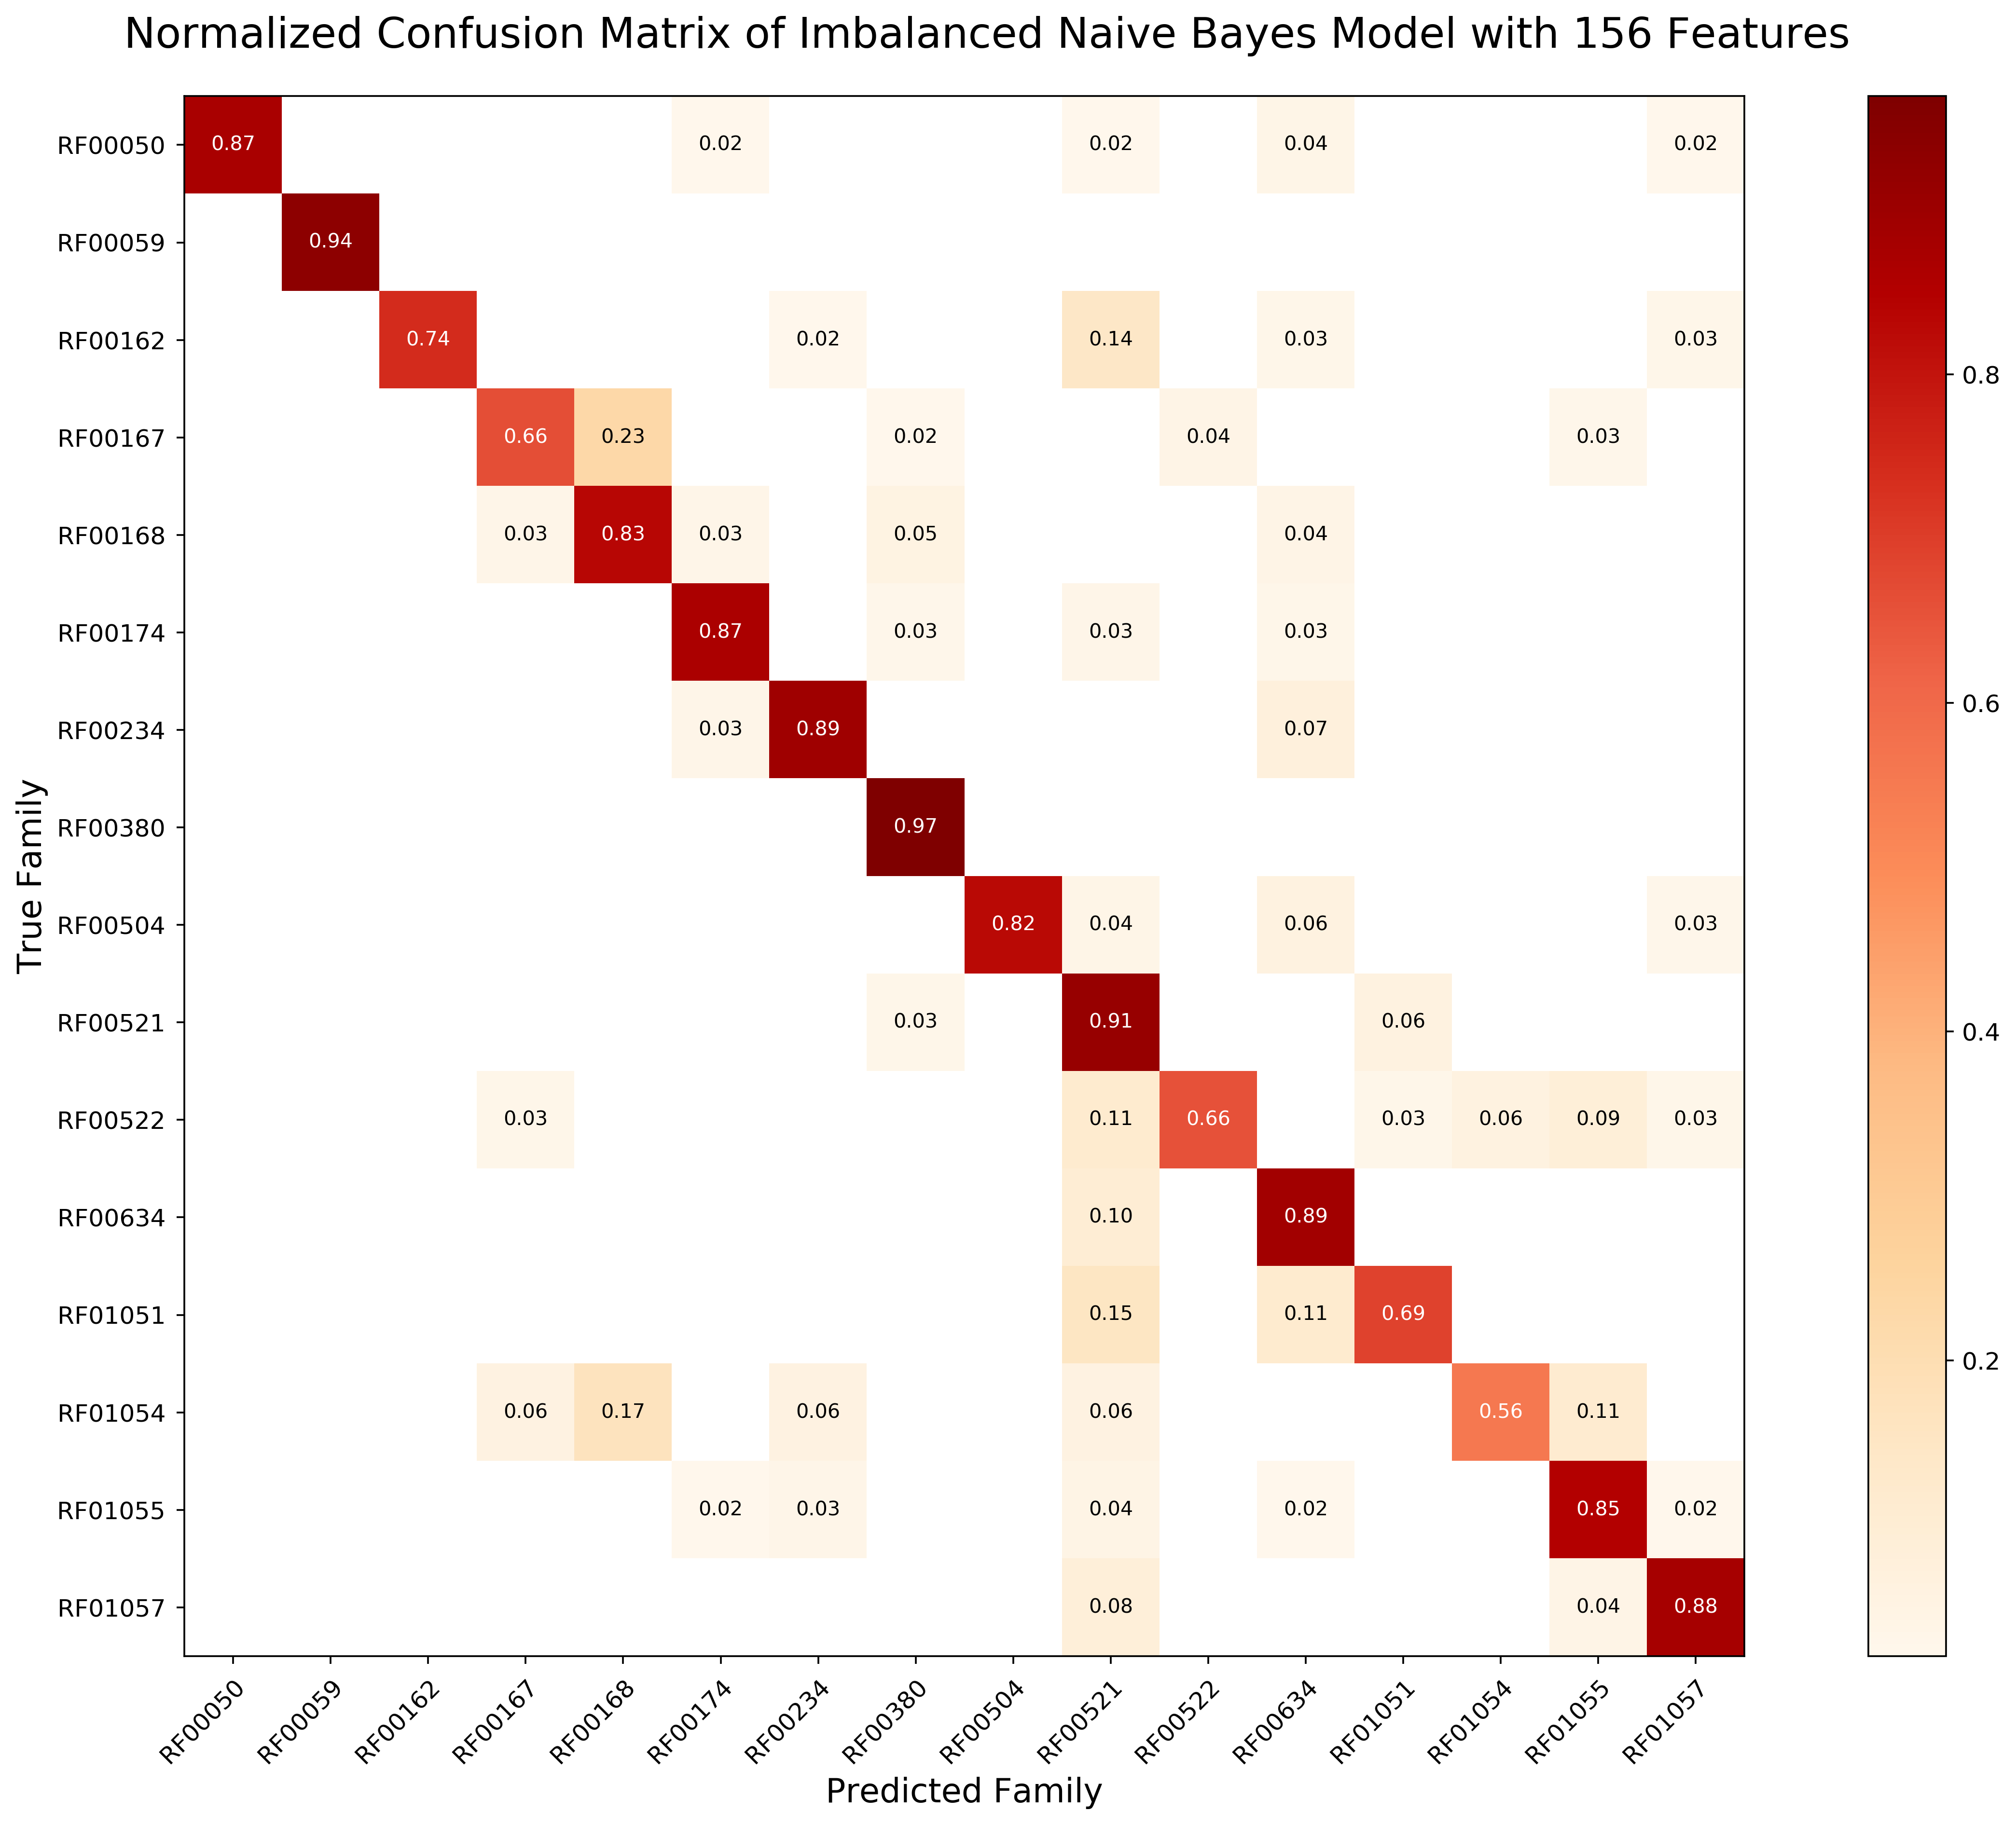

In [97]:
for model_name, balance in zip(models_names.keys(),models_names.values()):
    model = load(model_name)
    if balance == 'Imbalanced':
        cmap = plt.cm.OrRd
    else:
        cmap = plt.cm.Blues
    plot_confusion_matrix(model, models_transfer[model_name], label, balance = balance, normalize = True, cmap = cmap)

In [60]:
for model_name in models_names[0]:
    model = load(model_name)
    export_con_matrix(model, model_name)

In [162]:
export_con_matrix(random, 'random')

0     1    2    3   4     5   6   7    8   9   10  11   12  13  14  15
0   374     1    1    0   0     5   0   1    2   0   0   0    0   0   0   0
1     0  1062    0    1   0     1   0   0    0   0   0   0    1   0   0   0
2     0     3  382    0   0     0   0   0    3   0   0   1    0   0   0   0
3     0     0    0  201  25     0   0   0    0   0   0   0    0   0   0   0
4     0     0    0   11  83     2   0   0    0   0   0   0    0   0   0   0
5     0     1    4    0   1  1285   0   0    0   0   0   0    2   0   0   0
6     0     0    0    0   0     0  94   0    0   0   0   0    0   0   0   0
7     0     0    0    0   0     1   0  64    0   0   0   0    0   0   0   0
8     0     0    1    0   0     2   0   0  630   0   0   0    1   0   0   0
9     0     0    0    0   0     0   0   0    0  34   0   0    0   0   0   0
10    0     0    0    0   0     0   0   0    0   0  35   0    0   0   0   0
11    0     0    0    0   0     0   0   0    0   0   0  61    0   0   0   0
12    0     1    0    0   0     0   0   0    0   0   0   0  318   0   0   0
13    0     0    0    0   0     0   0   0    0   0   0   0    0  18   0   0
14    2     0    1    1   0     4   0   0    0   0   0   0    0   0  85   0
15    0     0    0    0   0     0   0   0    0   0   0   0    0   0   0  50

In [79]:
type(heat_norm)

pandas.core.frame.DataFrame

In [44]:
pltROC(knn, svm, random, gb, mlp, nb, balance = 'balanced', x_train, y_trian, x_test, y_test)
pltROC(knn, svm, random, gb, mlp, nb, balance = 'imbalanced', x_train, y_trian, x_test, y_test)

{'RF00050': 1672, 'RF00059': 2519, 'RF00162': 1758, 'RF00167': 1710, 'RF00168': 1205, 'RF00174': 3016, 'RF00234': 2000, 'RF00380': 1510, 'RF00504': 1481, 'RF00521': 1090, 'RF00522': 770, 'RF00634': 1490, 'RF01051': 1416, 'RF01054': 320, 'RF01055': 1105, 'RF01057': 1390}


## KNN model test

In [29]:
print('knn')
print('----------------------------------------------------------------')
knn = KNN(x_train, y_train, x_test, y_test,'not majority')
save(knn, 'knn')

knn
----------------------------------------------------------------


KeyboardInterrupt: 

knn_im
----------------------------------------------------------------
6
{'fit_time': array([0.2709744 , 0.12616825, 0.16589332, 0.1597085 , 0.27166176,
       0.1643424 , 0.27999187, 0.14076781, 0.14701438, 0.14739299]), 'score_time': array([18.20588279, 18.06362319, 18.4332068 , 16.95914745, 16.91894531,
       16.71238685, 18.34007239, 15.81618762, 16.51496434, 17.34400582]), 'test_acc': array([0.92388451, 0.92172383, 0.92422907, 0.92850838, 0.92497793,
       0.93810787, 0.92661362, 0.914969  , 0.93085106, 0.94148936]), 'test_prec_macro': array([0.84473568, 0.91067008, 0.91484784, 0.91872257, 0.85807856,
       0.86942158, 0.86542127, 0.88985317, 0.92591954, 0.88804023]), 'test_rec_macro': array([0.81551748, 0.83969018, 0.84481853, 0.87742724, 0.8098496 ,
       0.80791442, 0.81500838, 0.80383561, 0.87099401, 0.8167626 ]), 'test_f1_macro': array([0.82651434, 0.86416255, 0.86840475, 0.89312472, 0.82741994,
       0.82894035, 0.83354233, 0.82628707, 0.89165649, 0.84211783])}
8
{'fit

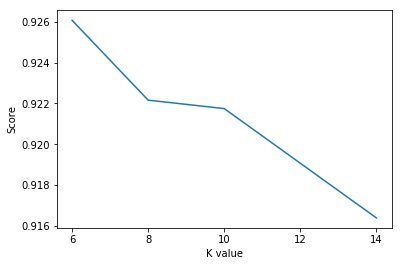

Maximum KNN_im Acuracy Score is 92.61%
f1 score of knn_im: 0.848
Classification report of knn_im: 
              precision    recall  f1-score   support

     RF00050      0.903     0.943     0.922       384
     RF00059      0.933     0.983     0.957      1065
     RF00162      0.888     0.941     0.914       389
     RF00167      0.829     0.858     0.843       226
     RF00168      0.775     0.573     0.659        96
     RF00174      0.938     0.940     0.939      1293
     RF00234      0.859     0.585     0.696        94
     RF00380      0.806     0.831     0.818        65
     RF00504      0.962     0.948     0.955       634
     RF00521      0.941     0.941     0.941        34
     RF00522      0.946     1.000     0.972        35
     RF00634      0.902     0.902     0.902        61
     RF01051      0.953     0.947     0.950       319
     RF01054      1.000     0.333     0.500        18
     RF01055      0.919     0.613     0.735        93
     RF01057      0.894     0.840   

In [56]:
print('knn_im')
print('----------------------------------------------------------------')
knn_im = KNN_im(x_train, y_train, x_test, y_test)
save(knn_im, 'knn_im')

## SVM model test

In [ ]:
print('svm')
print('----------------------------------------------------------------')
svm = svm(x_train, y_train, x_test, y_test, 'not majority')
save(svm, 'svm')

In [ ]:
print('svm_im')
print('----------------------------------------------------------------')
svm_im = svm_im(x_train, y_train, x_test, y_test)
save(svm_im, 'svm_im')

## Random forest test

In [39]:
print('random forest')
print('----------------------------------------------------------------')
random = random_forest(x_train, y_train, x_test, y_test, 'not majority')
save(random, 'random')

random forest
----------------------------------------------------------------
Test score: 0.94
f1 score of random_forest: 0.911
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      1.000     0.938     0.968       384
     RF00059      0.995     0.991     0.993      1065
     RF00162      1.000     0.956     0.978       389
     RF00167      0.985     0.854     0.915       226
     RF00168      0.867     0.542     0.667        96
     RF00174      0.997     0.971     0.984      1293
     RF00234      1.000     0.968     0.984        94
     RF00380      1.000     0.692     0.818        65
     RF00504      0.997     0.972     0.984       634
     RF00521      1.000     0.882     0.938        34
     RF00522      1.000     1.000     1.000        35
     RF00634      1.000     0.787     0.881        61
     RF01051      1.000     0.947     0.973       319
     RF01054      1.000     0.556     0.714        18
     RF01055      1

In [40]:
print('random_forest_im')
print('----------------------------------------------------------------')
random_im = random_forest_im(x_train, y_train, x_test, y_test)
save(random_im, 'random_im')

random_forest_im
----------------------------------------------------------------
Test score: 0.93
f1 score of random_forest_im: 0.875
Classification report of random_forest_im: 
              precision    recall  f1-score   support

     RF00050      0.997     0.930     0.962       384
     RF00059      0.996     0.991     0.993      1065
     RF00162      1.000     0.956     0.978       389
     RF00167      0.980     0.863     0.918       226
     RF00168      0.907     0.406     0.561        96
     RF00174      0.997     0.973     0.985      1293
     RF00234      1.000     0.936     0.967        94
     RF00380      1.000     0.569     0.725        65
     RF00504      0.997     0.972     0.984       634
     RF00521      1.000     0.882     0.938        34
     RF00522      1.000     0.971     0.986        35
     RF00634      1.000     0.770     0.870        61
     RF01051      1.000     0.934     0.966       319
     RF01054      1.000     0.278     0.435        18
     RF010

In [80]:
testhard = pd.read_csv('./testhard_riboswitch_hex_cfs.csv', index_col=0)

In [94]:
print_report('random_test_hard', random, testhard, list(np.array(testhard.index)))

f1 score of random_test_hard: 0.067


ValueError: Number of classes, 11, does not match size of target_names, 16. Try specifying the labels parameter

In [95]:
list(np.array(testhard.index)

SyntaxError: unexpected EOF while parsing (<ipython-input-95-47cdf4be0946>, line 1)

In [ ]:
print('random forest not majority')
print('----------------------------------------------------------------')
random_test1 = random_forest(x_train, y_train, x_test, y_test, 'not majority')

In [ ]:
print('random forest_classweight')
print('----------------------------------------------------------------')
random_test2 = random_forest(x_train, y_train, x_test, y_test, dict, 'balanced')

## Gradient Boosting

In [100]:
gb = gradient_boosting(x_train, y_train, x_test, y_test, 'not majority')
save(gb, 'gb')

ValueError: The {'RF00234', 'RF01051', 'RF00634', 'RF01054', 'RF01055', 'RF00504', 'RF00059', 'RF00162', 'RF00050', 'RF01057', 'RF00521', 'RF00168', 'RF00522', 'RF00174', 'RF00380', 'RF00167'} target class is/are not present in the data.

In [97]:
gb_im = gradient_boosting_im(x_train, y_train, x_test, y_test)
save(gb_im, 'gb_im')

Accuracy on train set:0.901
Accuracy on test set:0.901
f1 score of gb_im: 0.868
Classification report of gb_im: 
              precision    recall  f1-score   support

     RF00050      0.954     0.922     0.938       384
     RF00059      0.979     0.986     0.983      1065
     RF00162      0.954     0.954     0.954       389
     RF00167      0.880     0.876     0.878       226
     RF00168      0.728     0.615     0.667        96
     RF00174      0.971     0.967     0.969      1293
     RF00234      0.968     0.968     0.968        94
     RF00380      0.800     0.554     0.655        65
     RF00504      0.970     0.970     0.970       634
     RF00521      0.966     0.824     0.889        34
     RF00522      1.000     0.857     0.923        35
     RF00634      0.823     0.836     0.829        61
     RF01051      0.947     0.903     0.925       319
     RF01054      0.667     0.667     0.667        18
     RF01055      0.815     0.710     0.759        93
     RF01057      0.92

## MLP

In [45]:
mlp = mlp(x_train, y_train, x_test, y_test, 'not majority')
save(mlp, 'mlp')

Iteration 1, loss = 0.05745394
Iteration 2, loss = 0.00230828
Iteration 3, loss = 0.00191782
Iteration 4, loss = 0.00165909
Iteration 5, loss = 0.00057514
Iteration 6, loss = 0.00038469
Iteration 7, loss = 0.00023062
Iteration 8, loss = 0.00048321
Iteration 9, loss = 0.00058086
Iteration 10, loss = 0.00029867
Iteration 11, loss = 0.00206386
Iteration 12, loss = 0.00014626
Iteration 13, loss = 0.00010900
Iteration 14, loss = 0.00007929
Iteration 15, loss = 0.00008094
Iteration 16, loss = 0.00007261
Iteration 17, loss = 0.00007114
Iteration 18, loss = 0.00007015
Iteration 19, loss = 0.00006931
Iteration 20, loss = 0.00006859
Iteration 21, loss = 0.00006787
Iteration 22, loss = 0.00006717
Iteration 23, loss = 0.00006645
Iteration 24, loss = 0.00006576
Iteration 25, loss = 0.00006504
Iteration 26, loss = 0.00006427
Iteration 27, loss = 0.00006348
Iteration 28, loss = 0.00006270
Iteration 29, loss = 0.00006182
Iteration 30, loss = 0.00006091
Iteration 31, loss = 0.00005994
Iteration 32, los

Iteration 49, loss = 0.00006153
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.08003299
Iteration 2, loss = 0.00929264
Iteration 3, loss = 0.00520320
Iteration 4, loss = 0.00402038
Iteration 5, loss = 0.00368233
Iteration 6, loss = 0.00274305
Iteration 7, loss = 0.00185110
Iteration 8, loss = 0.00108359
Iteration 9, loss = 0.00066793
Iteration 10, loss = 0.00112074
Iteration 11, loss = 0.00355199
Iteration 12, loss = 0.00093307
Iteration 13, loss = 0.00150625
Iteration 14, loss = 0.00042355
Iteration 15, loss = 0.00017368
Iteration 16, loss = 0.00010160
Iteration 17, loss = 0.00009389
Iteration 18, loss = 0.00009045
Iteration 19, loss = 0.00008719
Iteration 20, loss = 0.00008506
Iteration 21, loss = 0.00008319
Iteration 22, loss = 0.00008215
Iteration 23, loss = 0.00008058
Iteration 24, loss = 0.00007945
Iteration 25, loss = 0.00007856
Iteration 26, loss = 0.00007752
Iteration 27, loss = 0.00007681
Iteration 28, loss = 0.

Iteration 44, loss = 0.00002497
Iteration 45, loss = 0.00002381
Iteration 46, loss = 0.00002275
Iteration 47, loss = 0.00132247
Iteration 48, loss = 0.00002666
Iteration 49, loss = 0.00002608
Iteration 50, loss = 0.00002569
Iteration 51, loss = 0.00002531
Iteration 52, loss = 0.00002496
Iteration 53, loss = 0.00002465
Iteration 54, loss = 0.00002433
Iteration 55, loss = 0.00002402
Iteration 56, loss = 0.00002374
Iteration 57, loss = 0.00002345
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.00915395
Iteration 2, loss = 0.00008971
Iteration 3, loss = 0.00006469
Iteration 4, loss = 0.00006077
Iteration 5, loss = 0.00005776
Iteration 6, loss = 0.00005624
Iteration 7, loss = 0.00005502
Iteration 8, loss = 0.00005387
Iteration 9, loss = 0.00005273
Iteration 10, loss = 0.00005161
Iteration 11, loss = 0.00005048
Iteration 12, loss = 0.00004935
Iteration 13, loss = 0.00004823
Iteration 14, loss = 0.00004708
Iteration 15, loss = 0.

Iteration 27, loss = 0.00007574
Iteration 28, loss = 0.00007504
Iteration 29, loss = 0.00006225
Iteration 30, loss = 0.00006028
Iteration 31, loss = 0.00005923
Iteration 32, loss = 0.00005850
Iteration 33, loss = 0.00005786
Iteration 34, loss = 0.00005728
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.02015880
Iteration 2, loss = 0.00027248
Iteration 3, loss = 0.00022780
Iteration 4, loss = 0.00007221
Iteration 5, loss = 0.00006272
Iteration 6, loss = 0.00006037
Iteration 7, loss = 0.00005879
Iteration 8, loss = 0.00005783
Iteration 9, loss = 0.00005686
Iteration 10, loss = 0.00005600
Iteration 11, loss = 0.00005515
Iteration 12, loss = 0.00005429
Iteration 13, loss = 0.00005345
Iteration 14, loss = 0.00005257
Iteration 15, loss = 0.00005171
Iteration 16, loss = 0.00005084
Iteration 17, loss = 0.00004991
Iteration 18, loss = 0.00004900
Iteration 19, loss = 0.00004807
Iteration 20, loss = 0.00004711
Iteration 21, loss = 0.

In [46]:
mlp_im = mlp_im(x_train, y_train, x_test, y_test)
save(mlp_im, 'mlp_im')

Iteration 1, loss = 0.18700739
Iteration 2, loss = 0.01960332
Iteration 3, loss = 0.00974267
Iteration 4, loss = 0.00493690
Iteration 5, loss = 0.00311948
Iteration 6, loss = 0.00279523
Iteration 7, loss = 0.00191254
Iteration 8, loss = 0.00124430
Iteration 9, loss = 0.00051817
Iteration 10, loss = 0.00037193
Iteration 11, loss = 0.00034322
Iteration 12, loss = 0.00031410
Iteration 13, loss = 0.00020488
Iteration 14, loss = 0.00016241
Iteration 15, loss = 0.00014020
Iteration 16, loss = 0.00012528
Iteration 17, loss = 0.00011467
Iteration 18, loss = 0.00010503
Iteration 19, loss = 0.00009685
Iteration 20, loss = 0.00009146
Iteration 21, loss = 0.00008727
Iteration 22, loss = 0.00008494
Iteration 23, loss = 0.00008173
Iteration 24, loss = 0.00007915
Iteration 25, loss = 0.00007786
Iteration 26, loss = 0.00007609
Iteration 27, loss = 0.00007473
Iteration 28, loss = 0.00007332
Iteration 29, loss = 0.00007238
Iteration 30, loss = 0.00007143
Iteration 31, loss = 0.00007076
Iteration 32, los

Iteration 85, loss = 0.00006018
Iteration 86, loss = 0.00006002
Iteration 87, loss = 0.00005985
Iteration 88, loss = 0.00005969
Iteration 89, loss = 0.00005951
Iteration 90, loss = 0.00005935
Iteration 91, loss = 0.00005918
Iteration 92, loss = 0.00005901
Iteration 93, loss = 0.00005885
Iteration 94, loss = 0.00005867
Iteration 95, loss = 0.00005848
Iteration 96, loss = 0.00005829
Iteration 97, loss = 0.00005813
Iteration 98, loss = 0.00005794
Iteration 99, loss = 0.00005776
Iteration 100, loss = 0.00005757
Iteration 101, loss = 0.00005741
Iteration 102, loss = 0.00005721
Iteration 103, loss = 0.00005700
Iteration 104, loss = 0.00005681
Iteration 105, loss = 0.00005662
Iteration 106, loss = 0.00005643
Iteration 107, loss = 0.00005622
Iteration 108, loss = 0.00005603
Iteration 109, loss = 0.00005583
Iteration 110, loss = 0.00005563
Iteration 111, loss = 0.00005543
Iteration 112, loss = 0.00005521
Iteration 113, loss = 0.00005500
Iteration 114, loss = 0.00005482
Iteration 115, loss = 0.0

Iteration 155, loss = 0.12572865
Iteration 156, loss = 0.00543933
Iteration 157, loss = 0.00346833
Iteration 158, loss = 0.00173253
Iteration 159, loss = 0.00077363
Iteration 160, loss = 0.00048028
Iteration 161, loss = 0.00033276
Iteration 162, loss = 0.00025704
Iteration 163, loss = 0.00021215
Iteration 164, loss = 0.00019009
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.19105709
Iteration 2, loss = 0.05975678
Iteration 3, loss = 0.03477888
Iteration 4, loss = 0.02573054
Iteration 5, loss = 0.02346227
Iteration 6, loss = 0.01863648
Iteration 7, loss = 0.01435813
Iteration 8, loss = 0.01316237
Iteration 9, loss = 0.01295933
Iteration 10, loss = 0.01238616
Iteration 11, loss = 0.00810087
Iteration 12, loss = 0.00763222
Iteration 13, loss = 0.00667538
Iteration 14, loss = 0.00518708
Iteration 15, loss = 0.00362151
Iteration 16, loss = 0.00347991
Iteration 17, loss = 0.00262433
Iteration 18, loss = 0.00189460
Iteration 19,

Iteration 42, loss = 0.00008895
Iteration 43, loss = 0.00008763
Iteration 44, loss = 0.00008558
Iteration 45, loss = 0.00008413
Iteration 46, loss = 0.00008321
Iteration 47, loss = 0.00008190
Iteration 48, loss = 0.00008091
Iteration 49, loss = 0.00008006
Iteration 50, loss = 0.00007886
Iteration 51, loss = 0.00007804
Iteration 52, loss = 0.00007732
Iteration 53, loss = 0.00007654
Iteration 54, loss = 0.00007590
Iteration 55, loss = 0.00007537
Iteration 56, loss = 0.00007478
Iteration 57, loss = 0.00007424
Iteration 58, loss = 0.00007381
Iteration 59, loss = 0.00007359
Iteration 60, loss = 0.00007305
Iteration 61, loss = 0.00007285
Iteration 62, loss = 0.00007245
Iteration 63, loss = 0.00007215
Iteration 64, loss = 0.00007190
Iteration 65, loss = 0.00007161
Iteration 66, loss = 0.00007146
Iteration 67, loss = 0.00007119
Iteration 68, loss = 0.00007096
Iteration 69, loss = 0.00007073
Iteration 70, loss = 0.00007053
Iteration 71, loss = 0.00007034
Iteration 72, loss = 0.00007017
Iteratio

Iteration 96, loss = 0.00006269
Iteration 97, loss = 0.00006255
Iteration 98, loss = 0.00006238
Iteration 99, loss = 0.00006222
Iteration 100, loss = 0.00006204
Iteration 101, loss = 0.00006188
Iteration 102, loss = 0.00006171
Iteration 103, loss = 0.00006154
Iteration 104, loss = 0.00006137
Iteration 105, loss = 0.00006122
Iteration 106, loss = 0.00006104
Iteration 107, loss = 0.00006085
Iteration 108, loss = 0.00006066
Iteration 109, loss = 0.00006048
Iteration 110, loss = 0.00006031
Iteration 111, loss = 0.00006012
Iteration 112, loss = 0.00005993
Iteration 113, loss = 0.00005977
Iteration 114, loss = 0.00005957
Iteration 115, loss = 0.00005937
Iteration 116, loss = 0.00005918
Iteration 117, loss = 0.00005899
Iteration 118, loss = 0.00005879
Iteration 119, loss = 0.00005859
Iteration 120, loss = 0.00005842
Iteration 121, loss = 0.00005820
Iteration 122, loss = 0.00005800
Iteration 123, loss = 0.00005779
Iteration 124, loss = 0.00005760
Iteration 125, loss = 0.00005740
Iteration 126,

Iteration 147, loss = 0.00003518
Iteration 148, loss = 0.04403074
Iteration 149, loss = 0.00183778
Iteration 150, loss = 0.00029175
Iteration 151, loss = 0.00014890
Iteration 152, loss = 0.00013585
Iteration 153, loss = 0.00007432
Iteration 154, loss = 0.00005920
Iteration 155, loss = 0.00005467
Iteration 156, loss = 0.00005211
Iteration 157, loss = 0.00005050
Iteration 158, loss = 0.00004877
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.09255930
Iteration 2, loss = 0.02107155
Iteration 3, loss = 0.00780435
Iteration 4, loss = 0.00322940
Iteration 5, loss = 0.00182258
Iteration 6, loss = 0.00059786
Iteration 7, loss = 0.00038657
Iteration 8, loss = 0.00034033
Iteration 9, loss = 0.00027773
Iteration 10, loss = 0.00015477
Iteration 11, loss = 0.00012793
Iteration 12, loss = 0.00011511
Iteration 13, loss = 0.00010610
Iteration 14, loss = 0.00009915
Iteration 15, loss = 0.00009430
Iteration 16, loss = 0.00008974
Iteration 1

Iteration 73, loss = 0.00005759
Iteration 74, loss = 0.00005743
Iteration 75, loss = 0.00005724
Iteration 76, loss = 0.00005710
Iteration 77, loss = 0.00005693
Iteration 78, loss = 0.00005674
Iteration 79, loss = 0.00005655
Iteration 80, loss = 0.00005636
Iteration 81, loss = 0.00005622
Iteration 82, loss = 0.00005601
Iteration 83, loss = 0.00005583
Iteration 84, loss = 0.00005566
Iteration 85, loss = 0.00005548
Iteration 86, loss = 0.00005532
Iteration 87, loss = 0.00005511
Iteration 88, loss = 0.00005494
Iteration 89, loss = 0.00005476
Iteration 90, loss = 0.00005455
Iteration 91, loss = 0.00005436
Iteration 92, loss = 0.00005417
Iteration 93, loss = 0.00005400
Iteration 94, loss = 0.00005379
Iteration 95, loss = 0.00005360
Iteration 96, loss = 0.00005340
Iteration 97, loss = 0.00005320
Iteration 98, loss = 0.00005299
Iteration 99, loss = 0.00005279
Iteration 100, loss = 0.00005261
Iteration 101, loss = 0.00005239
Iteration 102, loss = 0.00005215
Iteration 103, loss = 0.00005197
Iter

Iteration 159, loss = 0.00002666
Iteration 160, loss = 0.00002630
Iteration 161, loss = 0.00002602
Iteration 162, loss = 0.00002569
Iteration 163, loss = 0.00002539
Iteration 164, loss = 0.00002510
Iteration 165, loss = 0.00002480
Iteration 166, loss = 0.00002462
Iteration 167, loss = 0.00002435
Iteration 168, loss = 0.00002402
Iteration 169, loss = 0.00002374
Iteration 170, loss = 0.00002354
Iteration 171, loss = 0.00002316
Iteration 172, loss = 0.00002303
Iteration 173, loss = 0.00002287
Iteration 174, loss = 0.00002266
Iteration 175, loss = 0.02180582
Iteration 176, loss = 0.00033095
Iteration 177, loss = 0.00011579
Iteration 178, loss = 0.00003560
Iteration 179, loss = 0.00003145
Iteration 180, loss = 0.00003044
Iteration 181, loss = 0.00003000
Iteration 182, loss = 0.00002971
Iteration 183, loss = 0.00002946
Iteration 184, loss = 0.00002927
Iteration 185, loss = 0.00002911
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Stopping.
Iteration 1, loss =

Iteration 50, loss = 0.00006395
Iteration 51, loss = 0.00006377
Iteration 52, loss = 0.00006360
Iteration 53, loss = 0.00006343
Iteration 54, loss = 0.00006326
Iteration 55, loss = 0.00006309
Iteration 56, loss = 0.00006293
Iteration 57, loss = 0.00006274
Iteration 58, loss = 0.00006258
Iteration 59, loss = 0.00006242
Iteration 60, loss = 0.00006224
Iteration 61, loss = 0.00006207
Iteration 62, loss = 0.00006190
Iteration 63, loss = 0.00006175
Iteration 64, loss = 0.00006158
Iteration 65, loss = 0.00006142
Iteration 66, loss = 0.00006123
Iteration 67, loss = 0.00006107
Iteration 68, loss = 0.00006089
Iteration 69, loss = 0.00006070
Iteration 70, loss = 0.00006052
Iteration 71, loss = 0.00006035
Iteration 72, loss = 0.00006016
Iteration 73, loss = 0.00006000
Iteration 74, loss = 0.00005980
Iteration 75, loss = 0.00005962
Iteration 76, loss = 0.00005943
Iteration 77, loss = 0.00005925
Iteration 78, loss = 0.00005907
Iteration 79, loss = 0.00005888
Iteration 80, loss = 0.00005869
Iteratio

Iteration 111, loss = 0.00005117
Iteration 112, loss = 0.00005084
Iteration 113, loss = 0.00005059
Iteration 114, loss = 0.00005033
Iteration 115, loss = 0.00005006
Iteration 116, loss = 0.00004980
Iteration 117, loss = 0.00004956
Iteration 118, loss = 0.00004929
Iteration 119, loss = 0.00004898
Iteration 120, loss = 0.00004871
Iteration 121, loss = 0.00004845
Iteration 122, loss = 0.00004832
Iteration 123, loss = 0.00004790
Iteration 124, loss = 0.00004763
Iteration 125, loss = 0.00004733
Iteration 126, loss = 0.00004712
Iteration 127, loss = 0.00004680
Iteration 128, loss = 0.00004650
Iteration 129, loss = 0.00004623
Iteration 130, loss = 0.00004590
Iteration 131, loss = 0.00004559
Iteration 132, loss = 0.00004536
Iteration 133, loss = 0.00004501
Iteration 134, loss = 0.00004481
Iteration 135, loss = 0.00004443
Iteration 136, loss = 0.00004413
Iteration 137, loss = 0.00004387
Iteration 138, loss = 0.00004351
Iteration 139, loss = 0.00004326
Iteration 140, loss = 0.00004296
Iteration 

Iteration 34, loss = 0.00006753
Iteration 35, loss = 0.00006730
Iteration 36, loss = 0.00006713
Iteration 37, loss = 0.00006693
Iteration 38, loss = 0.00006676
Iteration 39, loss = 0.00006660
Iteration 40, loss = 0.00006640
Iteration 41, loss = 0.00006621
Iteration 42, loss = 0.00006604
Iteration 43, loss = 0.00006587
Iteration 44, loss = 0.00006569
Iteration 45, loss = 0.00006551
Iteration 46, loss = 0.00006534
Iteration 47, loss = 0.00006518
Iteration 48, loss = 0.00006499
Iteration 49, loss = 0.00006480
Iteration 50, loss = 0.00006465
Iteration 51, loss = 0.00006446
Iteration 52, loss = 0.00006428
Iteration 53, loss = 0.00006408
Iteration 54, loss = 0.00006391
Iteration 55, loss = 0.00006371
Iteration 56, loss = 0.00006353
Iteration 57, loss = 0.00006336
Iteration 58, loss = 0.00006316
Iteration 59, loss = 0.00006297
Iteration 60, loss = 0.00006279
Iteration 61, loss = 0.00006262
Iteration 62, loss = 0.00006240
Iteration 63, loss = 0.00006221
Iteration 64, loss = 0.00006202
Iteratio

Iteration 115, loss = 0.00004619
Iteration 116, loss = 0.00004566
Iteration 117, loss = 0.00004529
Iteration 118, loss = 0.00004504
Iteration 119, loss = 0.00004472
Iteration 120, loss = 0.00004450
Iteration 121, loss = 0.00004424
Iteration 122, loss = 0.00004393
Iteration 123, loss = 0.00004367
Iteration 124, loss = 0.00004339
Iteration 125, loss = 0.00004315
Iteration 126, loss = 0.00004286
Iteration 127, loss = 0.00004270
Iteration 128, loss = 0.00004234
Iteration 129, loss = 0.00004207
Iteration 130, loss = 0.00004180
Iteration 131, loss = 0.00004155
Iteration 132, loss = 0.00004126
Iteration 133, loss = 0.00004100
Iteration 134, loss = 0.00004077
Iteration 135, loss = 0.00004058
Iteration 136, loss = 0.00004029
Iteration 137, loss = 0.00004002
Iteration 138, loss = 0.00003967
Iteration 139, loss = 0.00003959
Iteration 140, loss = 0.00003912
Iteration 141, loss = 0.00003880
Iteration 142, loss = 0.00003861
Iteration 143, loss = 0.00003834
Iteration 144, loss = 0.00003797
Iteration 

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=1, ratio=None,
                       sampling_strategy='not majority',
                       svm_estimator='deprecated')),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=MLPClassifier(activation='relu',
                                                             alpha=0.0001,
                                                             batch_size='auto',
                                                             beta_1=0.9,
                                                             beta_2=0.999,
                                                             early_stopping=False,
                                                             epsilon=1e-08,
                                                             hidden_la

In [ ]:
print_report('mlp_im_test', mlp_im, x_train, y_train)

## NB test

In [42]:
print('nb')
print('-------------------------------------------------------')
nb = naive_bayes(x_train, y_train, x_test, y_test, 'not majority')
save(nb, 'nb')

nb
-------------------------------------------------------
Accuracy of Naive Bayes: 72.26%
f1 score of nb: 0.646
Classification report of nb: 
              precision    recall  f1-score   support

     RF00050      0.913     0.932     0.923       384
     RF00059      0.972     0.984     0.978      1065
     RF00162      0.583     0.907     0.710       389
     RF00167      0.573     0.898     0.700       226
     RF00168      0.277     0.948     0.429        96
     RF00174      0.848     0.971     0.906      1293
     RF00234      0.430     0.915     0.585        94
     RF00380      0.212     0.908     0.344        65
     RF00504      0.927     0.946     0.937       634
     RF00521      0.194     0.912     0.320        34
     RF00522      0.719     0.657     0.687        35
     RF00634      0.312     0.902     0.464        61
     RF01051      0.915     0.906     0.910       319
     RF01054      0.455     0.556     0.500        18
     RF01055      0.361     0.839     0.505   

In [43]:
print('nb_im')
print('-------------------------------------------------------')
nb_im = naive_bayes_im(x_train, y_train, x_test, y_test)
save(nb_im, 'nb_im')

nb_im
-------------------------------------------------------
Accuracy of Naive Bayes: 62.91%
f1 score of nb_im: 0.553
Classification report of nb_im: 
              precision    recall  f1-score   support

     RF00050      0.833     0.945     0.885       384
     RF00059      0.944     0.973     0.958      1065
     RF00162      0.661     0.936     0.774       389
     RF00167      0.443     0.925     0.599       226
     RF00168      0.214     0.969     0.351        96
     RF00174      0.853     0.964     0.905      1293
     RF00234      0.183     0.957     0.307        94
     RF00380      0.103     0.969     0.187        65
     RF00504      0.825     0.968     0.891       634
     RF00521      0.090     0.912     0.164        34
     RF00522      0.719     0.657     0.687        35
     RF00634      0.116     0.934     0.206        61
     RF01051      0.775     0.950     0.854       319
     RF01054      0.455     0.556     0.500        18
     RF01055      0.207     0.968    

In [ ]:
.

## Three methods comparison

In [168]:
best = make_pipeline(SMOTE(random_state = 5), KNeighborsClassifier(n_neighbors=10))
scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 5, n_jobs=10)
print(scores)
best.fit(x_train, y_train)
best.score(x_test, y_test)
best_pred = best.predict(x_test)
# f1 score
print("f1 score of best: {:.2f}".format(f1_score(y_test,best_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best: \n{}".format(classification_report(y_test, best_pred,
                                        target_names= label)))
best_proba = best.predict_proba(x_test)

{'fit_time': array([1.36815619, 1.38522267, 1.27516413, 1.46671844, 1.39341235]), 'score_time': array([65.77883387, 66.15830994, 64.95893312, 67.77423406, 66.04027724]), 'test_precision_macro': array([0.45819163, 0.48098308, 0.45682151, 0.47233651, 0.47222897]), 'test_recall_macro': array([0.69405591, 0.69335485, 0.67254681, 0.7193012 , 0.69062105]), 'test_f1_macro': array([0.46983322, 0.4947362 , 0.46601983, 0.49063489, 0.4851479 ])}
f1 score of best: 0.50
Classification report of best: 
              precision    recall  f1-score   support

     RF00050       0.62      0.79      0.69       359
     RF00059       0.95      0.43      0.59      1083
     RF00162       0.44      0.80      0.57       365
     RF00167       0.54      0.73      0.62       244
     RF00168       0.14      0.66      0.23        88
     RF00174       1.00      0.33      0.49      1277
     RF00234       0.25      0.71      0.37        90
     RF00380       0.20      0.79      0.32        63
     RF00504       

In [170]:
best2 = KNeighborsClassifier(n_neighbors=16)
scores2 = cross_validate(best2, x_train, y_train, scoring = scoring, cv = 5, n_jobs=10)
print(scores2)
best2.fit(x_train, y_train)
best2.score(x_test, y_test)
best2_pred = best2.predict(x_test)
# f1 score
print("f1 score of best3: {:.2f}".format(f1_score(y_test,best2_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best2: \n{}".format(classification_report(y_test, best2_pred,
                                        target_names= label)))
best2_proba = best2.predict_proba(x_test)

{'fit_time': array([0.04368973, 0.04368138, 0.04063821, 0.04307175, 0.04468369]), 'score_time': array([11.63832211, 11.69619298, 12.09875536, 11.89288187, 11.96761632]), 'test_precision_macro': array([0.76222982, 0.77800996, 0.71748333, 0.7782801 , 0.79469287]), 'test_recall_macro': array([0.51248768, 0.5246983 , 0.50299728, 0.52320519, 0.49453976]), 'test_f1_macro': array([0.5736022 , 0.57565019, 0.55515465, 0.5859372 , 0.55578544])}
f1 score of best3: 0.60
Classification report of best2: 
              precision    recall  f1-score   support

     RF00050       0.83      0.78      0.81       359
     RF00059       0.79      0.92      0.85      1083
     RF00162       0.65      0.74      0.69       365
     RF00167       0.86      0.59      0.70       244
     RF00168       0.57      0.48      0.52        88
     RF00174       0.88      0.87      0.88      1277
     RF00234       0.80      0.27      0.40        90
     RF00380       0.79      0.48      0.59        63
     RF00504     

In [171]:
over_samples_train = SMOTEENN(random_state=5, n_jobs=5)
x_train_s, y_train_s = over_samples_train.fit_sample(x_train, y_train)
best3 = KNeighborsClassifier(n_neighbors=16)
scores3 = cross_validate(best3, x_train_s, y_train_s, scoring = scoring, cv = 5, n_jobs=10)
print(scores3)
best3.fit(x_train_s, y_train_s)
best3.score(x_test, y_test)

best3_pred = best3.predict(x_test)
# f1 score
print("f1 score of best3: {:.2f}".format(f1_score(y_test,best3_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best3: \n{}".format(classification_report(y_test, best3_pred,
                                        target_names= label)))
best3_proba = best3.predict_proba(x_test)

{'fit_time': array([0.22312522, 0.29851818, 0.29342937, 0.18135238, 0.28857732]), 'score_time': array([168.14797163, 165.46073842, 166.19052601, 162.7279706 ,
       163.33171201]), 'test_precision_macro': array([0.95304545, 0.96063604, 0.95937588, 0.9568318 , 0.95625031]), 'test_recall_macro': array([0.91273627, 0.92393875, 0.91939974, 0.90468659, 0.90314451]), 'test_f1_macro': array([0.92442428, 0.93549652, 0.93110554, 0.91621002, 0.91123336])}
f1 score of best3: 0.46
Classification report of best3: 
              precision    recall  f1-score   support

     RF00050       0.55      0.79      0.65       359
     RF00059       0.98      0.26      0.41      1083
     RF00162       0.40      0.80      0.53       365
     RF00167       0.50      0.72      0.59       244
     RF00168       0.11      0.66      0.19        88
     RF00174       1.00      0.17      0.30      1277
     RF00234       0.24      0.73      0.36        90
     RF00380       0.17      0.78      0.28        63
     

A         C         G         U        AA        AC        AG  \
Class                                                                       
RF00522  0.11  0.047619  0.008929  0.072165  0.166667  0.086957  0.028571   
RF00167  0.23  0.085714  0.169643  0.288660  0.194444  0.130435  0.142857   
RF00174  0.36  0.571429  0.491071  0.257732  0.250000  0.652174  0.342857   
RF01055  0.23  0.238095  0.303571  0.185567  0.194444  0.347826  0.200000   
RF00059  0.22  0.114286  0.178571  0.195876  0.194444  0.217391  0.228571   
...       ...       ...       ...       ...       ...       ...       ...   
RF00059  0.23  0.257143  0.258929  0.278351  0.111111  0.391304  0.228571   
RF00167  0.11  0.085714  0.080357  0.154639  0.138889  0.217391  0.000000   
RF00059  0.10  0.180952  0.267857  0.164948  0.055556  0.130435  0.257143   
RF00168  0.54  0.142857  0.330357  0.494845  0.388889  0.217391  0.485714   
RF00234  0.50  0.285714  0.375000  0.288660  0.444444  0.478261  0.485714   

               AU        CA        CC  ...  GCUGAG  GCCACU    GCCUCC  \
Class                                  ...                             
RF00522  0.129032  0.100000  0.064516  ...     0.0     0.0  0.000000   
RF00167  0.322581  0.066667  0.096774  ...     0.0     0.0  0.000000   
RF00174  0.161290  0.333333  0.677419  ...     0.0     0.0  0.000000   
RF01055  0.161290  0.166667  0.258065  ...     0.0     0.0  0.000000   
RF00059  0.161290  0.133333  0.096774  ...     0.0     0.0  0.000000   
...           ...       ...       ...  ...     ...     ...       ...   
RF00059  0.258065  0.200000  0.258065  ...     0.0     0.0  0.333333   
RF00167  0.161290  0.066667  0.161290  ...     0.0     0.0  0.000000   
RF00059  0.064516  0.066667  0.225806  ...     0.0     0.0  0.000000   
RF00168  0.548387  0.266667  0.032258  ...     0.0     0.0  0.000000   
RF00234  0.258065  0.366667  0.161290  ...     0.0     0.0  0.000000   

           GCCGAA    GGAAGG  GGAGAG  GGCUGA  GGCGGU  GGGAAG  GGGUGC  
Class                                                                
RF00522  0.000000  0.000000     0.0     0.0     0.0     0.0     0.0  
RF00167  0.000000  0.333333     0.0     0.0     0.0     0.0     0.0  
RF00174  0.000000  0.000000     0.0     0.0     0.0     0.0     0.0  
RF01055  0.000000  0.000000     0.0     0.0     0.0     0.0     0.0  
RF00059  0.000000  0.000000     0.0     0.0     0.0     0.0     0.0  
...           ...       ...     ...     ...     ...     ...     ...  
RF00059  0.000000  0.000000     0.0     0.0     0.0     0.0     0.0  
RF00167  0.000000  0.000000     0.0     0.0     0.0     0.0     0.0  
RF00059  0.000000  0.000000     0.0     0.0     0.0     0.0     0.5  
RF00168  0.666667  0.000000     0.0     0.0     0.0     0.0     0.0  
RF00234  0.333333  0.000000     0.0     0.0     0.0     0.0     0.0  

[12947 rows x 166 columns]

<Figure size 432x288 with 0 Axes>

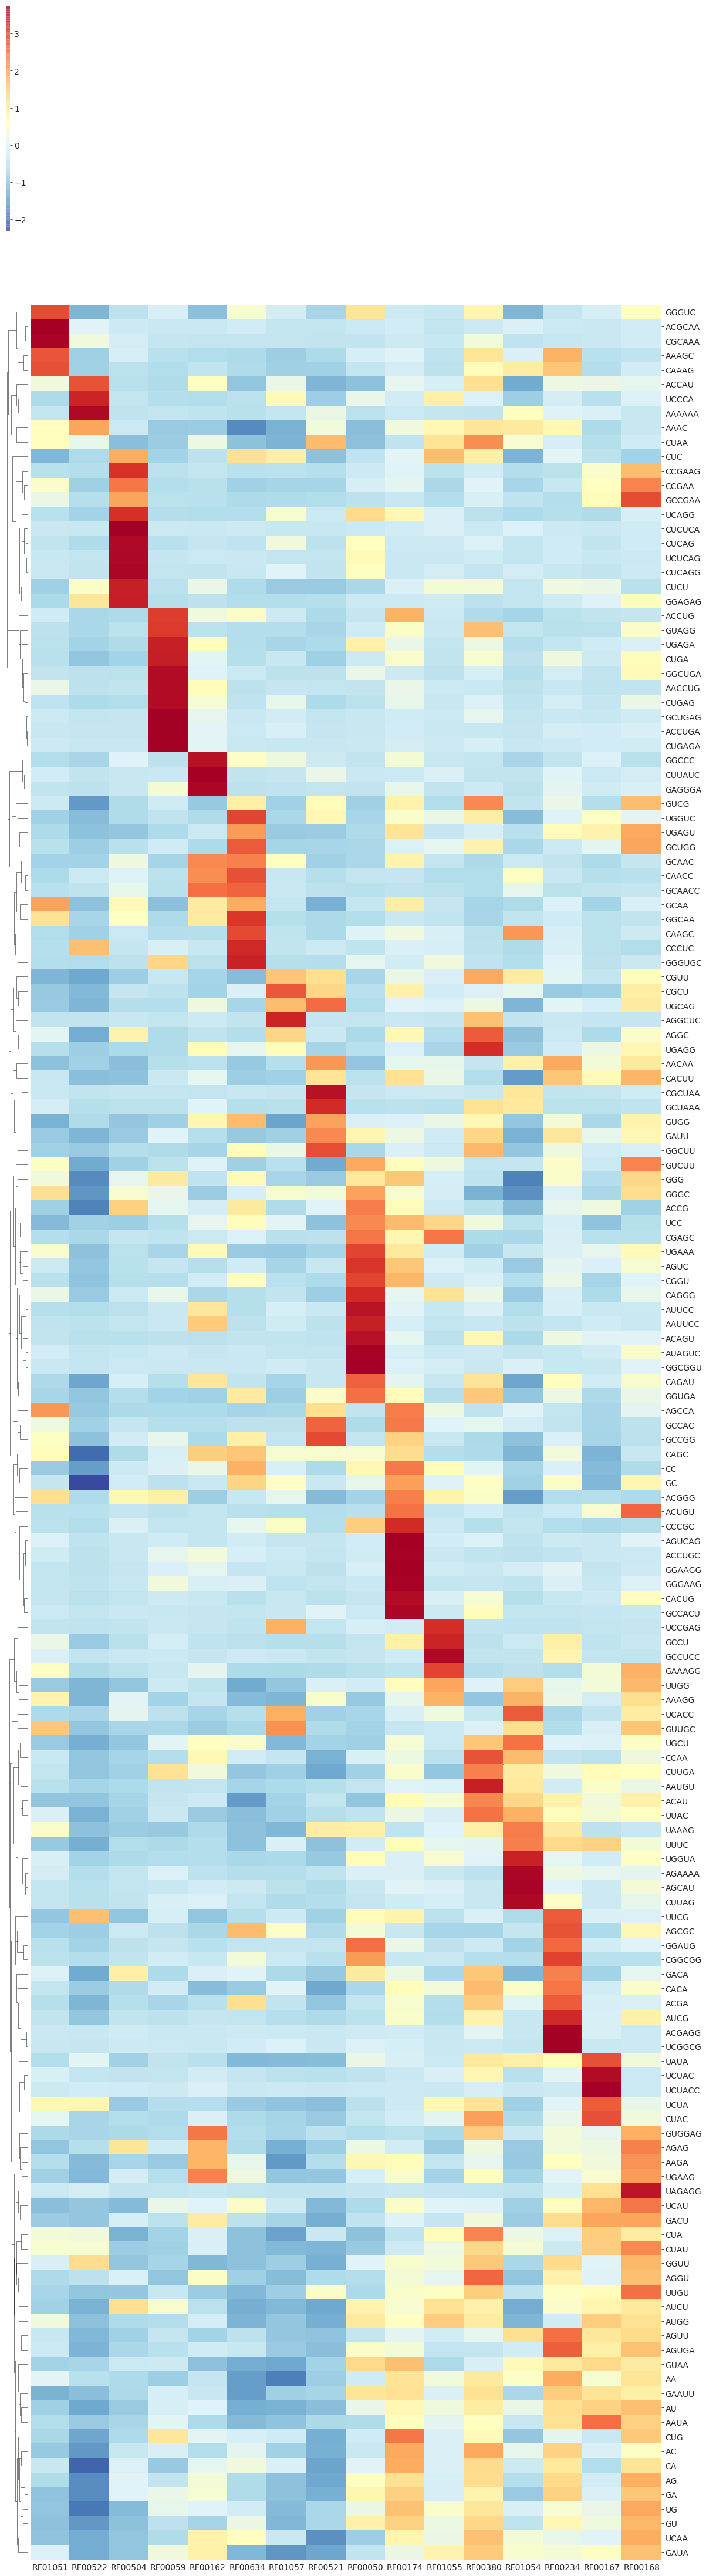

In [406]:
cbar_kws = {
            'orientation':'vertical',
            'shrink':3,
            'ticks':np.arange(-5, 5),
            "drawedges":True,
            'extendfrac':0.5
           }

plt.figure()
ax = sns.clustermap(heat_norm_modi.T, cmap = 'RdYlBu_r', figsize= (20, 80), z_score=0, cbar_kws=cbar_kws, center = 0.6, col_cluster=False)
plt.savefig('test.pdf', dpi = 330)
# ax=sns.heatmap(heat_norm.T, cbar= True, linewidths = 1, cmap = 'Blues', cbar_kws = cbar_kws, center = 0.6)

In [63]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [95]:
y_score = mlp.predict_proba(x_test)

In [82]:
y_score.shape

(4856, 16)

In [86]:
y_score

array([[7.42028735e-127, 1.74313896e-026, 1.15243948e-065, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [4.01757055e-096, 3.68593359e-134, 0.00000000e+000, ...,
        0.00000000e+000, 7.28736115e-065, 0.00000000e+000],
       [2.01707322e-104, 2.10580800e-163, 0.00000000e+000, ...,
        0.00000000e+000, 6.28002996e-086, 0.00000000e+000],
       ...,
       [4.82192596e-244, 1.00000000e+000, 8.07573337e-003, ...,
        0.00000000e+000, 4.97694275e-104, 0.00000000e+000],
       [3.42043237e-111, 5.30937697e-066, 1.37576555e-092, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [7.92646429e-131, 1.07389871e-074, 9.99999744e-001, ...,
        0.00000000e+000, 8.20989096e-142, 0.00000000e+000]])

In [76]:
y_test

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0,

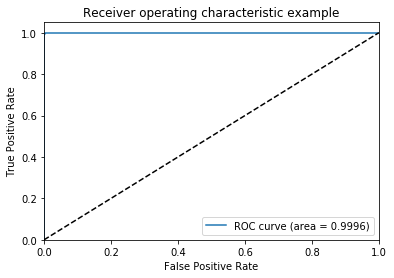

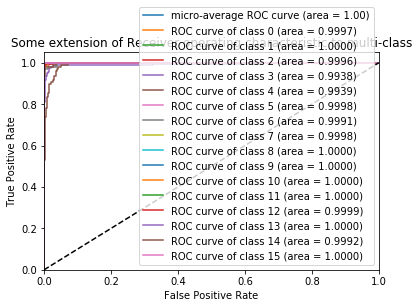

In [96]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(16):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.4f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(16):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.4f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()